引継ぎ用
このファイルは，モデルを理解するために必要な解説のみを書いています．  
上から順に実行していくと，修士論文の内容に沿った考えが理解できると思います．  
これはあくまでも色々試した中の一部の流れなので，僕の試行錯誤の流れを見たい場合は他のファイルのコードを読んでください．

質問は  
yutaka.higashis3@gmail.comもしくは、yutaka.higashis10@gmail.comまで．  
Ctrl＋Enterでセルを実行できます．上から順に実行していってください．  
モジュールはmy_moduleに入っています．  
データは，dataに入っています．

# ライブラリ

In [59]:
import csv
import datetime as dt
import math
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib import cm
from pylab import rcParams
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize
from IPython.display import display
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


from logging import getLogger, StreamHandler, DEBUG, INFO, WARNING

#自作モジュール用フォルダにパスを通す
print(os.getcwd())
module_path = os.getcwd()[:-len('notebook')] + 'my_module'
sys.path.append(module_path)

#自作モジュールと、モジュールアップデート用
#(importlib.reloadをしないとモジュールを書き換えても反映されないため)
import importlib
import graph_settings
import getdfs
import sklardietrich
import dispgraphs


importlib.reload(graph_settings)
importlib.reload(getdfs)
importlib.reload(sklardietrich)
importlib.reload(dispgraphs)

C:\Users\user\OneDrive - Kyoto University\shared-Yutaka\Research\Hydrophone_Higashi_MastersThesis\notebook


<module 'dispgraphs' from 'C:\\Users\\user\\OneDrive - Kyoto University\\shared-Yutaka\\Research\\Hydrophone_Higashi_MastersThesis\\my_module\\dispgraphs.py'>

# グラフセッティング

In [60]:
graph_settings.setsettings()

# 初期値等設定

In [61]:
#データ保存場所
data_path = os.getcwd()[:-len('notebook')] + 'data/'
#グラフ保存場所
PATH_SAVE_GRAPHS = os.getcwd()[:-len('notebook')] + 'graphs/'

# ピット直上ハイドロフォン長さ[m]
length_hp_m = 0.275
# 5本のハイドロフォンの長さ[m]
length_C_m = 0.5
#　ピットの開口幅[m]
pit_width = 0.2

# それぞれの粒径界の対象重量（左から1024倍，512倍，256倍，，，2倍）
W_IDEAL = np.array([0.15, 0.22, 0.29, 0.65, 0.91, 1.96, 3.01, 6.91, 10.81, 50])*0.001
#　それぞれの粒径界の対象粒径
TARGET_TOT = ['-2mm', '3-5mm', '5-6mm', '6-7mm', '7-8.5mm', '8.5-10mm', '10-12.5mm', '12.5-15mm', '15-20mm', '20-30mm', '30mm-']

event_marker = ['.', 'x', 'v', '1', 'D']

# ハイドロフォンのそれぞれのチャンネルの名前
suffix = ['_Tot(1)', '_Tot(2)', '_Tot(3)', '_Tot(4)', '_Tot(5)',
            '_Tot(6)', '_Tot(7)', '_Tot(8)', '_Tot(9)', '_Tot(10)']

# 直上中央ハイドロフォン
names_of_center = ['hp'+ s for s in suffix]
# 中央ハイドロフォン
names_of_C = ['C'+ s for s in suffix]
# 中央右ハイドロフォン
names_of_RC = ['RC'+ s for s in suffix]
# 中央左ハイドロフォン
names_of_LC = ['LC'+ s for s in suffix]
# 右ハイドロフォン
names_of_R = ['R'+ s for s in suffix]
# 左ハイドロフォン
names_of_L = ['L'+ s for s in suffix]

# 右鉛直ハイドロフォン
names_of_VR = ['VR'+ s for s in suffix]
# 左鉛直ハイドロフォン
names_of_VL = ['VL'+ s for s in suffix]


# Corrected直上中央ハイドロフォン
names_of_center_Corrected = ['Corrected_hp'+ s for s in suffix]
# Corrected中央ハイドロフォン
names_of_C_Corrected = ['Corrected_C'+ s for s in suffix]
# Corrected中央右ハイドロフォン
names_of_RC_Corrected = ['Corrected_RC'+ s for s in suffix]
# Corrected中央左ハイドロフォン
names_of_LC_Corrected = ['Corrected_LC'+ s for s in suffix]
# Corrected右ハイドロフォン
names_of_R_Corrected = ['Corrected_R'+ s for s in suffix]
# Corrected左ハイドロフォン
names_of_L_Corrected = ['Corrected_L'+ s for s in suffix]



# スロットナンバーと倍率を対応させる
amplification_factor = {'Tot(1)': '1024', 'Tot(2)': '512', 'Tot(3)': '256', 'Tot(4)': '128',
                        'Tot(5)': '64', 'Tot(6)': '32', 'Tot(7)': '16', 'Tot(8)': '8',
                        'Tot(9)': '4', 'Tot(10)': '2'}

meantime=30
# UNIT = 'cm'

# #ashiaraidani
# if UNIT == 'cm':
#     ##初期値m, g
#     rho = 1 #g/cm3
#     grav = 980 #cm/s**2
#     ib = 1/20 #? パーセント？角度？
#     s = 1.65
#     width = 500#m
#     sigma_by_rho = 2.65
#     rho_s = 2.65 #g/cm**3
#     Rb = s #? 砂礫の水中比重
#     # W_IDEAL = np.array([0.15, 0.22, 0.29, 0.65, 0.91, 1.96, 3.01, 6.91, 10.81, 50]) #g
#     # D_IDEAL = 2*((W_IDEAL/rho_s)*(3/4)*(1/math.pi))**(1/3)

#     bump_hp_m = 0.025 * 100 #cm

# オリジナルデータインポート

現時点で，2019-08-31 23:59:00までのデータがashiaraidani_all.csvに入っています．  
これ以降のデータを付け加えるときは，ashiaraidani_all.csvの最後に付け加える形でデータを追加してください．  
csvファイルが大きいため，PCの性能によってはエラーがあり開けない場合が多いため，pythonのpandasを使ってデータをconcatすることをおすすめします．（参考：http://sinhrks.hatenablog.com/entry/2015/01/28/073327）  
以下に，データのconcatnateの一例を示しておきます．（Ctrl+/でuncommentできます）

In [62]:
# ############################
# ####データ追加する際の一例
# ############################

# #ashiaraidani_all.csvを読み込む
# # インデックスをTIMESTANPに設定し，時系列データとして読み込む(index_col='TIMESTAMP', parse_dates=True)
# df_all = pd.read_csv(data_path + 'ashiaraidani_all.csv',
#                           index_col='TIMESTAMP', parse_dates=True)
# #付け加えるデータ（test.csvとする）を読み込む
# df_test = pd.read_csv(data_path + 'test.csv',
#                           index_col='TIMESTAMP', parse_dates=True)

# df_concat = pd.concat([df_all, df_test], sort=True)

# #cvsファイルとして出力
# df_concat.to_csv("ashiaraidani_all.csv")

# #保存されたファイルを出力したファイルをdataフォルダに移動する（念のため，古いashiaraidani_all.csvをバックアップしておくべき）

In [127]:
# #########################################
# ####オリジナルデータのインポート（1分毎）
# #########################################
def getalloriginal(unit='m'):
    '''
    オリジナルデータを読み込み，DataFrameで返す．
    unitは今はmでしか指定できません．
    '''
    df_all = pd.read_csv(data_path + 'ashiaraidani_all.csv',
                       index_col='TIMESTAMP', parse_dates=True)

    #水の単位体積重量を1000 kgf/m3，土砂の単位体積重量を2650 kgf/m3とし質量に変換した
    df_all['Load_Avg'] = df_all['Load_Avg']*1.65
    #ピット内の差分値をとった特徴量（流砂量）を増やす
    df_all['Load_Avg_difference'] = df_all['Load_Avg'].diff()

    #もし単位がmであれば，ハイドロフォンデータを長さで割る，ピットデータは開口幅で割る
    if unit=="m":
        #5本のハイドロフォンの名前取得
        colnames_of_RRCCLCL = names_of_R + names_of_RC + names_of_C + names_of_LC + names_of_L

        df_all[names_of_center] = df_all[names_of_center]/length_hp_m
        df_all[colnames_of_RRCCLCL] = df_all[colnames_of_RRCCLCL]/length_C_m
        df_all['Load_Avg_difference'] = df_all['Load_Avg_difference']/pit_width       
    else:
        logger.info('Units are not in the same unit. You have to match units among all data you will use by yourself')

        pass

    return df_all

In [128]:
#getalloriginal関数を使ってオリジナルデータインポート
df_all = getalloriginal(unit='m')
df_all.columns

Index(['Bat_Avg', 'C_Tot(1)', 'C_Tot(10)', 'C_Tot(2)', 'C_Tot(3)', 'C_Tot(4)',
       'C_Tot(5)', 'C_Tot(6)', 'C_Tot(7)', 'C_Tot(8)',
       ...
       'outC_Plate_Avg', 'outC_RC_Avg', 'outC_R_Avg', 'outC_T75_Avg',
       'outC_VC_Avg', 'outC_VL_Avg', 'outC_VR_Avg', 'turb1000_Avg',
       'turb4000_Avg', 'vel_P_Tot'],
      dtype='object', length=139)

それぞれのデータのグラフを見る  
下の，colname（データの名前）を変更すると，グラフを変更できます．  
グラフの設定はググればたくさん出てきます．

Text(0.5, 0, 'xlabel')

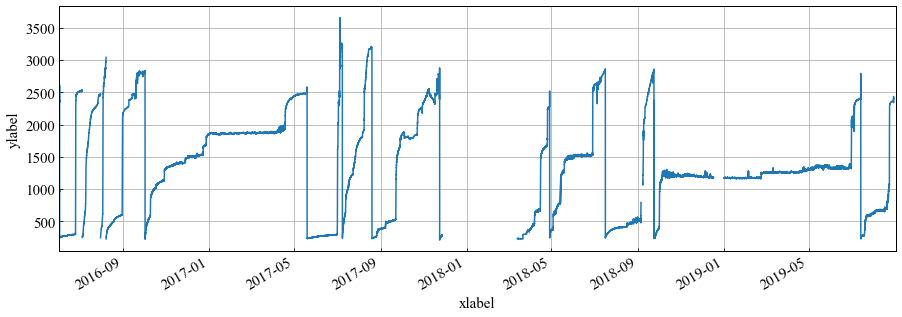

In [135]:
colname = 'Load_Avg'

plt.figure(figsize=(15,5))
df_all[colname].plot()
plt.ylabel('ylabel')
plt.xlabel('xlabel')
# plt.ylim(0,5000)


# 隣合うパルス毎に差分値を算出

隣合うパルス数を差分値をとっていく．詳細は修論の第3章を参照．  
ここで，ハイドロフォンデータ（番号が10まで連番になっているもの）とピットデータ（Load_Avg, Load_Avg_difference），水深データ(WL_FMR_Avg)，流速データ(vel_P_Tot)のみを抽出する．  
他にも使いたいデータがあれば，以下のセルの指定位置に追加する

In [66]:
# #########################################
# ####隣合うパルス数の差分値とる
# #########################################
def make_dataframe_diff_of_slots(df):
    """
    （スロット１のデータ）−（スロット２のデータ）、（スロット２のデータ）－（スロット３のデータ）
    、、、と，隣り合うパルス数を引き算していく．最後だけ，スロット１０のデータのまま．
    columnの名前は，最初のスロットの名前のままにしている
    （つまり，hp_Tot(1)-hp_Tot(2)のデータのcolnameを，形式的にhp_Tot(1）のままにしている）
    """
    # name[1]にはスロット１のデータ、name[2]には、スロット２のデータ、name[3]に、、、が入っている
    names = [0]*10
    for j in range(1, 11):
        names[j-1] = [i for i in df.columns if '({})'.format(j) in i]

    # （スロット１のデータ）−（スロット２のデータ）、（スロット２のデータ）－（スロット３のデータ）、、、としていき、
    # 粒径ごとのデータに分類する
    df_dia = [0]*10
    for i in range(1, 10):
        df_dia[i-1] = df[names[i-1]] - df[names[i]].values
#         df_dia[i-1].name = str(df_dia[i-1].name) + '-({})'.format(i)
    df_dia[9] = df[names[-1]]

    # 全てのデータを繋げる
    df_dia_all = pd.DataFrame()
    for i in range(1, 10):
        df_dia_all = pd.concat([df_dia_all, df_dia[i-1]], axis=1)
    df_dia_all = pd.concat([df_dia_all, df_dia[-1]], axis=1)
    
    ###########################################################
    #ハイドロフォンデータ以外で追加したいものがあればここに追加
    df_dia_all['Load_Avg'] = df['Load_Avg']
    df_dia_all['Load_Avg_difference'] = df['Load_Avg_difference']
    df_dia_all['WL_FMR_Avg'] = df['WL_FMR_Avg']
    df_dia_all['Velocity(m/s)'] = df['vel_P_Tot']
    ###########################################################
    
    return df_dia_all

In [67]:
# make_dataframe_diff_of_slots関数を使って差分値をとる
df_all_diff = make_dataframe_diff_of_slots(df=df_all)
df_all_diff.columns

Index(['C_Tot(1)', 'LC_Tot(1)', 'L_Tot(1)', 'Plate_Tot(1)', 'RC_Tot(1)',
       'R_Tot(1)', 'T75_Tot(1)', 'VC_Tot(1)', 'VL_Tot(1)', 'VR_Tot(1)',
       ...
       'R_Tot(10)', 'T75_Tot(10)', 'VC_Tot(10)', 'VL_Tot(10)', 'VR_Tot(10)',
       'hp_Tot(10)', 'Load_Avg', 'Load_Avg_difference', 'WL_FMR_Avg',
       'Velocity(m/s)'],
      dtype='object', length=114)

ここで，オリジナルデータは今後たぶんもう使わないので，df_allを削除する

In [68]:
del df_all

# 訓練データとテストデータを抽出

訓練データにとして，厳選された箇所をtraindata.csvに追加する．
同じく，テストデータとして，厳選したイベントをtestdata.csvに追加する
その後下のセルを実行しデータをインポートする．

In [69]:
df_traindate = pd.read_csv(data_path + 'traindata.csv')
df_traindate['starttime'] = pd.to_datetime(df_traindate['starttime'])
df_traindate['endtime'] = pd.to_datetime(df_traindate['endtime'])

df_testdate = pd.read_csv(data_path + 'testdata.csv')
df_testdate['starttime'] = pd.to_datetime(df_testdate['starttime'])
df_testdate['endtime'] = pd.to_datetime(df_testdate['endtime'])

訓練データとテストデータを確認

In [70]:
display(df_traindate)
print('Date Of Train Data')

display(df_testdate)
print('Date Of Test Data')


,starttime,endtime
0,2016-06-25 00:00:00,2016-06-25 12:00:00
1,2016-07-05 00:00:00,2016-07-16 00:00:00
2,2016-07-31 00:00:00,2016-08-03 00:00:00
3,2016-08-08 00:00:00,2016-09-01 00:00:00
4,2016-10-03 00:00:00,2016-10-31 00:00:00
5,2017-07-01 00:00:00,2017-07-02 18:00:00
6,2017-07-10 00:00:00,2017-08-15 00:00:00
7,2018-09-08 00:00:00,2018-09-08 08:00:00
8,2018-09-30 21:00:00,2018-10-01 06:00:00
9,2019-06-30 06:00:00,2019-06-30 11:00:00


Date Of Train Data


,starttime,endtime
0,2017-09-22,2017-09-28
1,2018-04-15,2018-04-16


Date Of Test Data


rainとtestの期間のdfデータをlistに格納する．

In [71]:
#train_dateとtest_dateをリストに格納する
list_traindate = df_traindate.astype(str).values.tolist()
list_testdate = df_testdate.astype(str).values.tolist()

#trainとtestの期間のdfデータをlistに格納
list_df_train = []
for traindate in list_traindate:
    start_train = traindate[0]
    end_train = traindate[1]
    list_df_train.append(df_all_diff[start_train:end_train]) 
    
list_df_test = []
for testdate in list_testdate:
    start_test = testdate[0]
    end_test = testdate[1]
    list_df_test.append(df_all_diff[start_test:end_test])


ピット内データをグラフ表示（赤がTrain，黄色がTest）

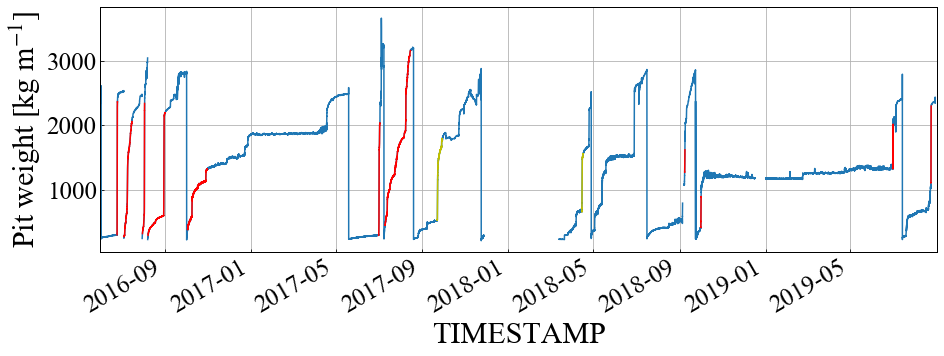

In [72]:
# trainのピット内増減を表示
colname = 'Load_Avg'
plt.figure(figsize=(15,5))
df_all_diff[colname].plot()
plt.ylabel('Pit weight [kg m$^{-1}$]')
plt.xlabel('')
for df_train in list_df_train:
    df_train[colname].plot(c='r')
for df_test in ldata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA7AAAAFkCAYAAAAZjdfSAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOzdd5hcVfnA8e+Z7dn0bHphU0hCQgiBkIC0IJ0QpYoUBVQQURGUHwZFOhoFpaggIkWKiEpTE0oChERCqCGF9F5IT3Y323dm3t8fd2Z2dnd2d8q9c+fOvp/nyTOzd8695+xkdu597znnPUZEUEoppZRSSimlMp3P7QYopZRSSimllFLx0ABWKaWUUkoppZQnaACrlFJKKaWUUsoTNIBVSimllFJKKeUJGsAqpZRSSimllPIEDWCVUkoppZRSSnlCrtsNUE0ZY3RdI6WUUkoppVSHJiIm1nYNYDNQR1+bd+7cuUyZMsXtZmQdfV/tp++pM/R9dYa+r/bT99Q5+t46Q99Xe+n76RxjYsaugA4hVkoppZRSSinlERrAKqWUUkoppZTyBA1glVJKKaWUUkp5ggawSimllFJKKaU8IakkTsaYJ+xuSAwiIt9OQz1KKaWUUkoppTwg2SzEVwACtJ4eKnnh4wqgAaxSSimllFJKKSC1ZXSewQoyneADLnPo2EoppZRSSimlPCjZAFaAb4lI0M7GhBljctEAVimllFJKKaVUlExN4uRUz65SSnVYeyrrePK9DYjoV6xSSimlvCmVIcRKKaU85Ed/X8R7a/dyzPBejO7X1e3mKKWUUkolLNke2M0420sqoTqUUkrZpKLGD0C935HZH0oppZRSjkuqB1ZEhtrdkGbHDwKO1qGUUh2NCeWND+oIYqWUUkp5VKbOgVVKKWUzE4pggzoHVimllFIepQGsUkp1EL5QD6wmcVJKKaWUV2kAq5RSHYQv0gPrckOUUkoppZLkSABrjClx4rhKKaWSlxMOYDWCVUoppZRHOdUDe75Dx1VKKZUsTeKklFJKKY9rMwuxMeZwINHFAjsB3wUeTbZRSiml7KdzYJVSSinlde0to3MucEs6GqKUUspZOgdWKaWUUl7XXgD7W+B7wExgY5zH7AtclkKblFJKOcCny+gopZRSyuPaDGBFpMIYcw/wnIjsifegxpgdKbdMKaWUrUx4CLG7zVBKKaWUSlo8SZweBgYneNxXkmiLUkoppZRSSinVqvaGECMiDcCiRA4qIkuSbpFSSimllFJKKRWDU8voKKWUUkoppZRStko5gDXG9DTG5NnRGKWUUkoppZRSqjV29MDuBi624ThKKaWUUkoppVSr7AhgjQ3HUEoppZRSSiml2qRzYJVSSimllFJKeYIGsEoppZRSSimlPEEDWKWUUkoppZRSnqABrFJKKaWUUkopT9AAVimllFJKKaWUJ2gAq5RSSimllFLKEzSAVUoppZRSSinlCRrAKqVUB3P5Ex9SOn2m281QSimllEqYBrBKKdVB3f7vz91uglJKKaVUQuwIYP8KrLXhOEoppdLo2YWb3G6CUkoppVRCUg5gReRKEVlgR2OUUkqljz8oaatLRHhs3nq+KKtJW51KKaWUyj6uDyE2xgxzuw1KKaWctftAHffMWsGXZrzN1v3VbjdHKaWUUh7lagBrjOkJrHGzDUop1VGNH9w9LfXMWb6TSb98K/LzgnV701KvUkoppbJPrlMHNsYUAt2B/FgvA12A652qXymlVOuGlhRzUM9Ojteze8c+bvnD69C1JLJtUI8ix+tVSimlVHayvQfWGHOJMWYJUAVsAzbE+LceWAxcaXf9SimlMseqvzzHwkeu4NAda/nelOFuN0cppZRSHmdrAGuMuRp4BhiL1csazz+llFJZKv/dd6nM78Qrf7qGE0f2tjamL3eUUkoppbKM3UOIb8QKSlcCDwKbgNZSThYA1wBftbkNSimlYjAm/fcMC7dvZXu/IRxcWIChMu31K6WUUiq72B3ADgKCwCki8kV7hY0xnwPn2FGxMeYM4BfAOKAeeAO4SUS2tVJ+BHA3MBmrP2A2cLOI7GulvAGuBn4AdAL2AfeIyCtttCmhOpRSKtt02buLsgFD3G6GUkoppbKE3XNg1wBb4wleQ74Abki1UmPM5cBrQClWD3Av4BJgnjGmRZYSY8xRwMfAdmAEMAboCSw0xvSNUd5gDY2+FbhERIYDPwb+Zoz5cSttSqgOpZTKRkN3bEB8rq/YppRSSqksYfdVxeNAH2NMcTyFRUSA91Op0BgzBPghcLiIDAS6At/D6vEcBnynWfkuwIvAFuAnIhIQkVrgKmAg8GSMan4EXArcICJLQ22fDzwA3GuMOdqGOpRSylHWV276fPHZCgB6bt3QtB1pbYVSSimlsondAewfgHexhtm2yxjTgxQDWOBk4CwRWQxWUCwifwKeDb0+qln5HwGDgadFJBjeKCJlwH+BM0PDkcNt7ILV81oOvNzsWM9gvYcPpFKHUkqlgz/QNHR0OpAcMGEMALuv+RHgzhxcpZRSSmUXWwPYULB2LjDZGDOprbLGmCLguzbU+aSI7Irx0sLQ42fNtl8aelzQxj5XRW07C+gBfCQiDc3KrwTKsH7fcSnU4Xnby2u48E8LmL9mt9tNUUq14v31eyPP0xlKjrrmsjTWppRSSqlsZncSJ4BTgQHA+y7fbe8HrAWeC28wxgwDRod+XB9jn6Whx5Oitk1trbyISCgR1bGhfZYmWYfnVdT4+Wjjfg7U+t1uilIqg2zr2Z+BfUvcboZSSimlsoTd68B+DWuY7VG4uA6sMaYrVs/peSJSHfXShNCjH9gZY9ey0GOP0Nza6H22tlJdeJ/DU6jD82oaAgAU5eW43BKlVCbZeuSxLbaleSquUkoppbKI3T2wt2AFxRVY80NXQqsL/xUCl2MtMWMbY8zIUN0BIK/Zy71DjxXRc1OjlEc9LwE2R+1T1rJ4k33CXQzJ1OF5NfVWAFuQp9lGlVJQX11LPtBt7crINp0Cq5RSSqlU2R3AjsDKC3KmiLSbnMkYMxtrmG/KjDHdsJItfRvoFtr8gTHmEhH5Z+jnXqHH6ub7h0QHnIUJ7pNo+eh9mhg1qjHv1Nlnn820adNaOVTmmL/Vmh68fOli6rek1gtbWVnJ3LlzbWiViqbvq/28/J5WV1eza2etY+2v+uOzTAVGb1gWqWP1futG1+LFi/Fva/17wsvvaybT99V++p46R99bZ+j7ai99P91hdwC7HugeT/Aasgl40I6KRaQc+Ikx5mbgAuA3WEvWPG6MeVtE9gL1oeKt9QPkRz3fF3qsx3qf2tsnunyidTSxatWqVnbNXFdMnwlAzyGjmHLEoJSONXfuXKZMmWJDq1Q0fV/t57n39PWZkaedOnWiT99uTJkyoY0dkrfwMeu+4ftXXB95j4o37oMP3mf8+PEcd3Dr82I99756hL6v9tP31Dn63jpD31d76fvpDrvHe/4a6GaMyW+3JCAiAeA2OxsgIvUi8jfgaKxhv11oTMS0I/TY2jq13aOe70lwn0TLR+/jedefcjAAp47p63JLlFKZIGf0SAAGXXNFi9dEV4JVSimlVJLsXkbnGWAOcGU85Y0xnYD9drYhqi1bgT+HfhwQelwSeuweqru5cPS1TUT2NNtnQIzy0fuEl+tJpo6s0SnficTWSimvCR44AEBRj66RbToFVimllFKpciLjzkXAMcaY0jjLOul/ocftocclUc/HxCg/IvT4WtS2N0KPY5sXNtY6QcNCP76eQh2eV+cPkpdjyPHpJapSXrB+TxX/WfyFY8cf/sjvAOg6qL9jdSillFKq47F7GZ01WJmHTwYWGWPWt/FvN/AXO+uPoRtQRygIFRGJqvOEGOWPCT3+LWrb37GyKh9jjGnevXgo1hDleaEe32Tr8Lx6f5D8HM1ArJSylFRag2vyO7XMVafL6CillFIqWXZHHEuAUqzhtt1Cz1v71wvnR5R9A/i1iOyI2nY/Vg/pN6MLGmNKsNaOfVNE3glvF5Ey4JdAT+DsZse/HCvr8s+abU+ojmzw+P82UBVaSkcplZmOGGJNwZ88tCcA3YqarzTmLF1Gp6l6f5Dy6ga3m6GUUkp5it0TFh8CzgU+BBYAVVjrsTZngK7A+UBKKWuNMf8BjgAeA/4gInuMMV2Be4EVwB3R5UVkvzHmMuC/xpifAb/CCk6fBzZiBb3N3YfVm3qfMeZTEdlsjDkf+CFwg4i8Z0MdSinlqECo57MgL4fhvYsZ3b9r2zukYNkhE8mvqmKkYzV437f/+hHz1+xh44yp7RdWKk32VtZRmJdDcYHmtFBKZSZbv51E5F1jzGJgWjwJiowxfwGWpVjtHGA8cAvWMjqfAauAx0Tkg1ba+bYx5gSsntWrsIYZ/xP4jYgciFE+YIw5B7gZeMsY4wM2AKeKyDw76vCyYFDHAyrlBcN7F7N4SxlnHdqPx+avd7Su/Ooq6jp3cbQOr5u/Juvy+KkscOTdcxjYvYj3pn/Z7aYkZcX2Cr726Pu8ecMJ9O9W5HZzlFIOcOL22u0JHHcV1tI7SRORB0liLVkR+Rg4LYHyDcCdoX+O1OFVl/4l5n2CjNAQCJKX4+OtFTs57uASCnJz3G6SUq45qKe1utfXJg52PIAduWkFW3oPjvma3vJSKjMt3lIGwLayGpdbkryfvriEA7V+Xl+2gyuPHep2c5RSDrA9gBWRVxMoG8Dq1VQe9v76vW43AYD9VfVMuGs2APNvOoml28q59rlPGdyziC37arjs6CHcfc44l1uplHvStf6qBIMYwBfwN3tFJ8Eqlcm++kdrRlRhnneTMm7aWw1AaUmxyy1RSjnFu99QSkUpr2mIBK8Ax//mHa597lMAtuyz7iQ/u3CzK21TKtM4nUypen8FAJtP1rmdSnnF/6KGtJ95qDeXv9pVUUt5jZUYLc+nl7hKZSv961ZZYfwdb7rdBKVUyPaPFgNQuG6tyy3JXPPX7Ha7CUo18bOXl7rdhJRd+Oj7kefpGnGiVLYor27gmYWbEA+sdacp5pTnbQ4NF2rPd47TuTCqY0vXOWnfvIUA9Ny2oZV2ZP7J0WnfePxDt5ugVMQnm/axeV81Rx7Ug90H6txuTtI2xXk9oJRq6cZ/LWb28p2MH9SNwwZ1d7s5bdIeWOV5H27c12Lb+l+exVnj+gFw5bGlAIwb1C2dzVIqY5nwGGKH4sjCYQcBUPXgH5vV60x9SqnkBYPC+Y9YPZe/vXC8y61RSrllX1U9YK1Rnuk0gFWe99KnW1ts8/kMxfnWAAPNPKyUJTpeNQ5Gk3XbtgNQ1KenY3UopeyxeKuVefj0sX09nfjoo2Y3s3Wgh1LZSwNY5XkL1jVmQX7xe19ixZ1nAHD+kYMAmDzUuojWk5lS6XHU7T8GoGLtRncbopRqU+n0mZz78AIAbv/K2Mh2Lw7zv/BP77dfSCnVKi/93WsAq2wzsm9nt5vAkQf1oCjf6nE9elgvNs6Y6uk7ykp50QdnfA2AIaedGPN175winfH2yp1uN0Ep3lrR9HPYv1sRoEP9lerovPAdYGsAa4z5oTEmocRQxphOxpgzjTFnGGPy7WyPSq83b4h9saqUyhBpurs6+fV/AFDcu+kQYg+cEx23dlcl33rqY7eboRTV9YHI82NH9HKxJc7o6DfKlMpmdvfATgd6xFvYGHMQsBR4EbgHWGOMOdbmNqk0OOfwAW43QSkVh3TeWc3vVJi+yjyivKbe7SYoBUAg2Bji3XPOuCavafCnVMfjpb97u5fR8QFdjDHTgNFAEVaA+ncRqYhR/gGgFLhcRJ41xpwAvGyM+bKILLO5bcoheTmG/t2L3G6GUqodXjo5Zat6v/4vKPftqqjl+hc+i/wcPdXGiyMl1u464HYTlMoimf8t4MQ6sIuA5pMh7zbGXCIic8IbjDE5wGmhH+cAiMg8Y8wDwPPAOFTGq/cHaQgIRXma6VcpL0jHaWlV6RjqO3XWL/EY6gOZvzyBym6ff1HO1If+53YzbLV0WzkAXQpyOVDnB7yVkEYplRi7hxD7sIJX0+xfCfCqMSb6eqYEq4cWYE/U9r8CY40x59rcNuWATzfvB+B3s1e73JL2ifY/qQ4uXddznSv2U9cj++bU2cGvAaxyyZ7KOkb8bFbWBa8AN7ywGIDLjjnI5ZYo5V1euudjdwBbjDVK7S/AUaGfu2P1tG4Abo8qGxlzKiL+qOfbgP3A+Ta3TTng639eCMCUUb1dbglMGx97Hm7mD4RQKn2i13916qZOl6oKAt3jTofQoTRoAKtccP/s1Uy8ew7+YNO/+bvPOZR3bpzSoryXLmSje1qvP+VgvjZxkIutUcr7OlwWYiAfuEtErhaRT0SkRkQqQkOHv0bjkGGAvNBjrK/JfcBkm9vmGSfdN9ftJiTs9mlj2y/kgF0VtQCUdM7n9xdPcKUNSnmRU+enoD9A17oqfJU6Jy2W5gGEUunw4FtrYm6/dPIQhjZbas544eo1yiufbYs8L8jN4euThgA651+pbObEEOJHY70gIssBjDHdQpvC35CxUjIaoK/NbfOMDXuq3G5Cwtxaa/WiUA/wnkrN7KkyX21DwNV5WekYRr/+rfcAGPbxfMfr8iKNX1W6/WfxF5HnG351VpPXvBasxnLv66sA+L/TRwE66kqpZHnp9GR3AFtGY89qE8aYUqAAqAxtCmf9qY5RvCdWb65SbfJisK86pt0H6hj9i9d5bP56V9vh9MVdQ4X1Fb/u+psdrsmbghrBqjQSEX74/CIA7jrn0KwIWJubNLQnuT7D908a4XZTlMoKXviWsDuA/RD4RfONxphBwHPAEhEJr5wd7ond36xsP6x5s/tsbptywFfGD6BfV13rUan2bC+vAeA/i7e71oZ0dP4e8rWpAPQ8rmPOAgkEhW1lNa2+rkOIVTqFEy0CnHhw01wVpxzSp9X9vPQpfeWzL9ovpJTKKnYvo/MQMMsYMwmYhzU8eARwKlAIrDTG3AW8DFwV2qfeGOMTkXBmi2mhR10H1maVdX6K83NsvQMbEKG4wBtL6HgpKYXKPuG4xe0OkHTVP+jYiempKMMM/9ksAH508sHccOrIFq8HgprESaXPvqqGyPPC/KZ9Ft07xR7o5oXel7DqeisHaMwbQ3rOVypr2RrAisjrxpjfADfRdB1XgzW8+GKs3tV5WFmIBdgJzDTGXAfUAbeEtv/XzrZ1ZJV1fg697Q0ALp40mF+dd5htx27wB8nLsbsjP3FnjevX6mtuBwxKQWOmTDeH8C3aXEZDID1XdYVd3JkX76alW8sjzx98a03MADZd779SAKt3NiZT69EsYD3/CO9n65232lqFcVhUHo5sHCatVFp4qKfH9shDRKZjBaofYwWke4DngckiskRE5gHHA68ATwNnAo8BS7CW2hmMNXz4Sbvb1pGICH98Zy2l02dGgleA5z/cYms9by7fycod7mcbPXqYrjmpMlukB9bFNry/fq+LtWe/aX9oXF/zlENi5yEM6BBiz/vFK8sonT7T7WbE5Yuo4ew5zQK7Y4Z7/7wZzq78528e6XJLlMoeXrgJZPcQYgBE5AXghTZeX0TTdV5fMsYcBzwOjASuEhH3oyIPG3rzrJjb58ZY7y0bFOZ6Yxiz6ngCQSHHZwiPZ/Nl/nlB2WDCkO4xt+scWO97ZuEmt5sQt3EDrXQjz191NL4EvnzczJaeiBXbKwAY0adLi9fSkXVdKeUORwLYRBhjDgv1zH4CHG6MyRURv9vt8rIzHpgXeX7EkO7cfc44RvTpjDHYMtx34fq9FOfnMm5Qt/YLO8AfCDJnxS66d2pMeF2Q5/4wZqVqGwLsrKjlsy1l/Ojvn8Uss2lvrMTryusWNuvdvveNVVx9wrAm37kfrN/L/ipd8kulX2lJp/gLe+QmW21DIOZ2jzRfqYzjpVs+tgawxphbgbujEjK1V74bsIjGJXXQ4DV14SG9p4/ty6PfsDeRyntr93DpXz4AYOOMqbYeO14jfv5ai20F2gOrXPLYvPXcM2tF3OXPGtffwdYkxolOloDxsbnvQQy1/9AZbUd5LQCnjenLm8t3AjDx7jksvu00AN5ft5eLH1sYKX/dl0fw0Ntr099Q1aF46YI0UWt3VbZfSCmVMC/cBLK72+o2IPbEn9gusbl+FcXu4PXtlTsjwSs0DjE6d8JAW+tJRqH2wKo021Fey0Of1rYZvF5w5CDW3HMms647ntevPx6A0f1bDnVzg1NTXLb2Gcz+IcOcOXgG23XACmCv+FJpZFt5TQObQz3utf6mvUU/Pm1U2tqmOi6JzL33wiVpYpZts5Km3X/R+Jive2QUtFIqCXYPITbAKcAz7RY0ZgrwW5vr7/AO1Da0XyhJTy1oOu8nnE0zOvuf04Kh+WMj+nRucve1uMD10fCqg6htCDD6F6+32P7fHx5HYV4Og3sWtRgRMGZAV3ZV1Karie4SwRv3b+2zbFs5v5y1EoANe6u4ZPIQ/vbBZgBOuPcdNs6YSu/OBZHy3zmuo/VPK7clesPKC7Hf9JeWAvCV8U1vonsg/4xSGSkTbvp8tqWM5V9UcMnkIW2Wc+Kq/zZjzCttJWEyxnwdK8twAd74nvSM/aE130p7JTDfJU77quo4/uASHrjocLoW5VFVZ432XrUzffm26vzW6PSp4/pHsg8CdNYAVqVBWXU9h985u8m2hy6ewFfGD3CpRZnHiCAd7ArysscbR6acekhfLp18EPX+IP/6ZCsAdf5AJPvw7y+ewDT9vKg0SSaRkdf+enM0M55StnLzFH7OH98DaDeAdWLc5TDgOdNKDmZjzB3Ac1jBq7JZeJjajafbPzxt055qhpUU06tzAXk5vkgPbKf89M0/fe4Dqxd46bZyTjmkT2R7Xo6ewJRzdpTXUjp9ZpPgdfFtp/HUGcUavDZjoEN1gdT5A5RVWzcO1//yLPp0LQTgvgsbhzWOuuV1AqFb250L9WabSh/JgOW7nCAiFOb5+HYboxkyoTdJKS+obQhQOn0mS7eVt184QzgRwP4cax7sI9EbjTFFxph/AbdgfZeuBO4h+75XXVVTbwWwRXn2BpXV9X4O1Pnp260wsi1803PsAOezEf/o74sonT6Tu2da8w1vmzaGCUN6RF4f0jN9w5hVx3P27+c3+XnWdcfTrSivldKZqzg/h8Oczh4u0qEC2FcXfRF53nyZkj9cMiHy/LyHFwAt1+JUKi0S/dhlePC3+0AdtQ1BDoox2iwb5/sq5ZTy6oYW06J8HjhP2X0r+EIRedEY8ydgnjHmFhG52xgzGPg3cBjW1+hLwOVANRB7rQmVlJ3lNXSvqbD9uF+UWfP3+nRpDGDD5zenP+cfbtjHq581XiTef9F4DupVzHdPGMbpY/sxok9nZxugOrR1uyvZU9l06ZMxA7q61JrUVNUHWLLV2TusRgTxdZykaje9uASIPYzx7MMGcPSwXky8e05kW/SFwWGDujn+/6E6tmTi0FYG0GWUd1fvBqBncX6L18LDpusDcS2IoVSHJCIMvXlWk22H9O/Kiu0V9Ijxd5VpbL3KEJEXQ4/7gbOAa4wxM4CPgPB4qttF5AIRqRIrje3s2EdTyej8wnN89tAlFCz/3NbjVtdb812jT2vpGprkD52EivJyWHPPmZw7YRAAuTm+hIJXHU6kEiUinPzbdwEr8c5HPz+Fz+843eVWJeedlbvSUo+JbxW1rBCe1wqw9p4zY5Yp6VzAkJ6NvUTRsf3koT3TOgVDdUChE1+29Uou2lIGEPMa4I3PdwBw/+zVaW2TUl7yxHsbm/y85PbTuDIqi366/euTrZROnxl3eccm44jIFmPMNOBdoDNQCVwuIi+HyxhjioD9RK0Dq1LTu9y6Kzkgx95sxA2hILJ3l8apy+bAAY7f8CmF+/sCpbbW16Tu0EXis9+ZTF5O4vdcsu3ErdLn+hcaB4jcdMZo8nO927N45VMfpaUeaw6sd9+nRAz/WePd67Z6ra4+YRi3vLIM0CHEyh3Z9rGrqvPTv1sho/u1HA1zoNa64b6nsi7dzVLKM+7673IA3v2/KRzUy91peEu2lnHjPxcntI+jVxkisgi4CFgDHBMdvIac42T9HVFlXyudvOnfz9bjvh3qvaltaFzL0GzawDP/uJU+iz+2ta7mwj2wmqhJpZOIRIaur7zrDE8Hr2klgnSAP9XwqBSAFXee0WbZC44cFHnuD+pQEJU+yX7akslenE6rdhxgVL/MWFNbKa/ZUd64rJ/bwauI8JU/WJmHH7p4ApdOHhJzakBzCffAGmPWknjgmwv8p9kd6i5Az0Tr7wi6ppClMthg9bzm5ts7fv2P76wDYFxUAhgTynjs9Hy3hkgAqwGESp/fvtk4/KzQ5qRomcKJYfWmgyRxGnPrG5HnRe0MA47+/Gwrq3GsTUq1pvlf5MWTBsddNtNs2FPFyh0H+NLwErebopQnffm3cwF4/PKJ7jaExqHMfboU8JXxA/jK+AHcc+64dvdLJlJaA9g5CSyzb/O5IJU1zaTB6hXIzbdvdPiHG/ZFnvfvVtRYVyDUG5vj7MV9eLke7YFV6fT0+xsBWObROa/NHTuiF++t3Rv52amh9QZpOtEzSxXn51BVH2BNK3Nfm5t13fH84PlPuTCqN1Ypp8W6SbVxxtT0N8RG1zzzCQCj+rWdA0MvLpWKrTq0YsnxB/d2uSXQ+R9/4+cLP+b0155LaL9kopzHsALYfwOrgFog0awdBugOnAvo2dxGgVAPbF6ePQHsu6t3c/kTHwIw87rjmr4YTE8A+8R7GwDId7gepaJVhOZRdS7IjnU7w9lvn/7WJEfrMSJIxvfhpK4qdAEQ78iQMQO68vZPprTYrsnllJMknMQpi0ZFbN1fDcBFRw2J+Xr2/KZKOSsTpkYNW7mIoSvmURJjSay2JHNl9m/gfRFJef6qMeYp4JNUj6OihOZXGRsC2LdW7OTbf7Xmt542pm/L9V4jQ4idCSyr6vyMva1xmN6gHkVtlFbKPgvXWz2Vg3tmz2cuKMKRB/XghJHO3nHtKEOI7ZBNQUVHUOcPMOqW19svmIESXgY2Q2+s+ANBquoDDCvRtd+VygaSZN6MhKMcEfEbY36feFUxLQfetOlYykbV9Uyb2JEAACAASURBVP5I8ArWxOrmwkOIxYGe0W1lNRw74+3Iz/NvOglfCkOrlUrE1/+8EIDnrzra5ZbYRwTS8ick2T2E+P7Zq3nwrTVuN0O54IE53vt/T24dWNubYZt9Vdaa3Bcd1focXqWUtyQzaivZq4znjEl9nQQRqReRFhOIjDE5xphArH1Ue1K/bSoinPfwgsjPq+4+I3YSG39obVibT3abKgKR4HVSaU82zpjK4J6JDS1Qyg6DemTP5y4okpYlpXwijid2c8vkX87R4LUDe2SulczwsqOHeCYnQ2S9dm80t13hoft9uxa2WiY8siFTe5GVynSSxj8ek2RdyV5lpOOrMEu+bt2RyoXqu6t3s3LHAQBm33ACBbmxe1hzV60EoPO2zUnXFcttC6z03qP6duEf1xxj67GV6qhESMu3qpFgmrp60+uTTfvZWWGtK/nTM0a73Brlpq6FeW43IWHZsh56IqsSBDWCVSoxLnxNWNcm6euBTce3gn7zJCPFNQb9gSBXPPkRAE9cMZGD+7a+zlrDyFEAHDhoeEp1Rvt4o5XxuHeXAt644QTbjqtUIg7p35Xxg7u73QxbCemJK30ikPoAnYxz/iPWqJTvnjiM702x7ztPecd5RwyMa33CTJL0OrAZegVW77cC2LaSz2RLb7NSHUKSXzapZPrJ0K8377PjjTVJDuFbs6sy8vzLo/u2XTgYTj5t39li4tBerMzNp668sv3CSjlkxfYKt5tgOxHBhpkf7bJ6YLMvgA27+cxD3G6CconPGIo8tiZ0ZChgAqfpTO6trY/0wGZuG5VSCRBBkrjrlGwAa4C3jTFOBbH6zZSkVMet/3XBRusxjqU2IlXZdK1avnUH3YBCfz2Fnbw3REtllxF92l5j0GtiJQcWB+5D+rIwC3H4e7VrYXYsqaSS4+UhqdnyJxnpgY1z+SqlVGYTkkvilMrZ+MQU9o2Hd88UGSDZ5RnW7Kpk4kE9ODGBpTbsOi+u+tPTTAJeve4WvmrTMaPpB0rFa3DPIsYN7NZ+QQ+xhhA3/rU6dkGbhUmcwiNTooct3vnVsRyeZcPMVTuyO8G2J/gD1pk8N54AVk/6SmU8I8mtHJ9sAHtHkvupDLejvJbJQ3vGV9jmu9Fd/v4cALljR9h63Gy586zSZ8u+GvJyytxuhq3SlVXQl4XL6LyzchcA914wPrLtm8eUutQa5ZZ0ZfJ2gjdb3ZI/NHUpt40hxF79P1KqQ0rXOrBWXaIBbKZK4SJ1W1kN28pqeGnRNn530eHtVxV+YtPFak3PElgHRcMG2nI8pVKxfneV202wVZKJ/hLmy8I5sP5QcrzSkmKXW6LclK5EaHby8KjnmAKhv8XcOP4jsuxXVypllz/xIe+u3u12M5oQSGoObFZcZRjLd40xi40xtcaYfcaYV40xE9vY5whjzExjzAZjzFpjzK+NMUVtlM83xkw3xqwyxqwzxrxrjGkzTW6iddjJJHGWnfHaysR2CJ0Z7TqfN/TpR0VhZ3y5Os9MuatTfg5XfKnU7WbYKl0XsiYLe2ALQkOHvZaBVtkrKMlPz3FLeJ6719rdmrLqBgBy2rjGCf+q6VzLUqlMJyIZF7wCkOQQ4my5yngU+BNwGFavcg/gK8ACY8x5zQsbY6YBC4C3RGQocCRwLPCWMabFLXZjTAHwOvAN4FQRGQ78AZhjjLkwVoMSrcM2KXxhby+rAWDZHacnVpVdJ0Z/A/4cb2V4VNkpKNLmMg1elY6LWJ8E258D67Hrypr6AIDnMtAqe1mZvN1uRXI82uwWfvLPxQDUNgRbLRP+XT32NaOUo8JLZGYaI5JUEifPX6EZY84EzgUuB7oChcA5wG4gD3jSGFMSVX4w8Bzwtoj8DkBEyoFvA0cD98ao5tfAScCVIrI5tM8/gX8BTxljhjZrUzJ12CuJ5TI+3rQfgM4FifWA2nZCl+QykSllt0BQ4hqi5iXpupgrCDQw4eWnY77m1V6gBl26QxHK5O12IxKUrZ2QRwxpPYGaR79mlHJURva+0rGHEF+B1Sv6tIgcEBG/iLwKXBx6vStWb2zYbUAX4Mnog4jIKuAj4BpjTGShP2NMKfB9YLmIfNis7meATsCvmm1PqI5McfDuTfSu3B//DnafGUWQNKxTqVRbRISGQPYFsMkO00moilCClUJ/vcM1pVd9QMjP8Xk2AFf2EKRJJm8vsHuglJuihwTr36JS2cEkGUtkQ7QwX0Q+a75RRN4CFoV+7A1gjMkDwkN+F8Q41kKsG6zfidp2Edaw5FjlPwg9nmuM6ZVCHfZJIaic/cT3efuvP0igqvDcGns+RiYYTCoTmVJ2CuUIiW+ZBg9JRxKnYKinctGRU5ytKM0q6xqoD7Q+ZFF1DMGgdwPBbMjMu7cqu26MKaVC8/Q7Yg+siPyhjZfXhB43hR6Px+qRrRORbTHKLw09nhS1bWrocX2MuvcB24B8rPmtydZhvwR7j4J+a45XefeSdko2sj1BQpLj4JWyU3W9H4AXP93qckvs9dP7vs/hjz/gaB3+eusCs3bCkY7Wk27PLtzsdhNUBvBkD2wWDSE+7+FYfQJKKU9L8jvK8wFsO0qAOqwETAATQo+xAkuA8MKP44wx4Wwd4X1au5oN7xNedyaZOuyT5NnqwxvvBGDQ1nWJ72zXCV2k/eQvSjlsR3ktAJv2VrvcEvtIMMixm5Zw/XvPN91u88VtoN7KEGo0k7jKQkEPBoONWYhdbogNNu+zvpNvOGVkXOWzKXhXKlWTtixjyroMTOQkQZLJLpC10YIxphNwDPAXEQkHjb1Dj2Wx96I89JgLdDPGFAKd49wn3HWZUB2tlElZosvo5Jb0AuCjO53toWmLkaBmDVSuq6zzu90E21XvrwDgoxOnOVpPoCH03mk2cZWFxIPL6GSTcydYa8R/b8rwNsuF/49EryiUivjH36bz1L/ucLsZMSUzfdCV2+TGmFygt4hsd7Ca7wAHgFujtvUKPbbWtRI9yakQiF6ztb19CpOso4WysjJGjRoFwNlnn820afFfdFbutrKMLXz/ffK7d4l7vwEPPwjAdoLMnTs3rn1k5UoGABs3biQY5z5t8VVXI0BlZWXcbYjH7mrrLV+5cgVzD6y17bheY/f7mk3K64TyuiCzNjSwcHsgsr299yuR97Ss1vocrl61mrk1G5JtalKqN27nLMC/f1+kvVVVNewJVtv6majbU87pwJ79+2Med32Z9d4uWboEs6P100+mfVaL86A+0P7nIVGbN9cTCATS9rtm2vvqNbv31FJdJ2zeXEMwKMydOzfj39P166xh/fPmzSM/zizaVVXV7Mbe74ZktHhvD1i/y/x577a5DuyWLVa5QCD+65mOJNM/s17jlfdzSoxtzdu9aqs1imrhwoWUFKWnj9NXW0dQJOH30NYA1hizD+gl7U+ODAK3GWO2i4jttwNCCZV+DlwemqcaFs4A0No3X/Qq9fuwMglHDtvOPuF6Eq2jhe7du/PZqlWt7N62hf+aDcAxX/oSXfr0aqd0o6U9SmD7ek6+9kqKe7Wenj7atu1W84cOG8rxU6Yk3NbmPir8LeLLoXPnzkyx4XhhW/ZVw7x3GDVqNFMmDrbtuF4zd+5cW9/XbFDnD3D7v5fz/Iex5zi2934l8p7uqqiFuW8xctRIpkw+KMGWpmbncisdQM7UaZH2Fn82j5KenZgyZaJt9ezdsAWA3v37MznG+9J9SxksfI/Dxh3GlNF9Wj1Opn1WR69YQFFeDlOmTLb1uO9Xr8C3bWPaftdMe1+95umNHxE4UMuQIb3xbVrPlClTMv49/VzWwppVnHjiCRTkxjcyonjRPHqXFDNlirtz2Zu/t5/5V8PaNZw0ZQq+NgLY92tWwIb1+Hy+jP6/cUumf2a9xmvv58zrjmPqQ/8DWl7j7Pp4CyxbwtFHH82gHp3S0p4P8n+V1N+q3T2w3bECtzYDWBEJGmN+AGw3xlSJyH02t+Mx4F4Reb3Z9h2hx+JW9gtHblUiUmuMacAKSPPj2GdPMnW0UibtKseMo27VoriDVyAywcSuEVUmmFwmMqWSISKMuqX5V0R2kkDob9Xhob3B0BxY8vIcrSfdqur8Ca+PrbKPiPeSOGWTcNdIvP8FOoBYqZYy8VyWCevACvF/Z/TBGqJ7nZ0NMMb8DNjcSlC8JPQ4oJXd+4YePwMQkQCwPJF9Eq3DdklmLcj7YhtVhYndbYlakS2pOlseUOfAqvT5dHMCax57XNBvzU11OklaoMEaIuzLsiROK3ccyNhF4FX6BMW2s13aRJa781zLWxIRjGl/HnI2/K5KOaU40wJYSW6JuqR/C2PMKcB0WgbBbxtj2otDOgNjseaAxpwHmmSbLgNGAVe0UuQdrB7VPsaYEhHZ0+z1EaHH16K2vYGVYXhsjPpKsBIxVQHzU6jDdibBC9VByz8lz9+QWCUOnBjFpjVllWrP+Y+873YT0iYYSq5k4hxCmHw9oe8Qh+txw7iBjuXcUx5hraXszeDIo81uwos3EJTKNLkJJnlNjzT2wIrIHODbwAasucEnhl46MfRzW/8mYvW+GuB3ybYhmjHmPOAc4NvN5+AaY3KMMYNFpAJ4IbT5hBiHOQZrfu4/orY9HtrWWnmAF0WkDiDJOuyTZA9sv7JddKlLbNmQSE22DSEOJjWMQKlEDb15ZrtlXv3+se2W8QoJWj2jTgewm5+0lukJvpdd6zUO6FbIqH7xJ8VT2SncA+gl2bSUzAcb9npyKSOlMknGDSEWkoojUvotRGQT8G1jzKvA81i9qU/T/jBiP1YCo7dE5M1U2gBgjDkHuBz4moj4m73WD7gX+AuwBbgDOA/4JvBSVLlDgSOAP4vImvB2EVljjPkzcI0x5nARiR76ezlQEzpmtITqcEIid4nrq2vJBz6YegnJpCix7Y606BzYjkZEEKHNhBzNbd1fzcDuRZHP3aa9VfTvVkR+rg9/IEhujo+GQJBcn+HWVz/nmYWb+PiWUzDAvqp6Tr1/Xrt1nDCyN+MHJzAfPMMF/aHMyj5nA9ijf383AP1um+5oPckSEfZXN9CzOL/9wlHqA0Jejo4O6ehE8Nwc2PDFmLdaHdtHGzvOtA+lnBL+TsiYnlgRJIlvKFvCcBH5tzHmAuA/wLdEkhzQnARjzKXAU0AlsK1ZMJWPlUl4C1YwiYisM8Z8F3jKGHOZiDxrjBkCPAu8B9wQo5obgaOAPxljzgL2Az8ApgGXisj66MJJ1uGa3cvXMBAwRxyR2I523woVIeixiwMv2VkVpHS61fO4+NbTKMrPYeQtr/HdE4dx85mHNClb2xBg8ZYydh6o4yvjY0/nLp0+kx6d8lh062mAtX7qPTOX88tzx1HTEKCsuoEB3YsQEeoDQR7/3wZ+87qVXXvlXWcAMPoXTZMoHX9wCfPXNB11P6m0J8eOKOH+OauT/t0n3j0nrnLfOW4oPz5tJJ3yM+wOZYrCAayTSZy2ffI5A0PPDzrW3eylsYgIQ2+eBcAfLpnA2Ye1lqagJX8wGPcSJCp7BSWZy6zM4NWhz8mI/KraW6tUC7k+w6WTh3DeEQPbL5wuSXw/2XaVJiKvGWPuJo1fGcaYqcAzWDcX2+oueT56WLGIPGeM2QXcYYy5E2vN1ieB34tIffOdRaTKGHMScBfwMdYQ4GXAUSKypHn5ZOqwTRLjhba//g4DgeCe5tN146zKprs4RoLaA+uQcOAaNv7OxoEPj767nkffte7B3HPuoRw6oBtf/eN7kdeve35Rq8fdX93Q4tjPf7il3fY0D1zDmgevAB9u3MeHG2OuOJWyG08byX1vWoHxf394HIdm6TzH8BxYX7MhxHZ+WW95/FkGAp/c+yiZF74SCV4BXvhoS0IBbFl1AzUNgfYLqqzmyR7YDhjEhf+Hgh3xl1eqHcYY7jl3nNvNiDBJ/p3a2s0gIrcnUt4YUwgsF5FhSdY3kyTn8YrIbGB2AuUPANeH/jlSh51MAkFlbncr9u819bSE6mjsaLdvCLF3729npkWb93Puw/HPR/z5y8scbE18RvTpzNpdla2+ftu0Mbz46VaWbasAoGthLseOKOG1ZTu4dspwHp67jkP6d+XEkb158/Md9OlawML1TQPg6GD1qNKeBIKStcErNM6BJaoH1u4eGdmzh3pfLuOu/aatx7VDVV3jzJJhJcV0LYxvmZ99VfXMXm6tjPaPj7fymwvGO9I+5Q1B8V4WISGcbLHj8Ng9BqU6OEnqZrrb4+S+DhzkchuySxJ3Mhr27gWgU9+SpKq07WQhokmcbNY8eN04Yyq7D9Tx+7fX8PT7mzhtTF/mrt5Nvb/lqP/5N51ETUOA0+6fxxvXn8DpDzTOHf3NBYdxzuEDqakPRHpzJw3tyQtXH01QoN4f5M3lO+hVXMBxB7f8XNX7g4y85TWuO/lgfnzqyMj2/VX1FOT5yPEZ8kNzDueu3s3xI0rIjZqDeOWxQ1v9na87+WAKcn0YY5h+5uh236PJw3q1W8brJDyE2ME5sIXr1vJFn0GUdrItsbxtxt72BgCPfXMiVz39Mev3VPHHdvZ56dOt/Pgfi51vnPIMwbYBR2mnp1alVMZycwhxYxtMKXAtMAkowUrs1LyX1ABdaXvYr0qBSWA5msBeq3eq88B+TjUnLiaoSZzsFD2096Vrv0TFeutivHeXAu786qHc+dVDW+yzo7yWorwcunVq7KHaOGNqk8do+bm+FttzDBTl5/DVw1ufXxFrP4AeMZLrnDSqT6vHiaUwL/uWcElVeB1YJ7MQT/h0rmPHTkUwaq7+qWP6Rp6v3FHBXxds4u8fbeaPlxzBWeP6R15btq28RfD68KUJ5ghQWcfKQuytZF7JjqJNrk8ks3j/N1Aq+2XEEGJjzHHALKA4vCmO3fQ7xkaSxAdBdu/Gb3x06d0z0coAO4cmaQ+sE57+1iSOGNKDuevbL9uvW+b1nqnUScDqYXcigPXX1ZNbWGD7ce3y2pLVFOZUUxvo1GT7GQ/Mjzy/9rlPeeP6ExjRpzOrdx7g7N//D4BZ1x3PmAFd09pelbmsjOlutyIxkSzECZxbvX4atnNteqWUswSSuva3uwf2XqBz6PknWGvEVtN6kHoykEFpsLJHInNgc3bvpqy4OyUJXtw2JnGy6Ywugnjs7rYXnDCyt9tNUFHcyCsigXAWYnv/viQYbBK8fvCTO5NaistJxWWj+dOpMLei5fzu0f26sHLHAYAmQ+TDNHhV0T7eZC3jMn6QDh5TSik7ZEQPLHAYVrB6noi82l5hY8wYYKnNbfC8dF/g5pbvp7JzVxKeARtK4mTXvU4TDCIO3jjVrn7lKhc7BSJDiHPs/cpf8vgLhNMaffHp50yeMMbW49vpsEFWkq4HLjqcwjwfp43ph89nKK9pYPwdjVm5f3DSCLaV1XDXOS2H2CvlOR04E28yI9KUUullBJK5QLI7gN0KFMYTvIasBuJPkaral8QXdkF5GTXFyfc0JNLb2+ZxEJy4yvf6cKhUdCuKL9uqym6RJE42DyEef/UlACx75mUOzcDgNRBoXPrmqFJrisQ5E5oO+ulWlMdlRw/h2YWbmfd/JzGkV9OhxkrF4qXYqKOdAzva76uUl0mS0wftHq/5BNDNGBPXVZKI+IHTbW6DgoS+wfvs2ERttwTnv+LACVwE8doEowxW0rmgSWIa1XFF5sDamIX4w9t+F3l+6GXn2HZcO1XVHYg8H9yz9cD07nPGsXHGVA1eVZsG9yxiyqjengqQPBRn2yb839MRf3el7JDOG3TJfp3aHS38Fmvu62XxFDbGdAYOtFtQxS/BT13QH6D3gX2MXPZB4lUlvEfbTFDXgbVTQyBIQa7eEFAgAWsIsa9ZhuZUTlKT7vwJAO9//ZrkD+KwhkADAHt8t7jcEpUN8nN8FOe7vfpgYjy4dG2rDh/cPb6cDqE7DF7qJVcqE7jxXWFEkpo+aOvVbahH9avAucaYeCYQXWhn/apRvMN6y7ZsB2DVYUcnXkk4C7FtiZey6Ezrsjp/gPKaBpZtK3e7KSoDSIMVyPnyGoeUp/KntuKfsyLPj3n+kRSO5Kz6hhoAcnwtl2dSKlHV9YH2C2WgRDIQZzIR8ew6vEqptqRhDqwxZi3tB74FwAJjzJ42yhRD4nmDlL0OfLGTnkD9gEGJ7xy+vWnXCUWHENvmiic+AhqzZqqOLVBdC0BeZ3uGyPa4+kpbjuO0en8dAD5f5i7zo7xje3ktM5du5/snDXe7KR1SUMCXJcG4UiokjVmIVwJnxVm2c/tFdJqCnRJNR12xah0ABSeflHBdkZpsOqGYYFCHEKcoGBSG/WxW+wVVhxKsrgYgt5M9AWy/sl0A1FfVkMl9mxt3LAKgoiLxKRLposMcvWHRZm/eDJQsusQKag+sUlnHJJnEKZkA9hGsAPZt4FOgFkh0XI0BugLnAYOTaINqR7zDeivfWwhAbufihOuwuwPWIJo+MEXNg9d3bpziTkNURvFv+wKA/C6pB7DLX5hJON9wfqfClI/nJNl3EQCDC19yuSWt0K87TyidPtPtJqQkWz5mQYlvOHS2/L5KdRzpCWBnActF5JQk9m3CGPMksDjV46hGia571mPuHAAOviDeTvVGJrQOrK1DiDWAtc2tZ49haEniNyZU9unylrXOaU5u6gloSr9xAQBbew0kiYkHrthtfu52E5RHfelXbzX5ef5NJ/H3jza71JrEZVMPv86BVSoLpWsIsYiIMebXxpgCEalLqtZGK7AyFyubxZvEafT6pQAUdo1ntHcrddk2hFgDWLtsnDHV7SaoDFJxzPGwZhHdhgxI+Vj7uvai095tDNyV2RfxwWAw8vyMSf/nYkuUVz04Zw1flNdGfl5995nkezCze7acVgNBiWsObLb8vkp1FOkaQoyIPBNruzHmh8AjoWzE8RzHb4y5zRhzJtaUyrdFpD6ZNqmQYPputyba2xvHAfXMo5QDDv/bowDkFaaezGjQ3m0AmAxPuDZvXuOSQV2KurnYEuVFn2zaz/1zVkd+1puC7rvvj9dR37c/XPa6201RStnEJBlK2H0FMh3oEW9hY8xBwFLgReAeYI0x5lib29QhxdMrWrbZWkJnQ7+hqVaW2v7hwyCIbUvydEz5OT6uOVEzZKqmVo09ypbj+Ou8d3+x7/CP3G6C8qDzH1kQee7l4DWLRhBTXFNFQX37A/+MzoJVykMyYB3Y0PG6GGO+ZYz5jTHm98aYq40xXVsp/wBQClwtIkcC3wBejnMNWZWizbPnAbB/yLCk9m9M4mRfFmJHe2Cz6Uweg4hQHwiSn6Mnb9VUbekwKvNTT+D02QOPA7C5d2bn3osePnzI4IkutkR5UfToog2/Sjw/RKbJloDOJ0EkjulROpBLKa9J/I/Wie6uRcBjwE+Aa7GyFq81xjRJ+mSMyQFOC/04B0BE5mEFtc870K4OIv4ozf/onwGoG5Pk/YLQSd7Ok0Uyd2Haky2LuLdn1c4DADz09lqXW6IyTqvD/RO7q2NyrGG5dU/+NcUGOWvjrpVuN0F52KPz1keee/38sb2shvpAsP2CHuALBhFfTvsFlVKekejyn2FO9MB2xgqlo/+VAK8aY8ZFlS0BikLP90Rt/ysw1hhzrs1t61DimZ9WP/kYAAZ99/Kk6rB9HVjRIcTxqPcHKZ0+kwfnrGmy/Zn3N7nUIpXxpOUQnWT+bP27dgPQfcRBNjTKOe99ZmUd3m2mu9wS5UWjZQRPnXE2/7pmsttNiVv4vHDV0x9Htu2qqOWVz75wsVX2MhJEMnzuvVIqQUmuQJL6mgpNFWPFNY8DjwLLgTxgElbP6u3A+aGy4eCV6KRPIrLNGLM/VO5lm9uX/RJI4iT79gHQZUC/5OoK98Amt3cLRhweQpwlRt7yGgD3z1nNt44rpbo+wORfvtXOXqpDE0Fs+EsNf2cU9+mV8rGcNLjwFQCOP+xal1uivGxiaYlrdT/13gZu/89yAD78+clMuif2d/xRpT144oqj+OmLSwCYvXwnP395Kf27FXLfm6tj7uNVVg+sBrBKZZ0MCGDzgbtE5I6obTXAHGPM14APorbnhR5jRVz7AO/c+sxA8Qx7KlxpnRy7DuiTVB2RXn+7FmbTdWABaAgEycvxsXD9Xm544TP++q1JFBfk4jPQv1tRk7Ljbn+zxf6Th/ZMV1OVRxibMnznrlwBQFG3LikfKx369cjsuboq8zT4GwBYU3YYU9JQ34rtFZz54Pw2y7QWvAJ8tHF/i/PAcx9k9hJXybJ6YNsfQqxXEUp5h0kyQY3dAawPq+e1BRFZbozBGNNNRMpp/I6JldbSAMlFVSpuw5d/AoAvN9U5JfYNIe7oPbD/+GgLN4XupIeddv+8yPOfnTW63WO88N1jbG+X8jgRW3KYTXzP6v3P9CV0lErW2s1PA3Bw9yXtlEzd7gN17QavqpEvGIQ4vns6+GWEUp4iJJdj1e4AtozGntUmjDGlQAFQGdoUjpqqYxTvidWbqxIW/8ega21l+4XarMrmxBACHfne6ezlO1sEr839clZjcpqbzhjFb15fxfpfnoXPrl5wlaVSH91wYNdevNDvWllzwO0mKA9bue4ReuRBpX+Ao/XEulnZlhF9OjOyb2dmLd3RZrm7vjqWX7z6eeTn1XefSX5udtxw8kkQydEkTkplk2STONkdwH4I/AK4OnqjMWYQ8BywREQCoc3hleX3NyvbD+gOtP0trdpk0hjQ2JWl0SS5FlQ2KJ0+M+b2U8f0ZfbynS229+5SwLVTRnDtlBFON01liVQD2PWvvsl4u9ri4JpW/1nwc/rrNa5KUq7Puqc+9tD/OlZHbUMgruB1w6/Oinl+FRE+3LCPSUN7xnz9G8eU2tHMjGP1wMazjE4HvZBQyoOMkBFzYB8CZhljJgHzsIYHjwBOBQqBlcaYu7CSM10V2qfeGOMTiXTnTQs9LrO5bR1DAkmclvUdzq7iHnw5yarE5iRO6BBiAL4yEI3vbwAAIABJREFUfgDXn3Iww3p3Bqz32RhDvT/IIbe+zsSDeugwYZWYBL4XWlP3938CsK1nfwYmeYx0/nXv4qdprE1li1V7hzGxzwp6dxviWB2jf/F6XOVaC8SMMUweltmJ1Jzgi3MOrFLKW1zPQiwirxtjfgPcBEQvmWOwhhdfjNW7Og8rC7EAO4GZxpjrgDrgltB2525/dgDxzFHr7q+hrt/BqVdmU2+vzoGFjTOmttgWvojJz/Wx7pdnpbtJKisIqYaP+ReeB2+/TNVTz9jTJIcE6xZCJxg5WP9WVOL69xoLzKQwz5lZTD9+4bNWX5s6rj/HDO/FORMG0rnA7v4F74t3DqxSykMyZAgxIjLdGLMI+DFWEHsAmAPcLiJrAIwxx2MFqhXANcBUYAnWvFcD7AWetLttHUP8H4Si2moCxZ3TUVXcB7RjqY9MF+5RDaus87dRWikbxFgHNrQ5bkWzrGHuRRneASKh09qw/oe53BLlTdZgMGOc+aC/tGhbk59n33ACB/f1wuxy92kPrFLZxyR57e/ILT4ReQF4oY3XF9G4HizAS8aY47DWjx0JXCUimonDYYX1tQSLi5PePzKE2KaYM9lx8Jnue89+wmvLdrDizjM45NamQ8f+dtVkLnnsg1b2VMomQosTRKJ/al3mzgEgf/Qou1rliEGd3geguECDApWESJoO53v6Yo24yRRJdoo4yohgUl41QSmVcZK49s+YsRgi8omIHA50FZFX3G5PtgsGghQ11EGn5APYMNsSJmTROrD1/iDn/PE9tpXV8NoyKx9Z8+AVaBK8/usandeqHGLD39aAA3sA6FPqbHZWu+RotlKVBHG4Bzbsle8f6+jxs1FOMKDL6CiVoEBQeG3pdreb0apMyUKcMhHR8ZQpMHEma6mrrKYIgeJOSddlew8szs6BdTLzaZN6RBh5i7Ve5rEz3o5rn7EDujKxtKeTzVIdmHWCSP5vq3zbzkja+ExfA3ZLzWkUmRVuNyNuGdjR1bFJOIB19nN++ODujh4/G/kkiInjxpTpAFORlHfU+4NsL6/hoF4tO4z8gSBzVuxk9c5KehTnc9nkIbZn0R7+s1kAbLT1qPZyPYlToowxucDTInKJm+3INJLi2J0gpt2u9YYDVRQBFBamVBeA2NSRn+pFdqvHtf2ILW3aW8WJ985tt9x1Jx/Mj08dCVhfXPWBIJ3yM+4+kso2rcyBjdf+u2ZEAthMN7joTbebEDe90M48jTc62z6v6Y2H9AoGhZxgEHRkhfKIf32ylRv/ubjF9hF9OnPRxMF0Kcxl+ktLm7z2i1esBVi+dexQbp02psW+NfUBHnhrNTX1AXoW5/P9k0Zwz8wVzFmxk/OPGMQNoetLb/FmD+whwEWABrA2ibeXsa6uDoCcghQyLQaD7ZdJlIeu50SEpxZs5I7/LG+1zHdPGMZPzxiNL0am5twcH7k5md2bpbJHKgnSuq2yTqrVww4m+TEbSnmBNQe2rV6QVG48jO7XhSE99a8oUQER6ya3BrDKJbUNAXZW1MbsSW1u8ZaymMErwNpdldwzq+1RQk+8t6FFAFtZ5+fml5byn8VfRLY9MGdN5PmDb61pEcAGbFhCz3FJNjHhANYYcw3wPeBhEXm02Wu3xnsYoCtwYaL1q/bF0xVfX9cAQE5u8vcwwp85Y9MyOhmZNaINQ2+e1ebrK+86g8I8PdmqDJDi31aPUAKn6uNO8EQAW1bX2+0mKK+SIEFx7sZiICjk2HXO7EACQSEv3iHE+vZmtY17qujXrTDt11fh9ZsX/eJUehRbnT/RIybf/HwHVz/zCYcP7s5nW8pSrq90+syU9vnelOE8Mnddyu1IiyT+ZpOJXn4NdAZ+Azza7LWLsbIIx8ugI3FcUV9vBbC+vNQ74e06Vxi8k8Rpfa9BbNy3jdKfNi5XfNHEwfz6Al26Q2Ugm9ZY9s2YYUNjnNe9YLfbTVAeJQiSynj7dgRFYo7IUW3zB4IUSnxDiPXdzV61DQGm3DeXwwZ1498/OC5t9S7bVh55PuGu2WycMZUFa/dwyV9CiThfbwwc2wpeO+XnUF0faLLt0W8cyXef+cTeBoNngtdk/16TiV7+DVwKxMoU/BhwH1ZQug+oJryoWlMG6Bb6p+wU53ABf4OVKysnlZT0kSROdvXA4olbpx/cPIPJ+6y1/Ibv2cLf77+S3l0KXG6VUm2wKcN3z/4lNjTGWYGgj+21k91uhvIqCRB0aIGG8poG1u2u0rwHSQg0hIZ2OzSEuLrez6ylOzj/iIG2J9FR9qmosTpflmwtb6ekvRas29NiWyR4bccnt5zCH95Zy5wVO5l/05cJBoUZr6/kz/PWA3D62H5snDEVEWl3ZF+yzpswkBvPup6+I0v5P0dqSJ6Q3BSnhL9FReQbxpjrRWRvjJefAm4FDhWRre0dyxhzFfCnRNug2hZPCCv+0B2gFIYQR9j0Ze90FmK7TJ5xc+T5W3+5xsWWKBUfY0MO7vkHHc7xtrTGWdX+rohvoNvNUJ4VRBwaQjz+DivB2NJt6b34zgb+BitwsXMd2J0VtXz5vrl075TPtrIaAAZ0K+RLIzLrRt2mvVUM7tHJEz33df4ABkN+rjN/Q3V+q0+sZ3EK+VviJCL84+MtnDSqD4N6NJ08E8/w3k9uOYVena3OjdumjeW2aWMB8PkM088YHQlgw4wxrL77TKrq/HQpzGXCnbM5UNd0YZaLJw3h+Q83N9l2wsjeHDeiF1efMJxAUPhk034CQeGRd9cxb/VurvhSKbd/ZSx1548jLwNXETAiSd00Sip6aSV4RUT2GWNeBnbGeahnsAJeZZs4L1PDAWwKdzPF7snhDmUhdkqwwZ85Cykr1ZZWhhDH8xcc/pwfsdsbw5FyffUYUs+urjqqYEoJz1pz1oPzbT9mRxKsqgagx8Y17ZSM7z74Wyt28u2/fgxAVX1NZPv/1u6hR3E+/bsV0r2TFSTtqqilR3E+eS4kXVz+RQVnPTSfH586kutOPjjt9Sdq1C3WPNGNM6bacryGQJBcn4kEOFv2WZ+DfVX1kTK7D9RR0jm/Se/l3Bun0LUoj9/NXsXt08ayvbyWO/6znEcuO4K8HB+rdhzg9AfmAfDUlUfxpeEl5Of6WLBuD5c8Fl/Patj/TSykongAF00cTL9uhYy59Q0W3nxyJHiNxeczvH/zl+lamNdke36uj/xc63O39I7TY+77q/PGtXrcHJ9h0lBrScZjhvdq8lqBjTd/7JYpy+h8R0QC7RcDEakFBjvQhg4tng+CBKy7OnYMx7EriZOxaZij0xp8OdTmFdAlg78MlGpCpMVFebyZVKsqKukCrD7vMiY40DS7FeVWk1tt/3wi1UGIMz2wy7dX2H7MjsSfY12uVg+w55IxHLw29/DcdTwcmjs4vHcxG/ZUERS44MhB3HfheFvqTsQ7q3YB8LvZq/nd7NW2BYaZ5OqnP+aUMX256f/ZO+84uary/7+fLdn0RnpPCEkogUAooSc0McgXRBBEQBGkWGiiCCogIqAgqD8LICgKIiCISAtICSCd0Ft6IZDes5ttM8/vj3Nnd3Z2ZnfKvXOnPO/X67xm5t5zzznzmZkz9znlee5/N6PrOpoFnX7D7Jbnd73SOmO5w48eb5f36395Pe06j50yjH+/7bwA/+0be3PQhIHMnj2b6dN3bMmT7mc0tE+3tOs12uN7L62qERGpEJFDReQCEWn5hERkiogcIyLBz/2XK2l6G1UfZmBj+BXLUKAolhAvGT6eRZOK4VbeMFrJdnCoYe4CAHZ66O9+NicQYh4htWZGyC0xihUNYAb2F7M+bvN6j1F9fS2/HGju2o2JFz3Ah9/6Qad5/bonWbimtsWtyP1zlhP1Xry+ZD1jfvho0n2R4IzOjXWNHPnr5xnzw0epb0prTicpS9fVJj2+ZksDm7z9oMXOkx+uyth4DYM9R/fj1yftzsJrZrLkuqM4aIJ5u/eFLKMk+D4DKyKTgXuBid6hu4HY+oyPgX2AOSLyC1W9y+/6jfQ2Q2vEhyXEfoe98clTatBUNTcRraruPKNhFAo5/FYH7L8XADVbCn8GKRp1K0samho7yWkYqVDfZ2DjvYHO+fFh9KgxJ06Z0hxVGqprqAxob2U6jLvsMSqk1VfmyX96lR8ftSNnHDAWEWFzfRO7Xvlku+ti4Vdis7gNzREm/ngWd56xNwfu0LERlGrZ514/d6HNSnFGFuCx8w5k5m9f4E+n7cnyDXXsNLQ3J976CgBzrz6SWe+v5Px73mZYn64M6t2Vtz/ZyP8umcGIft359VPzWuKjfvDTz9EUiXLDk3OpbYjw4FvOAefeY/tzzzenUVEhbKhtZHN9E8P6dmPJ2loG9erKm59soKEpwpG7DG3XNguDFQBhLyEWkaHA08B2JAmR4y0ZvkVEZgGvicguqvpDP9tgpIe2OETI4SvgsxfiYllCXNXcRLSLeR02igfJ1sN33DVvP/IcU/xrUiDUNTgje0SXv+Cc4htGZgiRQPbAApwwdUSH++KM1Gysc4NSH63Ywhc7WQAV5G1EouuPqx/9iKsf/Sita++fs5z757T6Nz319tdanj///RkcdP2z/PJLu/LZpm1ccJiLSHnnK0vblPHKonVMG9d2b2OpkGiMd/T6mCnDOWZKcmd9Fxw2oUW/GFcf6/aN3nRi+3+xfj26tMR13WFwLwBmTByUYetLgzA8cEuWLib9Hga8DBgALAdeBr6QLJOqLhWRXwDXi8grqposJI+RDRkuIc7FgPV9BrZIqGxuIlptM7BGEaHRjP8ilrzyNmO853/b/ShOO+ognxvlP7H4nes5O+SWGEWLRlEfd1d9FLf39foQ9lCWCjGvtn4sv37k3c9yLsNvDrr+WQB+8IBbShubQUzkpFtfoWt16/fz2bmrC9LY0jQ8y0ajyuPvrwTga/uOzkezjAIlL2F0OmEmMBuYqar1IrKig7wv4GZpLyB5TFkjW9L4HrQsIfZjOY5vyymCXULsl71d1dyEVts2bqO4yHR1w5h9W6c5TnvzEb+bEwhNUdevVVT1D7klRrGiRIn6uIT43LvMoZgfNEfcH7gf4Vm+c/dbLc9/duwu/OTf7+dcZjI+t/Ngdh7WhzeXbeD643drWfY7cXAvpo3rz19fXtpJCcmpb4q2PD89zgFRZ8uJmyNRxsecGM3qPAwMwOE7DaZ/9y7c+8YnHLbjIJatr2PSkN68uWwDZx00jutnzW0X6gXIOJ5pd1tWb2SI39+Y4cCXvaXCnRGzAPbwuQ3lTbozsC1eiAun05CAZnT9tomrI02ozcAaxUSGIaq2rFxDr9ilkUjRBLdq9vq1CrEAV0a2RPEznNuSdS7sx4h+5nE0F5oizmjzO5TNqdNGd2jAPnDuvnzpjy8D8L9LZtCrppqtjc0M7+s+z9lzV7Ng9VY2bWvi7IO3p2cHhliigfnTY3YBoLE5yrxVW5g0pBfPz1/DiwvWcfv/Frfk++iqI9nx8llcfMQEbnhyXtbvNRv++2FrVMynPnIekeet2grA5Q994Fs9G+tKwyGVkTmi2cWp99t62QzMTTPvMT7XbXikNRUfW0Kcixfi2B7Y7Etog/NCXNg3npGmZvrVbWbw25nFCTOMMMl0f3mvoW5J2rJh4xhVgIHPU7FpWwMAC9ds6ySnYaTC3zA6B+4wgBfmr+XvZ+7jW5nlSKNnwFal0R+lu4/vosPdPsl4w3LJ2lpGb9e9TRmJhmef7q0D2NMnDmJ6jkt4u1RVsMvwPgAcMmkwh0wazE++sFObPLE2fOeQHfhkfR09aqro36ML81dt4dy/v8kD5+zXaT1VeY5jO2PiQJ6duyatvNPG2aqZckUBzcKQ8NuAfR2YjNv/mhIR2Rs4D9fuwvedXYLElhBLDrFMYxOmfsWBRTWrL3HeECGm1piVS8JsiWFkThZLEQbNC2ZpXVBUez/QoX26h9sQo2gR2sdMzoUX5rtQK2u3NjJ6ux6+lVtubPJm6HJdUbVwzdaW58dMGdbu/JgBhf8Zjezf2r/tMLgXT110cNrXLrnuKC9u6fQAWpY59U0RNm9rYlDvrmE3xQgJIbvQV34Px9wKXNdRnFcR+QrwBK1LiG/zuQ3lTdpLiGNhdLIfw5AWL8RZF9G+vALzQrzyvXmuTQXWLsPIiBT9QjJHbBpt3V/VtUeRLXtU1/Y+3W2PupEt/jpxijG0j92g50JsKfaW+vb7LTPh0F891/LcBhTCp2t1pRmvRlYRSHztpVX1IWAZ8LqIfBuoBg4SkS+LyM9F5EPgLqC3d8njqnqHn20AEJGjROQlEfl6J/n2EJFHRWSxiCwQkV+ISMo7NhHpIiI/FJG5IrJQRJ4TkQ5dc2Zahx+k9UVoWUKc/Veg5dbXrzA6ATtxyoS1C5exeParDNl1YtLzTdvS2eZtGAVCkj0mqX5qcx98AoC3R+0cbJsCoNUgz2FrhFHWqPq7hDhG9y72ncyFUd6s46j+na+uSOcuIp1yDMMInh0XvccuH77WecYEglgQfzrwLPAboD9wL/AP4IfAJGKzxXAncIKfFXuG8qvAI8C+neQ9GngJeFpVxwJTgf2Bp0Wk3bCciNQAs4BTgcNVdXvgd8BTIpL0fWRahx+k6whJmz0nTtU5hNGJ1enXcqsCmoEdMH40Y2dMa3Ps9YO+4NqoSnVXi+VnFA+Z7IH99JIrAFh5ZPG5KVA8L8QFvpe+DeUZjaxgCSoObNdqM2Bz4Yr/OIdBsXiwHZFOV/f8D2bk2iTDMHzgX1OO4IpTr8z4Ot//5VW1WVUvAHYErgaeAT4E5uOMuV8De6nq11TVb08bbwAHeXWlRERGAn8HnlHVG712bwLOAKYB1ye57BfADOB0VV3mXfNP4H7gDhEZ60MduaNp7t9piQObgzddjXaeJwOE7GJB+c1bU6e3ef3ajGNBlb2eezicBhlGzqQ/OHToQheW4bDf/TTIBgVC1Fv+LEViwBbIeJ3RBiWIsf0aP0LWlTFrtzoHbTU5DAQ89l5HkR0NwwiDiz53Hn8dtmfG1wXWo6rqfFW9XFUPV9XJqjpJVQ9Q1YtUNZDAaKq6SFUbgLc6yXoF0Av4S8L1c3GOqM4RkR1jx0VkDPBt4ENVTZznvhPoDlybSx1+ko4jpNYwOjksIY45cfLzLizkO7ra9ZvY/c3WPTIfP/A4ez/zYIgtMgwfSHdgK46qHFZnhEVUvb39wf21GSVPMEuIff2fLEN6eEuwdxnWu5OcqZcQf+vvb/rYIsMwcqU5kv1EmK+9tIh80c/yciDlBkURqaZ16fJLSbK8guv/zow7diLOY3Oy/LF4Kl8Uke1yqMMf0o2l2uKFOBcnTt6jn06cQmbDwmUtzxu21jLpuCNDbI1h+ISqn6EtCxb1DNhimYE1CpFgnDgZufHBVUey8JqZaYWCscECwygOXlu8Putr/e6l7xeRY30uMxs6soQOxDmRalDVT5Ocf897jN8gEQsCtqhdRarrgU9xXpX3z6EOf1AlrTvVmAGbgxdiv504FcIe2BF779ryvKaHOXkwSod0Z2DfH7w9T22/V8CtCYaoxpYQ235DI1v83RpTrIQ/nNyeSp9C9u07bjtfyjEMIzdeWLA262v9NmAF+IeIXCsio3wu2y929x6TGZYAG73HydJ6FxS7Znkn10zJoQ7fSMdZix9xYOPdOPlB6F6I4+puyMGwN4xCI93VDZGmZnZZtZDDvH2wxUarAWszMEZ2iM3Alvzv5+yDx4XdBMMwgM3bmrK+Nohe+iFgDPCeiDwuIscFYaTlwEDvcWOK85u8xyqgj4h0BXqmec2AbOrosLWZkqkX4lwMWN/jwPpYWBI6VCahXt2Q6qMzjNwIZWYjzd/WuqGFOu6YHlpkTpyMwiQdAzZZDGWjONh+YM/OMxmGEThTR/cD4KmLOoxImhS/p5k+Bc5Q1VoR6QmcBHwf+L2I/A24TVU79BCcB2JrR+pSnI9fP9QViI/Z2tk1sWjMmdbRhs31zUyc6OKPfuELX+Doo49OUUx7mrdsQYHZs2d3mG/LJ8uZCrz7/vss3rYh7fLjqf1sBbsD77zzDos3r86qjHh20Si12+qo3bq10/ZnwoZ6J/fcuXOZXdduFThNC5ZyeNzr2c8+C3OKcwaqI7b6rKuRmaabGtwN7/x585hdvzjAVrWnW0MDEdU2bd2yeRvUS5tj09c5L53P/OYPVATwXVm0ya38ePfd96hY+VHKfNl+Vz/buohhPWH5J58xe0vm1+ebZUsbiUajeftdWh/QOY2N9VRVdfyZLF3WiKr7n01X02LSfevWbayN1Ibe5my/r/OXts7qxF8/dXAlc1ZFWPjuayz0oX3FivUD/lJKen78qfvtvPLKKyzsHvxA8K2vuWA07735Osu7Zlafrwasqo6Me74VuA24TUR2Br4B/E9EPgRuBR5Q1c4DevlPrM5U0xFd4p6vx3kSjtHZNbHdyJnW0Y65c+emuLRjXrnpz6gI06dP7zDfnGfeAGDK1KmMnDIpq7reetaVsduUKYzePXeHyuuA7j16Ij17dtr+TFi5qR5mP83EiROZvneSGaYZrR+TRiJMryjN2ZvZs2f7qquRmaZrtjTAs0+xw4QJTJ82OtiGJfBWl2qkorJNW296/3/069GF6dP3BpzTshiHnHduIO3o98lGePlFdt11MtMnDU6ZL9vv6tuLati4DEaNGs30PTK/Pt+8Wv8xFcsW5+13aX1A53zyaDUVFVUd6jSncS6yaAHTp0/vXNNZjwIUle4933mBAf26MX165qEt/CTb7+snLy+Bj1zc2Pjrr3v7eWBLUX0WQWD9gL+Ukp5r5yyH995h2rRpjOwfvB+Yr3v94/7778egXu3m8zokL3fqqvqBqn4PGA48iAsts0JEbhKRXfLRhjhWeo89Upzv6z3Wqmo9zsCMGaSdXRPbjZxpHf6R4RLiyhy8ELfsgPXJ4HN7YH0pKm2Wv9+6IKB26XLf3othFBKShoO0Od/8HgArBwzLR5MCIWpeiI1ckWhBxCM3/OfjlVvCboJhGEkY2LMm42v8DqPTJcVxEZGZwP3ADUA10A84H/irn21Ig3e9x1R3abFpgbcB1MVl+DCTazKtw0+ENL2NegZsRZccDNhYGJ2sS2hL0Htgk7HlkCNanvcYNTyvdRtlShh751Q7jQ+93z23AFD15JN5aFAwRD1tK8yANbJG0wumbhQdJ+01kl415qDRMAqF3l3d7zEbx3F+/8tvE5GWKNMiMlxELgeWAA8DR+OWLdcBtwP7qOpUn9vQGc/iZlQHiciAJOfHe4+Pxx17wnvcOTGzV0YfoBZ4IYc6Wsitg03Pk2/MC3FldS5xYP114uR5mvGrsLTYcc0SABbc/1he6zXKj/Ade6bXgAG7t+vmioZYHFjMgDWyREL4HzJ8JkVnqwrdawrJp6hhlDeb65uzvjaIMDo/EJETReQ/wGLgCmCkd+4t4FxgqKp+U1Xz7ilHVTcD93ovk7m92hfnZOm+uGO3e8dS5Qe3p7chhzpa29hB+zslmubVngFb4cMSYl/vzH2K85YOMY+lAOO/9Pm81WsY+UYKMqqj/6jFgTVyRss+jE6xk+ouoqp2CwNrLcKAYZQCQfTSlwJ3A0fhZltrcU6b9lLVPVX1Fs/BU5DErLJUdzE/9dp1WvxBbz/uHiR4S/ae34qL2zqFtnwN2OaVmXUdfpLOrao2527AtoTR8SsObJ6XVkql3eQaZYJqh/GhV/33+Tw2JjhiM7C2hNjInig2A1ua/PzrB/DINSeE3QzDMHwgiH958dLbwM1AA1CDM+YCR0S6Abt6L6cly6OqC4GzgaNE5BTvulHAXcCLwIVJLrsYmAPcLCL9vX2938Utiz5NVdvEZ8myDl/o6Ea1hYjnxCmnPbCxJcR+GrB242AYvtOJE6for24AoKkmMy+AhUZULQ6skRuCmhMnwzCMAieIf/k5eHtbVfVbwPbAPOAZEXlQRPYJoE4AROQenCfgyd6hM0VknYick5hXVf8OzAS+JSKLgMeAO4FDVLVd/FZVrQVmAK8AbwDzgUNxM8v3J2tPpnX4QbqzmC17YH2YgfULgVA2Cuq6dXmv0yhfwljMK9qxc7fl2ztn8HP/fG/KPMWAmgFr5IwNpBY7qW4j3trrEBYPHpPXthiGEQxBuGM7XlWXxl54+0GvFZEbgTOAu0XkE+BaVX0iVSHZoKonZZj/v8B/M8i/BbjAS4HU4V2TSfaEi9MMAeCDE6eWKv0yOjtZ5hgU0r9/3us0yo9wb4k7DlG1bf5CAHoPHZif1gRkxbeG0bHtAUa22B7YYifVtiaJRlELlWcYJYHfv+RT443XeFS1QVX/AHwTGAc8JiJvichXfG5D2ZPeEmL/DFi/bE5J04OyYRgZkmJwqMWQ3H13ALoPSeY03T+C/nm3zMDaDJqRJWJ7YEsWjSpqqzMMoyB4ft6anK739ZfsLZlthxdO50ciMh83Gzkc9w8xHrcM1/CLNGc2Yk6cKnNxZORzGJ18x4H9bOT4zjMZRgkgyfbAxr2uirr+oKq6Op/N8p2YAVthM7BGlqjtgS16Ut5GaBTNY6QDwzBSc9qfX8vpel8NWBF5TkSqvOfVIvJlEZmFiwN7FW4/rOD2kJ6NC6dzpp9tMDpeKhhDmptplgoqfOjMfXPiFPAMbOKyxRVDRrN08OjA6jOMQqKjm3I/4kIXAsW4B1bLJMRRsVDX0MSmuuxjE8azYtM2X8opZ1ZtrueyB9/jveWbci5LolGLEW0YJYLfdysHAveIyDbg80A/Ws2p9TgPvLep6vs+11tS5HQ7k+bFK9dsoqGqS05fgJz26iYh6SyRH+WmKLIiEiFaYTM1Rn7Jc7SotCqNGbBVXbrkozWBEQujI0Xyu7a5oMJDUKp8CLFW29DMvtc+40OLypv1tY3c/eoyDhw/gMkj+uRUlmg0FD8bhmG0pb4p0vJ8p6G9syojiOHtgEATAAAgAElEQVT2L3qPgjOnngFuA/6lqo0B1GfEo+ktf9ItW6nr0pUePlQpvi3Jye8eWIlGiFgsWCNP+LVSIau6O/ttNXlhtYp+Btb1fhYH1siW7jUVILktpd/WGGHnK3z1UVm2RKJu8K0yg/uMlDlDchRpGEZbFqze2vL8sfMPzKqMIO5WBFiFM1pvV9UlAdRhpEBIr4Oe1LCePvW5heaNTer46jAlnwZspBktkpkaw8iJTm7col5c6Kouxb0HNqoRKjED1sgB1ZyXme54+aw2r1++9JCcyitnsjFgUyFRNS/EhlEAvLN8Y85lBGHA3gN8Q1XrAyjb6IR0lydOevdl3yrzy+asCGgJccr6olEiZsAaZYB00i9IszNgK4p+BjbqPbPftZEdQpqh6NJkyXVH+VZWORJRHw1YjZoXYsNIg6C3Os1duSXnMvz+JS8AzjfjNTdy+eJImkHYP540lU8Gjcq+ItyfAYD6tAy3Ihr1ray06otEbDTWyDt+7x1Ps9KOZ2A9r+QU+ZL6YnTiZBQWQ3vMpW+XBVlf/+QHK1ueP3vxdB9aVN5ktYQ4RVbnxMmWEBtGKoL+dfzmqfmM+eGjVHi/wzvP2DvrsnwdblfVCX6WZ2SBKprGN3DSx3NyrysSc5jiz81ipUYhjzOiEo0QrSzuGSejeAj1tqmT1Q2xGViqivv30GrA2k2qkTlPfLCSGqB75eqsyzjrztb/1rED/PAyUd60GLAZ/KZTb2uyPbCGESY3PTUPgDteWgLAik3Zz3cW992KES5Rb7meD7M2Go06A7YqvzOwTVXFvefPMNKlwzA6sRnYIl+RoLj3YXFgjUxQVcZe+hgAvzxoMMu3jGV6jmW+epmFuPeDqGfAZhTyL+UMrO2BNYygaY5E2bitif/NX8sF974NwNA+XfnPdw5ol3don65Z12MGbKmRphfiJUPGsmbYaPbKoSqJ+BeyQqNeq/M5A6vRor9hN4x0EJL3C7HFzNLcRFNlFUU/nOMtzzYD1kiHpkiUHX70eJtjg7qvYlD3VRmX1RyJMj6urMG9s78xM1pp9gzYKr/2wFbYba9hBMGV//mgZWY1kRWb6tnr50+1O37A+AFZ12e/5AIkp8D2SlpLZMasXMwHfYZlXw+te2DFh1nTSHOz25CdR4NSolHzQmyUB6rtflvxvcSYd1+l2vNEXMxEvRlY2wNrpEOi8VohkRQ5O2d8QlmGP8ScOGU0A5sCUSXqW9g/wzBi1DdFUhqvyfDDuZ0ZsCVH58ZvfX0jXYGj5r6YW00RZ8BW+LCEONLU7GZ/8riEON39wobhJyG4cEI6ceI0asH7eWxNgHiDahW2ssLIgqhWMr/2VEYMtuW/hUI0iz2wqZBolJC9ERhGSRGNKuMue6zDPN//3ERmTh7Ku8s3cv49b/tWtxmwJYZo516I3/jrvzkAWNB/BONzqCu6yjm68MOAjXpOZCSPXlDdTb3d6Br5IWzfIeUwWNMaRsd+10bHzHq/1Vvwwmtm8v373+H643ejsiLzmYGDr3/Wz6YVBGE4S09GczZeiFOdUNsDaxh+MeaHjyY9nmp2deyAHhy0w0C21Puz2isUA1ZEqoCBqroijPpLnc5uVKMr3R/3mut+lZMB2+2dNwHo0TP3vT7NjU3uSYAGbOLSbInaHlijPJAOvBA319aV0EimLSE20uOcu1q9BVdWCDd+eUpG18f/myxdV9fm3CnTcgtRFzaFNNYVzcKATUWFxYE1jKx5ZdE6Trr1lQ7zdOa8rl+PLvTr0cWX9vh63yIi64HttPNAh1HgChFZoao/9bMNpUBOI59pXDz6vr8CMOHgXFw4wcAGF4i4qjrHr5EIvb2ngx+8l6UnHJFbeYnFJzmm0Sjjl8+D5fN8rcswCpIOnLt9etlPGZ3n5gRFbAa2QkrHJDeC5dZTp2Z8TUem1PPfn8HI/t2yb5DRhvV1jQA0R9K/MUoVRktUUdsDaxgZ05GDJoBnvncw4wb2zF+D8H+dVV/SGLxTd5fxHeA7InKxz20ob9Jw4hRd4Sa++43LbZR4xeiJLNtueFbXfvb2R25GKKGtvZ5/Oqc2pcvc3fbLSz2GkUhoS/NS9Aujf/tLAJZ95fR8tiYQVGMzsOaczUiPw3ca7FtZr/3oUEZt193iEOeIqhKbB3lpwToAVm1OP15kKvUlGg1/L4dhFCGpjNfrjpvMkuuOyrvxCv4bsEr6PkoGAd2A83xuQ5nT+R7YsRucAVuRo8Okqtot1HfL/Eu7ttd2DNt9pzbHlr00B1QZMH5MTm1Kl0nvv5qXegwjhoS4ME/S6JZH3nVbHloSMN4MbKUZsEYnHD91BJB6ti5TJg3pxaBeFjonVxas3srYSx9j7KWPEVVl+sSBAIwd2CPtMlJ/pOb3wjAyZUt9U7tjL196CHecvhcn7R3edoms11mJyGHAD2lvBD8jIp3dLfUEdga6esnwjfxN71TXbqWhe/p/KtHmCBXVVbSJ+uSNsubzJzDvjvuYkFC/YZQ0nXghBpAS2A8eiTYA/sSmNkqbHl0q6dvdv8jHR/g4k1tufLxyM/NXbWX1lgZ+9siHLce/8UQd8C4Ane9M6xyJmhMnw8iUx99rdXi36JqZLSGthvYJd6tE1gasqj4lIvOBy4HTabWcDs6wqBuzbUOpkks3LWksIV48ZCwbh49h9xzqAaip20rd4PSXEFfE7ZVtrN1Gl+7hjF1MOP3EUOo1jLBI5cTJj5vCsKlvinDgL5/l6e8dTJ+mHwPQ+RiqUe40RpTqytyNmaiPcUrLlSN//UKneRqao53m6QznxMk+J8PIhCsf/gCAv5y+V0H1czl5ulDVpcAZIvIQ8A/cbOrf6NwGawbWA0+r6pO5tMFoSzpruLvXbWFt796d5OqcrttqaerZK628G5etoK/3PEzjdd7/3mqZfX31j3ezTyitMIw8o5C4tUAEmtdvAOCBI07hS/lvVdbUNTbTrboSEWHST2YBsOuVT/KTaRPYvu88Rmw3NuQWGoVOfVPEl0X9npNcX+KUGqlp9MGAHbtiUe5OJw2jzKhrdL4l9hrTP+SWtMWXX7Kq/kdEjgceBr6hrcH4jDzTWRxYjUQYvHkt0ffeyLmu7vW1RNI0YOd+62L2Ad684Vb2CMl4Bdh08qktz/c55yuhtcMoX8KYGxQ0aXit3i+7mY/R0br2JwuIR99dwbfvfpP3rjyCxWtr+b/fvZg0389euZFxA3vwzPTiuUktgUnwouTBtz71pZyYAVtIMxPFQFMkyobaRgb1Tu9+IJMZ2I7GEkYus8gDhpENPWsK63/Vt9ao6uMicjXh3J8ZMVQ79OH033uf4ghgVXV3huZYT4/6WrRX5zO5K6bswz7vvAbA0MMPzKXWnNnrE7cU4r37n2ByqC0xyo4w729TLCGevtANZHX9amEP5nz7bhdzevKVqRfspAqeXsjYpF14TBzci7mrtuRcTmwAwo84paXOvFVbqG+KsOuIvlz+0Pv847VPOsx/8qQu3P2xC6MTiwebC3U13Vg8cXd2zrkkwzDCxldzWlWv9LO8siXHfjpVvEeArffeD8CHx55CZmHb29K0tZZqjUInS5HfuP2f7OkZrwBDd52UQ625sW3ugpbnk7/kb6xZwyhkRKNJvW/WdnFOGMYeU3y/h8XXzrRwJUZWnHPnHF+MV3BB7cGWEKfDETc93+H5S46cxC9mfQzAb06aQp+N8xkzbhzXPPYxw/ul7zAmlcf3jT36UdurT/oNNgyjYAl1PlhEqoC/qerJYbajpOhkPdr4DW7Z1OEXnpZTNbVr1rugv31T/xm8/dAz7HnmlwGY89VzmXrXH3KqM1fO/NphodZvGGFREY2ile27+zPfeAiAHv1y3xOfD47bfTi/PH5XqnxwvmOUJ6s31zPrg5WdZ0wTW0LsH+dO3579tt+OEf26sV3PGmbPns83DxzHcXuMYEDPmrTLSTWWIBpBKs1DuWGky+YkIXQKhbAXNO8InAiYAesTbq9b6j/SioULAeg/dmRO9dSt2UBfoKJX8j2wzfUNTDn20JbXYRuv8Sy45U7Gh90Io2wJw/NvRSSCJon7XFddQ/emhry3J1tuPDGXdSOGAXtf87Sv5cUM2CozYDtkU13yG+ELD5vA+Yft0PJ6t5F925wXkYyM146oiEZRC7FlGGmzYPXWsJuQkowNWBE5BzgX+IOq3pJw7vJ0iwF6AydkWr/RCR37cGL0WrfnpDLJzWwmrHn0SYYBPZYtad+EaJSqbnGOGQrMS8n4s04JuwlGGRLmCsPKaCTpjduU8+5BNMrcENpkGPnm6Y9WtXl9xdE75VxmxMLotEFV+cPshSxcs5Xqigp2HdmHSUN68aU/vtySJ6z96oM3rWHLkvmh1G0Yxch8n7ZaBEE2M7C/AHoCvwRuSTj3FWiJUpIOgjl9aofmJEnH1/Zq3JZD2a1U3XIzACOvuKTduTZLdArMeDWMckSiETRh6ZwqNFZV+za7EQRbG5r5/G863jdnGOlyxl9bve8/9O392832ZUPMOe6StbU5l1WM/O3lJVz+0Acpz9/7RseOmvLF5256nieALhvWhd0Uwyga5q1yM7DduxTeyoVsDNj/AF8F/p3k3J+AG3BW1HqgjlYfB/EI0MdLhp+odujECWBLj96kF/wmNTuvXgRA35FD2hxf9u48RnnPm+sbQl+jDoBA16b6sFthGKFRGWlvwG7x9racdVBhxEz9bOM2enSp4sy/vc7rS2ph1qNhN8koIQ765bMtz5+66CDGD8r1X9BR3+weCy3ERJCs29rA1KufyurasGZf567awgFn38bAUYN5MJQWGEbxMd9bQrzDYH/6Sz/JuMdV1VNF5AJVTTaMdQdwObCLqi7vrCwR+SZwc6ZtMDqmoz2wG3r25b29D+UgH+pZ0H9Eu72kFQceAMCs0y/myJouPtTiD3t86jwbruzZnyGd5DWMUqMyGmnnxGn1Frf3tXfX6jCa1I79rnumw/N7jy2sIOpGcbByUz3Trm2779Uv4/XP/1vMVS+6VU13vLSECw/PZAFa8fG7Z+Zzw5Op46jecMJuHD91RB5blB7NETePsrzvEF64dGbIrTGM4mHeSreEeMKgniG3pD1ZDRmmMF5R1fUi8iCwKtn5JNyJM3gNn5BOlux2bahHe/TIqY5oc4QKYEB1+7pGbF4DwJF/vj6nOvzmpdG7cennvsOAc77B98JujGHkmYpoFK1q291v8aaOCmGR/5dvfrndsZd+eAjD+qYfOsMwElm9ub3xuugafwwYVbjqkQ9bXm/aVrjeOnOlsTnKhB8/3u74fy88qCBnZhLDa43/0eMpzxmGkZqVm93qxWnjtgu5Je0JYs3LmaoaSSejqtYDubnDLUFy2jaqpPYWo0q3pnqke/ccKoD1C5cyAJh38pnsHXd8xevvMjSnkgNEhH9MOZI5h+XutMMwsiHM26bKaARShJ4ZkUF8xaB4bcn6lufvXHEEb736ohmvRs4kehx+5/IjAnO29Nplh3aeqQhJZryGtQw4XeI/4TE/bN2KcMq0Ue0zG4aRkuN2H86/3vqU4/YYHnZT2pGzASsiuwHHAMOADcALIvK4hhErwqApEqUpmlz6SN02KoGKnrnNwK6dv4QBQJdx49ocX/HwEwwF5lz1a6bmVENwbFfADmsMIygqohFIEgcWYAefllNmy3vLN7U8//hnR9K1uvCcRRjFR7zhEqNPd3+Wy8f/x140tYbzTijdGOPxxutHVx1JtwJ05pJIsjH8y2ZO4qyDts9/YwyjiOleU0m/7tUFuXIhJwNWRG4Czks4/APgfRE5TlUX5lK+kTlrttTTL8XQQe26TfQGKnvmtpa9ftmnAPQYNazN8R733wvA0KNK98/cMIqRymi0nROnGH19uqnPlp/FLcM049Xwmz+dtic9ulQypE/XzjOnyS3Ptd7a7DqwdJ03xQ8CvHP5EUVhvKbCjFfDyJxN25rp3a0w/GQkknXPKyI3AOd7LxOjj04GnhaRPVR1fbuLjQ5Jd+r6zpeX8JME9/V/ijQRkeRLBde9+ga9gei63NzILxm/C78+/gqumTK5zfGtUVfv4F0n5VS+YZQyQa1N2VTXxEsL13LVIx+yYlOr1+0uzU3Ma6yj4u23k14XttF4wA4DeG3Jep69eHqo7QiT2DLNW0+dyhE7m5u5bKhvinDIDbP5bFNbj/OH7zTY97pSLHIqKV5csLbl+V9O38u32WvDMIqD+qYIS9bW0qeUDFgR2Qm4gFbDtR6YBzQAO+HixI4ELgYu86WlZczWhmZeWrCWpz5axX1vdOzc+e9TPs+Auk3ckORcz3PPAmDI1twM2DVd+zB7+73oNaitV9DKnj1YOmgUo6uKd5TWMIIi2yU4jc1RNtc3cf49b/Higsx/uwNrNwAw+6Bj2uxZLxRu/K/zalpOYUgSiS3TPOvOOQW/v7BQeXHB2nbG60//b+dA67z2uMlQtyjQOsJgW1OEbU3OlclhOw5mxsRBIbcoMyTB48CD39ovpJYYRnFy0PXPdp4pZLK9YzgXqMAZrlcAf1TVrQAiUoMzXH8KHI8ZsBkTiWrS/TvJ6FVTxbdmjGefcf3ZaWhvulanvvkZuG4lACPvuj2n9tU2Ou+l3bu0/fqccuC3GFy/iaeTXWQYRoe8smgdJ936iu/lHvfF/ai/ai0/GFh4XgRjsWgBencrTwO2uRym8/JAbHzooW/vz24j++alzqmj+/HZR3mpKq8sXlvb8vy2r+0ZYkv8YfdR/cJugmEUBXVNafngLQiyvWOYhpt9/Zaq3hF/QlUbgJ+LSDXwExGpVtXS9S+fZ3581I6cMm10Vsv+jjn1V+y0ejHX9sjNu2ddY4Ru1ZVUJnhz3FrTna01uXk4NoxSZ+O2Rhc/Mm7vZ6bMuuBAenSpYmT/4vy9nXPXHJoibQ23mjJcudGcoMHiay1GZbY0Njstqyrz52xka0Nz3uoKA79CDhmGURzE7+8HuOXUqXyuQLe1ZGvAjgE+STReE7gR+BFuOfGGVJlEpLuq1mXZjpJlxsSB/PL43RjYyz+vuTX77Uu34UfmXE5tQzM9atrebMacTu8xKj8j35kQdTHMGdCzS7gNMQzg98+m59vu7csPp0+3wvT+ly1Nkaj32NZwe+snh4fRnNC55fm2y09L6bMOClXl+ifm8ofZ7ne0y/DevP/pZg6eMBCA6hThovzkqMlDefS9FUwZ0ZfnS28FcQtBhRwKmvjB9XLeW28YmTJpSG+Wb9jGzafswZG7FGxgTCB7A7Y30D7yfByqullENgKbU+URkSpgC1B+Q+8dcOFhEzj/sB18L/e+c/b1pZxvzRjPiXu1Dd9b2+iWHRTiSE29tyRiuMWVNEKkpqr9jfXlX9iJr+83JpQbxV+fOCWvs1UAvbq2OoN48sKDmDA43BA+hcLMyUP4w1cLNfhYYSEiLcYrwPufuluM5+atAaAiD4MAN564G1ccvVPRGnidcc9Z04p6T/oBOwxoeT52QG5hAw2jnNh5WG+e+mgVo7cr/N9Ntj1UNW4PbEpEpALYrKodLaieAJTmP0AOBGG8+snwvt3aGYM1VRXce9Y0hhWgkTh6u+5cNnMSx04pvEDMRvlQXVnB4mtnFsws27G75//3MGFwL976yeH062GrIQDGD+rJgtVb+f3Je4TdlKJi4TUz2VDXSGNzlLrGZqorK9jWFGF9bSPjB+UWJi4daqoqGdS7dMfdp40rvP3ymdCzpsqcoRlGFpx36A58fvIQJg3pHXZTOiWXIbbJInJQB+eHAGtF5EDaG6kVwGDgItKPGmMUMNWVFexToH96ImIx4IyCoFCM1zAx47WVe86axrxVW+x7kSGVFcKAnv5trzEMwzBc31oMxivkZsCOANLxszy7g3OCGbCGYRhGGTKgZ40ZYoZhGIaRIblucrBhY8MwDMMwDMMwDCMv5GLANgDPA6uBTAMHVQCDgBm4/bSGYRiGYRiGYRiG0SG5GLCnquoDuVQuIqcCd+RShmEYhmEYhmEYhlEe5BIw7Qkf6n8IW4ZsGIZhGIZhGIZhpEG2Buylqro118pVdTNwaa7lGIZhGIZhGIZhGKVPVgasqv7Crwb4WZZhGIZhGIZhGIZRuuSyhNgwAuHhhx8OuwklienqP6ZpMJiuwWC6+o9pGhymbTCYrv5ieoaDGbBGwfHII4+E3YSSxHT1H9M0GEzXYDBd/cc0DQ7TNhhMV38xPcPBDFjDMAzDMAzDMAyjKBBVDbsNRhwiYh+IYRiGYRiGYRhljaomjVZjBqxhGIZhGIZhGIZRFNgSYsMwDMMwDMMwDKMoMAPWMAzDMAzDMAzDKArMgDUMwzAMwzAMwzCKAjNgDcMwDMMwDMMwjKLADFjDMMoWEZkoIj8WkZFht8UwjHCwfsAwyhvrA4oP80Js+IaIdAWmAiuAdaq6KeQmlQwiUqmqkbDbUSp439WfAt/3DlWpajTEJpUMIlIDTML1A+tVtTnkJpUE1gf4j/UDwWB9QDBYH+A/1gcULzYDa/iCiJwPLAJ+B3wAvCIiPxGREd75pHGcjNTENBORXYDXRGRqyE0qCUTkLOBTWv+w7gV6h9ei0sHrBxYAdwKLgedE5GwR6RFuy4oT6wOCw/qBYLA+wF+sDwgO6wOKGzNgjawRR7WI/A6YCRwCHAmcCjTiRrUeEZFd1Kb6MyZOs5nA7sD5ITanJBCR44GbgX7AS8CxwNdUdWOoDStivH6gp4j8FfddnQmcAFwETAD+CNwpIuO9/Pa/kybWBwSD9QP+Yn1AcFgfEAzWBxQ/VWE3wCheVFVFZEdgCnCcqq72lrjcLyIfAZcApwC3i8jxqvpJqA0uMkSkC3ABcKF36BQR+YeqPh5is4qddd7jd4B7VHV9mI0pBbx+YDIwAvi8qjaKSIWqzhWRBcAPcDcHvYDDbXlW+lgfEBjWD/iI9QHBYX1AYFgfUOTYKJiRK0fj/pQavNdRAFX9ADf6+hmwF3COiPQMpYXFzevASOBy7/WPbSlWTqwHbgfusD8sXzkdUCAqIpXec4BngB8Bq4FDReQ8sC0FGWJ9gP9YP+A/1gcEh/UB/mN9QJFjBqyRNvF/OHHPx+P2DDSKiMSWu3gzsWuBS718ZwHb57O9xUSKP/MI8IrnAOOXwDvAvsDX8tm2YqSDm6MaYJqXpZuIHCEiB4vI/rH92kbHJPQDsf+QkUAf77sajfUD6ngDuMHLd5mI9LMtBe2xPsB/rB8IBusDgsH6AP+xPqB0MQPW6BQRGQRt9mLElgwJIMBo4BDvWIV3PuI93gl8BGwHfNUrz753HiLSF1q1je9sVTWiqtu8wYBG4Grv1KXWwSanIz093ga2AnfjRrVnAf8GXgDmiMgfRGS//LW4eEiibYWqxmZbegJTReQArx9I3J5yH87J2yDgbO96m4HB+oAgsH4gGKwPCAbrA/zH+oDSxwwJIyUiMlhE7gXuE5EXROQ+EZkuIt2gpWN41ct+vYj0wVs25O3bQEQOpfV7dqyI9LX9Ly3a/h24W0SeFpEbxe0nrvDOt/w24wYDHgD+AwzH7YkxPDLQcwgwALf0fSdgC9ANqAcGAucAD4jIATbQ4uhAW4GW7+d/vew/9441e9d28Y7vjdMZYLqI9Cz3GRjrA/zH+oFgsD4gGKwP8B/rA8oH+1CMpIjIOOBhnBv8L+BGpnbA7We5LW7k705gIS7m2/U4L3l4ThwqgWHAI8A2oA7om8e3UZCIyK64P/tPgDOB94HjcEuDbhCRLolGvqclwFU4D8/ni8he+Wt14ZKJnqq6DFgKLMPtyzoE591xb+BK75rBwBW45fFlTRra1nhZ/+3lOVBEfi4iw6GlH+iCW671hJe3yiu7bP9/rA/wH+sHgsH6gGCwPsB/rA8oM1TVkqV2CfgezjNb/LHBuB91FHgM2Nc7/kXvWDOwEucy/6fAc8AZwFTvfBQYFfZ7Czvh/nx+l3BsErDG0+iPwCTveEWS63/l5Xsw2flySxnq2R2YAQxMUdZo4E+4fUcnp/oMyiWloe3NwATv+DnesXqvn7gSuBh4Crd9YIZ3vg7oF/Z7K3BdrQ8IVlPrB/zT1fqAYHS1PiBYTa0PKPIUegMsFV4CugKzgbvjjlV5j4cBL3qdwfNAjXf8ZOABnKfBj4Cncftiwe15mY/zSLxj2O8vZG3740YFr/deC1DpPf8ybjRwG/C3OM3Fe6yI03OZ9xkcF/Z7KjY9466tiGmboPNo4EngibDfXxFoW+9pW+0d/x5uD1EdbvXGc8B079wU70bifdzSLcn3eyqEZH1AYWgad631A7npan1AMLpaHxCwpnHXWh9QhKlsl28YnbIjXmgcz3lAM4CqPoUblVoGHAD8xDt+Ny5w+UjgKFU9VFWf8crqivNAHAGW5/NNFCDVwBjcfguASlpDD90H3IbrZE8GzvXyxPYZRT2nGauBX3jnfuztPS5XYnpu9V53qqe0Ohpr8ZTpvY55zVwK/AFYLSJd8/IuCpN0tK3DafttL8+NwBG0xoM8WFVne+eacM7cmoDaeO3LDOsD/Mf6gWCwPiAYrA/wH+sDygwzYI1kbIczNg8A5zxAPLzzjwP3eM8vE5Ex3vNKVW1Q1UXgDF+vg6gGNgCvq+qWuH0c5ch2uKUr/wfO0YVqq/dmnEe8J3C/zYtFZHjsD8s7H+tk/wC8ghvRPhPK1qNjTM+jISs92xCnYewPrD7Q1hc2mWh7oaetAg2qul5VP4aWfkBw8aIVeFk9r5r5fkMFgvUB/mP9QDBYHxAM1gf4j/UBZYYZsEY7VPVT4FNgexE53TvcEuNVVVcBDwEveecu9Y43JSkrCkwA+gGveYfL2QvxR8A8YA8RORZaQxEAqOoC4H4vz0jgm97x2Hn1ZsQV+JlX5iUiMtE7N6rMbgpy0rMDNgL/CqrRRYJv2nrf1+1xswhveIfLtR+wPsB/rB8IBusDgsH6APmo98cAAB0/SURBVP+xPqDMMAPWaEPcaNTD3uNp4tzdRxNG9t7BeRduBo4Rkcne9W3il3lPj8DFf/ubd7wklw2lOfLZFbeHGJxu3WLaxl3/LG4PchT4vDiP0C1oqzv9x3Ed8gDgLhFZCtxKa6iCoiZfesa+896fXey7uQfwTqmOZudLW2jTD8zE9Rv3e8dLsh9IA+sD/Mf6gWCwPiAYrA/wH+sDygwzYMsAEakSkbTcgMeNRi0B1gK7Acd75+L3CNThnDO8jVsWtEd8HvGCmIvIPt71d6jqZ6XWCYhIjYh8Pt38qroNZ8w3A/sA073jGjfDvR63TPsz3EjhqCT1xn67D3iPOwG3quqRqro1MX+xEIae3p9cDVAhbqnb2cAGVV1USjdYYWgbmwUQkUOAI4G/qOrmUusHMsH6AP+xfiAYrA8IBusD/Mf6gPLDDNgSR0S+BFyHW8abTv7Yn8oLOI9ufYAviRfTTdruF5iD23/RDRcUOn5TfLOX53TcUuPfecdLphMQka/jOsKbRWRwZ+8tTrtYvLwJwEwR2c47Hz9S+ARupHoIrqNNDGoe9er/O/BXYJiq/tyntxYKIegZG2T5PvAh7rv8Kc7z4H3+vbPwCeu7Gjfz8lXcqo5bveMl0w/E09lNufUBmZMHTcumH4gnX9/VcusDOsP6AP+xPqA8MQO2BIn9UEXkZNzy3d+r6mPpXBs3UrUYeBTniXhfnOe2lhlaERFVbQRmeZfun3B+exF5F9gV+ImqbvTn3YWPiOwnIq8Cf8bt7d2AF5i9I7R1L8YHeLHbgM95qWWkUNzylXpaHWXtF399HMuAg1T1dFXdlPs7C4cQ9YwNsoyjNYbxF1T1MnUrDIqeML+r3j3DjuKWtI0DfqYl4ghDRA4XkbtF5P+JyLXiVpp0ivUBqQlR05LuB8L8rpZ4HzBDRK4UkbNF5PMi0jOd66wPSE2ImpZ0H1CyaAHE8rHkf8KNLD0B7Om9TjveGtDFexyAM2IjuNnYA7zjiTG0PgH+6j2Pxd3qB8wMWwefNR0G3IXbPxHFxbi7HGgEDvbydBjoOk7bIcAHXjmPAbvG9It9VkBvnEv4q9Mpu9hSAegZi1tYTYpg5sWaCkDbWKzCgcCXw9bDR12H4Bx6zAMuAW7BhQSJAofmS9dSSgWgaUn2AwWgayn3AQ8AC3B+PVZ5unyE2+PbtTNtrQ8oOE1Lsg8o9RR6AywF9MG6+KwPZHhNZdzz2J/PdOBlrzP4H7QJ9lzldQQfA9eG/Z4D1vMXuJG5qHcTcBVueXVv4FXg5xloGzPyT8TtNW4G/p7kmtG4kcBvh/3+Tc/iSYWiLRkMmhVLwsXA/n3CsWOB9cBr+dC11JJpWrq6lmgfcAtwTdzrvsAVXn+7Gvhxqvdv31fT1JKP35uwG2DJ5w/UjTL1w824fMc7ljhjmtgBVNDWMD0W52H4KO/1DNwMbNTraIbH5e2P2+M6Kez3HqCm29M6k/UPYMcE7WJ7fNv9WSfR9os4j4GTvNdneJ9VFLiauBFGr95XgFFha2B6FkcybQPVdm/czVRs9io2K1AN3AbMJcnovelqmpqupZFwS07nAhO81/HG04+ANUAdcHr8edPVNLUUwHcn7AZYCuBDham4mZedEo73SJI3vrPYBbd/IHYDfFlcZzEFtyQ5iovnehrOsH0W+K33x1hyS1u89z4JN8t8Oa1LTSTu+TXAvCTXxXeuidqeHVfOdNwyr6iX5whgGs7d+9WJZRV7Mj1N22JMwKnAFqBvnB6xlSpneP1iRcI1pqtparqWSAIuAJYnHIvpOhz4f54uC4DtvOPVpqtpaimA707YDbAUwIcK38UFX46NRA0EbsB5AHwAuAjYPi5/b+BXcR3Ap8Bpcedj+wa6ACfgNsD/x/sTPCPs95snTV8DDozXI+7cccBSYGqS6/oCv6Z179Fy4GtJtB0CfAc3IPAkzkteyWprepq2xZaAr3u6XBR3rMZ7vBg4L4XmpqtparqWQMJ5UI4Ch3ivEwcBDqN1/+WPTFfT1FKA352wG2Apww8sbvluknOxH2zMGJ2Ai7v2Bm4z+xu0GqkfAHt4+U+OO/4zkuyFTVJX18Q/v2JPybTFLVPpBXyDhKXYcXkOxDmyOjzJubOz0LZfqnPFlExP07bYUgpdY/3qZGAhbjnb77z+tZt37gRgaIoyy1pX09R0LaaUqm/1Hr/jafNHWgcEWpay4hxfPu/leQQY5B0/p5x1NU0tBZFCb4ClND4ktxSiB86r6I3AgNjxFPl/4/2ovwd8GxgZd+67wNve+Tm0Li28Ehgdly/VDbB0VHexpXS1jR3voJzlwA+855UJ5/4fMCYNbYu+YzU9TdtiS5n0r7itE296/ecWnJfMx3E+Ap7FLdH+CgkGQrnpapqarsWUMuhbD8etUFsNfDNRC9y2qpix9RYwpFx1NU0tBZ1Cb4ClND8o9yPfjFvP/7lO8l7l/djfA47zjsVcjNcAB3kdRhT4bsK1leX2Y89E2xTXVwN3ALMStSxHbU1P07bYUme6xt1MVeJClF2H20e1CFgBvEvrbEBsG8aJQO9y1dU0NV2LKaXTt+L2ZP7J020bzuHlSO/cBNz2rKOABi/PHknKKBtdTVNLQaYKjIJHRA4Dfg4oMB74ioiM6OCSjbEnqvov77HRe2xQ1edx3t0AzhER8eqpUNWItg+UXbJkoW07VLUJp3kXERkQdzwSV09ZaGt6BodpGwzp6BqnharqJ6r6Q1Wdjtuf9X+quiuwO84hyYPAUNzSzePi6qksF11N02AwXYMh3b5VVT8Ffo/zJ1KDi7M7W0SexcUv/RTnRG8+sAk3YBhfT9n0raapETRmwBYHa4GDcR7V5gJfAmaISGV8JhGJfZ4PALXAziJyuHeuTV5VvQMX33UAMMY7Vo4dQFrapiJO8/8C++I6a2KDAjHKSFvTMzhM22BIW9ck2nwD6Omde0dVf6uqX8It36wDThWRvt75COWDaRoMpmswZKLr28ApwJm4sILPe+lQVb0XWIVzMNQHN/sYf2059a2mqREoZsAWCIk3kQm8r6rbVPUt4M84b8BfAybGZ4r7Ia8D7vSeX+6di8TPtHrnHsBtat9ICeOHtqmI03wuLjD20d5xzb7FhY3pGRymbTAEoauI9MLdoC2N1RF3c/YA8Bfcdo2S/J81TYPBdA0Gv3QVEVHVLar6Z1U9FzhLVa9Q1VoR6QJ0w+05Xo6LYVqymKZGmJRsZ1VMiMhAoFeqmRRVbY57eS/OAcMM4Asi0iNJ/q3Ao7ilF/uLyHe94+o9xm5kq3H7YRp8eisFh9/adsA2YAMwsJNOvagxPYPDtA2GAHVtBnbF7dkCt4844pW5DTeQuACoyu0dFB6maTCYrsHgp66JA36q2hQbEFC3VasZ2AF4HVjv49soKExTI2zMgA0REakWkd/hYlM9ArwmIueKyKhU16jqMtzs6gZcsPLdUmR9GfiD9/x6ETlGRHp69cY6nB7A86pal/u7KSwC1jaxLvH2cawCpqmqpruss1gwPYPDtA2GPOg6GDcY8F0R6RW7YYsbFBiK619X5/5uCgPTNBhM12DIV9/qGWCxiYHdcPfW/ynF5a2mqVEwaAF4kirHhIuj+k/cJvVuwOdw7sajuFnR6bR6E5SEx544T6JR4CY6dqX/Fy/fVpyjhkne8a/j9hjsHrYWxaptXH2xa88ClgB9wtbA9CyOZNoWt67A3V6+e4EJccfPAV7DDRKErodpWrjJdC1uXZPUexPwGTA4bA1MU0ulnEJvQLkm74f+OtA/4fjNuOUSS4AzvGMVcedjncGhuCU/K4Cjk5Qf60R64bwLvuZ1HMuBZcCrlKDxmg9tO6j3HNyy7ZLS1fQ0bYst5aF/rfQehwHPARGc47z7gA+AV4A9w9bBNC38ZLoWp64pND4Q+BA4Nez3b5paKvUUegPKNQFX4BwqxH6kVd7jWNxMaSwmVmzGNNmI6rVevvuIC+acor5euGUYh+M8u4WuQQlpG+ucB+DCFISugelZHMm0LV5daTtIeBRwCS5sxJfDfv+mafEk07V4dU3IOx54CridBAOvVJJpaqmQUugNKNcE/BtYCIxNcm533P6CKDCLhADNcX9Gk3Gjp3XAGUC1d7zTJRmlnMLQtpQ1Nz1N22JL1r+apsWSTNfi1xUYAiwCfhv2+zZNLZVLMidOASIiu4vIeBEZISLV3rEqEanCLeEZAWznHY//LN7HLcmoB44ATvDyVEKrF2FVfQ+3rwXcntYdveMa7DsLn0LTttg1Nz2Dw7QNhkLTtRQwTYPBdA2GQtFVVVcCU1T1vADeZl4xTY2iIWwLuhQTboTpMVx81XW49f7/xO1BiS3h+y1upOo273Xi6FN/4I9eng+T1BEbzRqGGxWLAj/DeWobBUwMWwfTtvCT6WnaFlsyXU3TYkmmq+laLMk0tVRsKfQGlEqK+4Efh9sDEAU2e4+N3uODwH5evhlx53b2jlUmlDkd53ApCnzVO5ZsY/xJuCDPm4DVuD0KJeOUwbQ1PYslmbama7Ek09R0LaZkupqmlizFJ1tC7BOqqt4SiwuAGtyo0p64juFaL9tRwCFevtXAS7jA4ed5ZUQSiv0QeNR7PkNEqjR5DKxZuJiuvXCxtnZQ1Tf8em9hY9r6i+kZHKZtMJiu/mOaBoPpGgymq/+YpkZRE7YFXUoJNzq1Hjghybkf4TatP+u97glcg9sv8BlwsHc8cTTrZNxyjkeBatov2dgNt/fgWZJsrC+VZNqansWSTFvTtViSaWq6FlMyXU1TS5ZiKfQGlFLCLZ14Fxjkva6k1d34QOAJrzMY7R07FHgHt9TiX7QurZC45+OAj3EjX32S1DkcODDs927aFlcyPU3bYkumq2laLMl0NV2LJZmmloo12RJifxkE/FNVV4uIqGpEVSPe8zXAbNzegSYAVX0aeADYABwLfMsrR1RVvTyLcJ3FNmjn9Q1V/VRVXwj+rYWOaesvpmdwmLbBYLr6j2kaDKZrMJiu/mOaGkWJGbD+8hRQJyLVsR+yh3iPs+Kex7gLuMd7fr2I7KLefgER6eYd3wJ8pqqbNPlegnLAtPUX0zM4TNtgMF39xzQNBtM1GExX/zFNjaLEDFgfUdX1wO9UtSnheOzHOwIXmHmNiIh3bhFwNXAf0BX4k4gc5p3b5l03CPhV8O+gcDFt/cX0DA7TNhhMV/8xTYPBdA0G09V/TFOjWKkKuwGlhqo2JB7zlmIosBznXrxlqYV3boWIfBNYDJwP3C0ifwcexi3PqAZeiCunLDFt/cX0DA7TNhhMV/8xTYPBdA0G09V/TFOjGBH7XuUPETkbmKSqF8b/qEVkFLBWVetEZCrwBVxQ6X7AM6r68/BaXRyYtv5iegaHaRsMpqv/mKbBYLoGg+nqP6apUajYDGweEJEKbzlGD+BN73C1iDR7xy4EbgDqVHUOMMe7ribZyJjRimnrL6ZncJi2wWC6+o9pGgymazCYrv5jmhqFju2BzS+jgRUAqtrodQ57AN8AJkFbb23WCWSEaesvpmdwmLbBYLr6j2kaDKZrMJiu/mOaGgWJGbB5QFWjItIfGK6qTwGIyHYi8htcIOdewJhY3tAaWoSYtv5iegaHaRsMpqv/mKbBYLoGg+nqP6apUejYEuL8MQx4A0BELgIuwQWJBviZqt4eVsNKANPWX0zP4DBtg8F09R/TNBhM12AwXf3HNDUKFjNgAyZu0/uOwFEiciywt3f6HuBiVf0stAYWMaatv5iewWHaBoPp6j+maTCYrsFguvqPaWoUA2bABkzMYxvwf8D+3vM5wAWq+mI4rSoNTFt/MT2Dw7QNBtPVf0zTYDBdg8F09R/T1CgGLIxOHhCRobhA0FuAS23ZhX+Ytv5iegaHaRsMpqv/mKbBYLoGg+nqP6apUeiYAZsHRGRH4CTgWlWtD7s9pYRp6y+mZ3CYtsFguvqPaRoMpmswmK7+Y5oahY4ZsIZhGIZhGIZhGEZRYGF0DMMwDMMwDMMwjKLADFjDMAzDMAzDMAyjKDAD1jAMwzAMwzAMwygKzIA1DMMwDMMwDMMwigIzYA3DMAzDMAzDMIyiwAxYwzAMwzAMwzAMoygwA9YwDMMwDMMwDMMoCsyANQzDMAzDMAzDMIoCM2ANwzAMwzAMwzCMosAMWMMwDKOoEZE1IqI5pHNF5ONO8jwlIn1TnHshy3afkqK8X4tILxH5rYg8LiLRLN7T4SnqrBSR00XkGRFZLyL1IrJURB4QkW+IyBAROVNEvpNw3fU5avxqBrp0E5GFItIrzfxDUtT533TrTCjvzBTlXSci0zt5n80islFE3heRv4nIEdm0wTAMw0iNGbCGYRhGsdMbeB04COgLVHvpsLg8f4s73g3YAbgOiAK9gJ2B0cDtCWX/AhgGHKGqG4E+wAxgQVyeA0TkgCza/f2E1+cDA4GLVHWLqp6nqp8HfhqX55/AyCRpHLA38BsvXzvjT0R6A08Dt+L02h8YBBwNzAP+H7AC+FOStvYG6oBv4vToSqueS+PyVcelgcCXgU+TtacDTvPez+npZFbVlbjP5XBgSdypw0RkzwzqRUQE+F588cC5wADgMuA5oDtwQEJdG3DaPgwsx32fTgWeEJHHRKRnJu0wDMMwUmMGrGEYhlG0iEgXnGH1OVV9QVU3qWqzqjYDkbisGjuuqvWqukBVLwWuB3qpakRVl+GMlBjbgMtUdYWqRr1CNqvqbOCXCU35YYbtPhLYNe7Qx6r6W1VdG6srjjfintep6vIkabGqvq6qFwD3kdxgvBM4GLhAVS9R1Y+89/Oup8XeOOMrGb2Ab6vqbZ4eDXE6txCncbP3Xv4JHIkbNEhHFwEu8F5+13vdKd77eAq4MeFURp8LcAwwKe71O6p6s6quU9WoOrap6ou4QZEYv1TVw1T1i6q6C07nFd65zwOzRKQqw7YYhmEYSTAD1jAMwyhmegP3q+qGLK//IxA/O7Yu7nkyYzLGEu9xi/d4lIhMzqDeS4DNca/XdJC3LoNyAe4iwYAVkb2A/8MZ5bcmu0hVPwC+kqLMKq/cjFHV94G308w+k1YDcjxwVIbVLcENXMQ0+6KITMzg+h+Q/ueyOtUJVX0eOCnu0P7AmRm0wzAMw0iBGbCGYRhGMVMP3Jztxaq6FPhX3Ov4WdtUxitAk/d4S9yxtGb7vGWt0xOu7aguTafcOJ4Bnkw4FlvirB2Vp6r/wy2TTeT3ibOtGXJTmvkuBN6Pe31+hvU0Ac3An73XFTijtFNE5EBgX9L/XCIdnIsZsfGz58em0w7DMAyjY8yANQzDMIoWVd2qqnNyLCMrJ0weNwIN3vMTRWRsGtdcgpu9+0sO9aZEVWtVdV7C4dhS3O7ApZ0UcX+SMpMZtZm06fnO8ojIrsChuJnK173Dh4nIzllUeQPOkAU4RURGpHHND3D7dbOaaU5B/HdzmI/lGoZhlC1mwBqGYRhGlqjqCtzeUoBK2jtmaoOIjAeOA36LW87rGyLSVUTuSHH6tbjnV3kejlPtS81pQCAHLgJeVNVXaXVGBXBepgV5M+v3eC+7eGWnRER2wi1XvglozLS+/9/evcfYWZRxHP/+uvSWNrpQYFu1XkigBPDCNVGUKEgMCRdNSFqJFRCCWNxQalP+8BI1qFTBVFwUQjDVFFQkFhQMKg2YtCEaBYM2YmIwipeCoQlBIA0lj3/MbHfO2/c9e/a8ZxtP+X2Sk847Z95555xNunl2Zp7pYk9R7neZu5mZFRzAmpmZtfM1ppaaXipprEvb9aT9md+ahXE07sHNS4MfKqrGgZ2SPlTT9pGImJiF8TWStJS0//bGXHUX8K9cXi3psD663cjUcukrpuljA/AcDfuDWzi5KG8fcN9mZq9KDmDNzMxayMt1t+bLBUxl0e0g6UjgYuDWFkmnauUA8Pppmn0YeLy4fgvwY0k7JJ0+yPH04SrgKeBegIh4makgfyHp+J4ZycmjfpYvF5GC9v3k5cUXkfb5Pl/Xph+SziIlbwJ4gdn5o4WZ2auOA1gzM7P2yuBxjaTX1rS5mvR7t9eERnVWStpVee0mHdlyZrcbI+JpUjKn2+lM5PQuYLukrZKOajG2vuSlzFcCmypZn29hapn1VX0eQ1P+XMYlLappcw0pIdNNffQ/aYmk+ZCOdpK0mqk/arwErIqIf7bo38zMMgewZmZmLUXEb0nZfyEd7fOJ8n1Ji3PdlpaBzE+Ad1Rep5D21f61h3E+HxGXA+9h/72uHwT+KKl2pnIWfZS0f7gjqVVEPAvckS+XA/std55OXjq9I18uoTKTK2k0130nIhqPxenBecBjkp4hHcPzPVLg+l3gpIi4r0XfZmZWcABrZmY2GOVs31pJC4rrK4BR0n7ZNl6KiF2V15MRsZUZLLONiB3AqcBq4G/FWwuBmyR9oeU4eyJJpCXXt0bECzVNNhXlmR6pM2ljUV4naW5xvYaUmflG2tkcEccBy0jZhhdHxFhEXBIRT7Ts28zMCg5gzczMBiAifgk8mi/HgEsBcsC0Frh3loOZR+h+bmmHSLYAK0hn2JYB5GcknTTg8dU5BzgW+HjN0uhdwDamljufLunkxp6a3QfszOXlwEcA8pLfceBHEfFkq0+RRcQrEbG7IRg3M7MBcABrZmY2OOVs33pJI6TkScuZPslSKxHxYkR8rO49SedKWtVw356I2EiakZ1c3jwHuGRWBtppHXAncBz7L42efJXjmPEsbEQE8NWiaoOkOaSEWkvp/JmZmdn/OQewZmZmg3M38JdcPgpYRTob9lf5fNMDJgdppXd2ax8RfwLKAPjogQ+qIOltwFnADTXLove9SPtgJ5c5r8wZl2fqTuDvuXwsac/weuDnEfH7lh/FzMwOIAewZmZmA5Kz6N5QVE0AJzDLs69VObPvDyvV5+c9p40i4hfA7nw50KN+alwDPBwRj00zpleAm/PlPFLG4hmJiL3A14uq20gB+gH9uZiZWXsOYM3M7GA1UpR7+n1XmbUcaWyY+2sICDcDu3J5FHg8Ih5o6qOH8XUNOhtsIO2JLb2ZvC+38UFpv+78fHl/j8/a9z3VzPo2PWff2as9PmMzsDeX1+QAvc4cmr+v24Bnc3kU+E1EPNzQR12533ZmZjZA/g/XzMwOVuVS07Ee7ynbHdplxnKs8u8+EbGHzuy5TXssj2woV5XBWregGgBJZwKfBu6qeXtC0rldbl8LLCIFv9/v4VkjwOFFVa/f85eBufQYJEfEf5hKkHUE8KmGpmPAvHw8TrWPF4FvFlVtfy7le71+bjMza8kBrJmZHVQkzZN0InBtUX2GpAslvaYuKJU0IumNdC4pXQR8RdLSyZnF3PfbSTOcANdJen0O5ErfBp4jnc3asZRX0iGSjga+WFSvkHSlpMNqZjFPLMqnSXpD7qN8LZZ0jKRrSUHhryPiHzVfz0Lgp5J+IOlsSWOSRiWdKmkzKajbDpyXl0PXkjRH0jLSsUDlcUHX5fHVBtqSjpD0WdLxPQIuk7Sk6Tn5ngWSTiPtKZ70OUnjksZym/k5a/K6/P6XJL2uZhwTpGzLfwbuqTxnrqQVwOeL6rdKukzSofkzS9JCSe8FLi/arZT0vvxePzPmZmbWI6XkfGZmZsMvz7xNt3dzPCImKvc9QTpOpsk24MIufe+MiBMqfV4PPBURN1fq/0sKjpt8gzSDejVwPLCSHmZeKz5ZPjfPuh4P3AK8G/gAcAbwJmAxKdh+FNgC3JH3nTaSdA9wQZcmv4uIU2ruexk4pKb9+yNiW8OzHiQle2qyDPh3r+OQtAn4Q0TcXqnfS/fveSPwAPBQlzYAZ0fEg9O0MTOzPjmANTMzMzMzs6HgJcRmZmZmZmY2FBzAmpmZmZmZ2VBwAGtmZmZmZmZDwQGsmZmZmZmZDQUHsGZmZmZmZjYUHMCamZmZmZnZUHAAa2ZmZmZmZkPBAayZmZmZmZkNBQewZmZmZmZmNhQcwJqZmZmZmdlQcABrZmZmZmZmQ8EBrJmZmZmZmQ2F/wFCqfgKq1zDTgAAAABJRU5ErkJggg==ist_df_test:
    df_test[colname].plot(c='y')

plt.show()

# ピット捕捉率が不安定な部分カット

上のTrain，testデータの期間中，ピットの捕捉率が不安定な時期（水中重量1000 kgf以上200 kgf以下）の期間が含まれているので，それを削除し，ピットが正常に作動してるデータのみを抜粋する．以下，修論から条件抜粋

（累積量が水中重量1000 kgfを超えると，水の流れなどの影響を受けて一度ピット内に流入した土砂粒子が，再度流出してしまう傾向が顕著になることが確認されている．そのため，本研究では有意なデータとして考えられる水中重量1000 kgf（1606.1 kg）以下の計測値のみを使用した．また，ピット内に累積された流砂が少ない時は，流砂量変化が小さい期間が多くを占めており，データの精度が比較的低いことが認められたため，有意なデータと考えられる水中重量200 kgf（質量312.1 kg）以上のデータを使用した．）

In [73]:
def drop_untrusted_pit_data(df, min_pit, max_pit):
    """
    Load_Avg(ピット内)がmin_pit[kg]以上max_pit[kg]以下のデータのみを抽出
    注意：単位はkg
    """
    
    df_dropped = df[(df['Load_Avg'] > min_pit)&(df['Load_Avg'] < max_pit)]
    return df_dropped


関数drop_untrusted_pit_dataを用いてtrainデータをtestデータそれぞれカットアウト

In [74]:
for i, df_train in enumerate(list_df_train):
    list_df_train[i] = drop_untrusted_pit_data(df_train, min_pit=321.1, max_pit=1606.1)
    
for i, df_test in enumerate(list_df_test):
    list_df_test[i] = drop_untrusted_pit_data(df_test, min_pit=321.1, max_pit=1606.1)

ピットの捕捉率が安定する部分のみを抽出した後のグラフ  
前のグラフと比べて，赤部分がカットされているのが分かる．

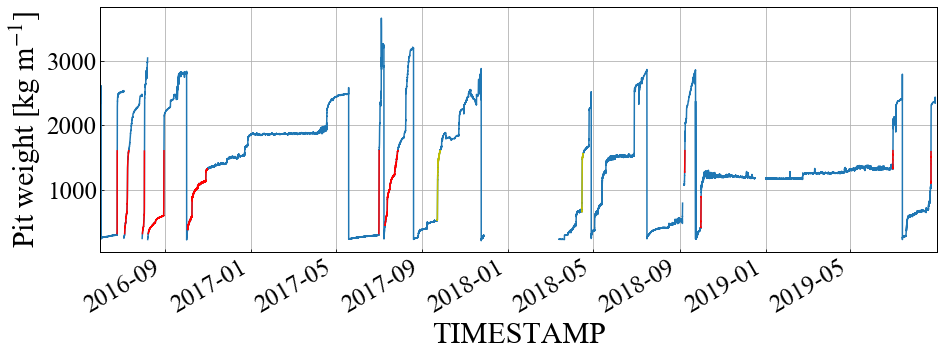

In [75]:
# trainのピット内増減を表示
colname = 'Load_Avg'
plt.figure(figsize=(15,5))
df_all_diff[colname].plot()
plt.ylabel('Pit weight [kg m$^{-1}$]')
plt.xlabel('')
for df_train in list_df_train:
    df_train[colname].plot(c='r')
for df_test in list_df_test:
    df_test[colname].plot(c='y')

plt.show()

ここで，各イベントの詳細が見れるようにする．  
以下のコードで，colnameに見たいデータ，eventnoにイベントナンバー(0から順に)を入力するとグラフが切り替わる

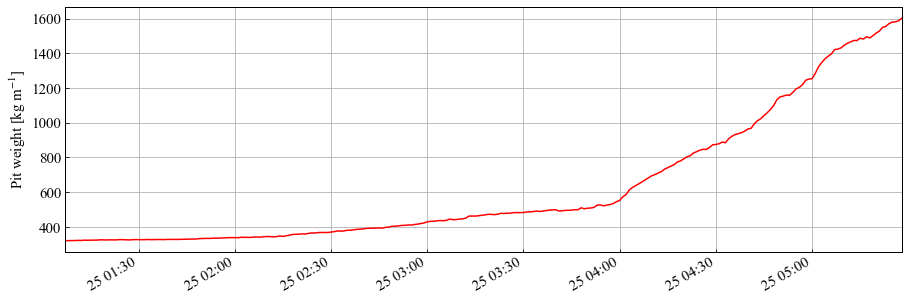

In [140]:
# trainのピット内増減を表示
#(Load_Avgを変えるとピット増減以外も見れる)
#####################
colname = 'Load_Avg'
eventno = 0
#####################

plt.figure(figsize=(15,5))
list_df_train[eventno][colname].plot(c='r')
plt.ylabel('Pit weight [kg m$^{-1}$]')
plt.xlabel('')

plt.show()

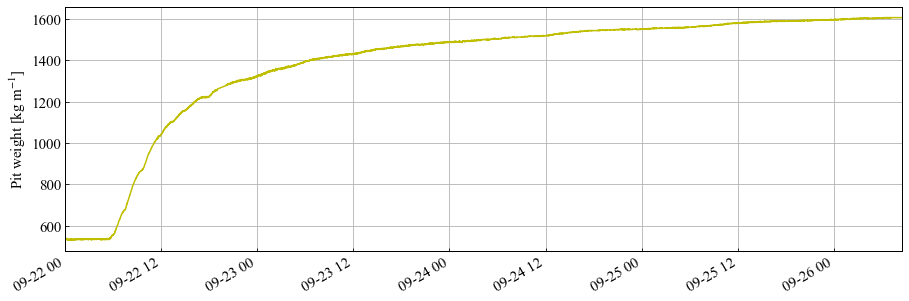

In [142]:
# testのピット内増減を表示
#(Load_Avgを変えるとピット増減以外も見れる)
#####################
colname = 'Load_Avg'
eventno = 0
#####################

plt.figure(figsize=(15,5))
list_df_test[eventno][colname].plot(c='y')
plt.ylabel('Pit weight [kg m$^{-1}$]')
plt.xlabel('')

plt.show()

# 30分毎に平均をとる

データのばらつきを少なくするため，30分毎に平均をとった．（単純にデータ数は1/30になる）  
meantimeの数字を変えれば平均時間を変えれる

In [78]:
def mean_of_df(df, meantime=30):
    """
    dfを30分間隔平均にする。
    'Load_Avg'は平均間隔にするとおかしくなるのでしない
    他にも平均にするとおかしいデータがあるはず？
    少なくともハイドロフォンデータは大丈夫だからそのまま行きます
    """
    sum_interval = meantime
    df_mean = df.resample('{}T'.format(sum_interval)).sum() / sum_interval
    df_mean['Load_Avg'] = df['Load_Avg']
#     df_mean['Load_Avg_difference'] = df['Load_Avg_difference'].resample(
#         '{}T'.format(sum_interval)).sum() / sum_interval
    
    return df_mean

mean_of_dfで抽出した訓練データとテストデータを30分平均にする

In [79]:
#30分平均したデータをリストに格納
list_df_train_mean = []
list_df_test_mean = []
for df_train in list_df_train:
    list_df_train_mean.append(mean_of_df(df_train, meantime=meantime))
for df_test in list_df_test:
    list_df_test_mean.append(mean_of_df(df_test, meantime=meantime))

ここで，30分毎の平均したデータを見てみると，データ数が単純に1/30になったため，イベントによってはデータ数が3つしかないようなときもあり，グラフがカクカクすることが確認できる．

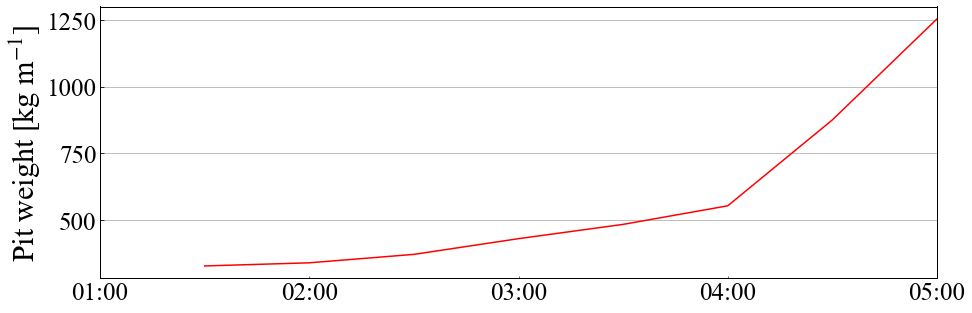

In [80]:
# trainのピット内増減を表示
#(Load_Avgを変えるとピット増減以外も見れる)
#####################
colname = 'Load_Avg'
eventno = 0
#####################

plt.figure(figsize=(15,5))
list_df_train_mean[eventno][colname].plot(c='r')
plt.ylabel('Pit weight [kg m$^{-1}$]')
plt.xlabel('')

plt.show()

# データ選択

ここで，ピット直上にあるハイドロフォンデータの名前は，names_of_centerに入っている．  
その上の5本のハイドロフォンデータの名前は，names_of_C,names_of_RC,names_of_R,names_of_L,names_of_LCに入っている．


In [81]:
print('例：ピット直上ハイドロフォン', names_of_center)
print('例：5本の中央ハイドロフォン', names_of_C)

例：ピット直上ハイドロフォン ['hp_Tot(1)', 'hp_Tot(2)', 'hp_Tot(3)', 'hp_Tot(4)', 'hp_Tot(5)', 'hp_Tot(6)', 'hp_Tot(7)', 'hp_Tot(8)', 'hp_Tot(9)', 'hp_Tot(10)']
例：5本の中央ハイドロフォン ['C_Tot(1)', 'C_Tot(2)', 'C_Tot(3)', 'C_Tot(4)', 'C_Tot(5)', 'C_Tot(6)', 'C_Tot(7)', 'C_Tot(8)', 'C_Tot(9)', 'C_Tot(10)']


'hp_Tot(1)'：1024倍-512倍,'hp_Tot(2)'：312倍-256倍, 'hp_Tot(3)'：256-128, 'hp_Tot(4)'：128-64, 'hp_Tot(5)'：64-32, 'hp_Tot(6)'：32-16, 'hp_Tot(7)'：16-8, 'hp_Tot(8)'：8-4, 'hp_Tot(9)'：4-2, 'hp_Tot(10)'：2倍

今回，中央ハイドロフォンデータとピットデータを使って，修論3章におけるC,βを算出するので，names_of_centerのデータ，ピットデータ，水深データのみを使う

In [82]:
coluses = names_of_center + ['Load_Avg', 'Load_Avg_difference', 'WL_FMR_Avg']
print('今回使うデータ', coluses)

今回使うデータ ['hp_Tot(1)', 'hp_Tot(2)', 'hp_Tot(3)', 'hp_Tot(4)', 'hp_Tot(5)', 'hp_Tot(6)', 'hp_Tot(7)', 'hp_Tot(8)', 'hp_Tot(9)', 'hp_Tot(10)', 'Load_Avg', 'Load_Avg_difference', 'WL_FMR_Avg']


ただし，今回は修論で言うところのf(Nr)=1とするため，飽和する増幅率を使わなかった．以下に，縦軸にハイドロフォンデータ，横軸にピットデータをとった散布図を示します．  

改めて，このグラフにおけるcolnameの対応は，  
'hp_Tot(1)'：1024倍-512倍,'hp_Tot(2)'：312倍-256倍, 'hp_Tot(3)'：256-128, 'hp_Tot(4)'：128-64, 'hp_Tot(5)'：64-32, 'hp_Tot(6)'：32-16, 'hp_Tot(7)'：16-8, 'hp_Tot(8)'：8-4, 'hp_Tot(9)'：4-2, 'hp_Tot(10)'：2倍  
です

In [83]:
#下のグラフのために一旦list_df_train_meanとlist_df_test_meanを繋げる
df_train_mean = pd.concat(list_df_train_mean)
df_test_mean = pd.concat(list_df_test_mean)
df_events_mean = pd.concat([df_train_mean, df_test_mean])

In [84]:
list_df_test_mean

[                     C_Tot(1)  LC_Tot(1)  L_Tot(1)  Plate_Tot(1)  RC_Tot(1)  \
 TIMESTAMP                                                                     
 2017-09-22 00:00:00       0.0        0.0       0.0           0.0        0.0   
 2017-09-22 00:30:00       0.0        0.0       0.0           0.0        0.0   
 2017-09-22 01:00:00       0.0        0.0       0.0           0.0        0.0   
 2017-09-22 01:30:00       0.0        0.0       0.0           0.0        0.0   
 2017-09-22 02:00:00       0.0        0.0       0.0           0.0        0.0   
 ...                       ...        ...       ...           ...        ...   
 2017-09-26 06:00:00       0.0        0.0       0.0           0.0        0.0   
 2017-09-26 06:30:00       0.0        0.0       0.0           0.0        0.0   
 2017-09-26 07:00:00       0.0        0.0       0.0           0.0        0.0   
 2017-09-26 07:30:00       0.0        0.0       0.0           0.0        0.0   
 2017-09-26 08:00:00       0.0        0.

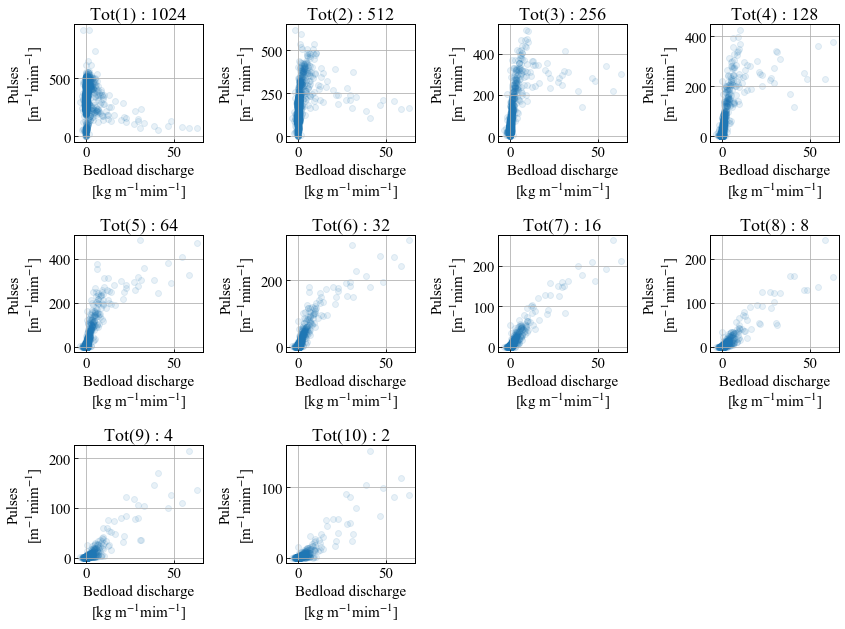

In [85]:
plt.rcParams["font.size"] = 15  # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.labelsize'] = 15  # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 15  # 軸だけ変更されます

dispgraphs.scatter_graphs(df_events_mean, list_y_names=names_of_center, list_x_names=['Load_Avg_difference']*10,
                             ylabel = 'Pulses\n[m$^{-1}$mim$^{-1}$]', xlabel='Bedload discharge\n[kg m$^{-1}$mim$^{-1}$]',
                             figsize=(3*4, 3*3), alpha=0.1, linear_regression=False)

1024-512倍，512-256倍，256-128倍，128-64倍では，流砂量(横軸)が0の時もパルス数がとれている  
（流砂量0の時のデータをヒストグラムで見ると分かる）  
→ノイズが入ってしまっている  

また，1024-512倍，512-256倍，256-128倍，128-64倍ではパルスの飽和が確認される  
→64以下ではパルスの飽和が起きないとし（64-32倍は少し見られるがスルー），f(Nr)=1とする

これらの理由から，今回は64-32倍，32-16倍，16-8倍，8-4倍，4-2倍，2倍だけを使う.  
ノイズをどうにか処理できたり，f(Nr)の関数をそれぞれの粒径界で設定できれば，1024倍，512倍，256倍，128倍も使えると考えられる

In [86]:
use_tots = names_of_center[4:]
coluses = use_tots + ['Load_Avg', 'Load_Avg_difference', 'WL_FMR_Avg']
print(coluses)

#使うtotの数に合わせてW_IDEALも選択
W_IDEAL_use = W_IDEAL[-len(use_tots):]
print(W_IDEAL_use)

['hp_Tot(5)', 'hp_Tot(6)', 'hp_Tot(7)', 'hp_Tot(8)', 'hp_Tot(9)', 'hp_Tot(10)', 'Load_Avg', 'Load_Avg_difference', 'WL_FMR_Avg']
[0.00091 0.00196 0.00301 0.00691 0.01081 0.05   ]


・ピット流砂量が0以下は，原理上あり得ないが，ピットから流砂が何らかの影響で流れ出てしまうことがある  
　（流木が刺さったりして2次元流が卓越する等）．  
・水深2cm以下はエラー
・水深30cm以上はエラー？？（ここは経験則）  
・全てのデータが揃っていないと本手法を使えないので揃っていない部分があれば削除

これらのデータはエラーとみなし，除外する  
その後，df_train_mean, testに入っているデータをハイドロフォンデータ（df_optimize）と水深データ（WL_FMR_Avg），ピット流砂量（qobs）に分ける

In [87]:
def pit_positive(df):
    '''
    df has to have Load_Avg_difference column
    '''
    return df[df['Load_Avg_difference']>=0]

def waterlevel_clean(df, min_wl=2, max_wl=30):
    '''
    df has to have WL_FMR_Avg column.
    '''
    df = df[df['WL_FMR_Avg']>min_wl]
    df = df[df['WL_FMR_Avg']<max_wl]
    return df

def organize_dfs(df):
    df = pit_positive(df)
    df = waterlevel_clean(df)
    #NANが一つでもあれば削除
    df = df.dropna(how='all')
    return df


上のセルで作成した関数organize_dfsを使ってデータ整理

In [88]:
df_train_mean = organize_dfs(df_train_mean)
df_test_mean = organize_dfs(df_test_mean)

ここで，df_train_positiveに入っているデータをハイドロフォンデータ（df_optimize）と水深データ（WL_FMR_Avg），ピット流砂量（qobs）に分ける

In [89]:
def splitdf_dfoptimize_wl_qobs(df, use_tots):
    '''
    df has to have only use_tots, WL_FMR_Avg, Load_Avg_difference columns
    '''
    df_optimize = df[use_tots]
    waterlevel = df['WL_FMR_Avg']
    qobs = df['Load_Avg_difference']
    return df_optimize, waterlevel, qobs

In [90]:
#trainデータ
df_optimize_train, waterleve_train, qobs_train = splitdf_dfoptimize_wl_qobs(df_train_mean, use_tots=use_tots)
#testデータ
df_optimize_test, waterleve_test, qobs_test = splitdf_dfoptimize_wl_qobs(df_test_mean, use_tots=use_tots)

# alphaをふるい結果から決める

ここで，ふるい結果をインポートする．  
下のデータフレームは、ピット内のふるい結果である。上から、表面から-30cm、-45cm、-60cmの位置の土砂である。

In [91]:
df_furui = getdfs.get_furui()
x_furui = [1, 2, 5, 7, 9, 15, 31.5, 50] #furui粒径界の上限
x_tot = [2, 5, 6, 7, 8.5, 10, 12.5, 15, 20, 30, 50] #Tot粒径界の上限
g_furui = ['-1mm(g)', '1-2mm(g)', '2-5mm(g)', '5-7mm(g)', '7-9mm(g)', '9-15mm(g)', '19-31.5mm(g)', '31.5mm-(g)'] #furui粒径界(g)
percent_furui = ['-1mm(%)', '1-2mm(%)', '2-5mm(%)', '5-7mm(%)', '7-9mm(%)', '9-15mm(%)', '19-31.5mm(%)', '31.5mm-(%)'] #furui粒径界(%)
df_furui

,31.5mm-(g),19-31.5mm(g),9-15mm(g),7-9mm(g),5-7mm(g),2-5mm(g),1-2mm(g),-1mm(g),31.5mm-(%),19-31.5mm(%),9-15mm(%),7-9mm(%),5-7mm(%),2-5mm(%),1-2mm(%),-1mm(%),starttime,endtime
TIMESTAMP,,,,,,,,,,,,,,,,,,
2017-11-23,134,507,1120,804,1557,2718,2163,3079,1.109088,4.196325,9.269988,6.654527,12.886939,22.496275,17.902665,25.484191,2017/9/21 0:00,2017/9/23 0:00
2017-11-23,0,61,423,439,1671,4498,3408,2147,0.000000,0.482328,3.344667,3.471179,13.212620,35.565747,26.947102,16.976358,2017/9/21 0:00,2017/9/23 0:00
2017-11-23,0,81,697,1091,2481,4775,2073,1296,0.000000,0.648311,5.578678,8.732191,19.857532,38.218345,16.591964,10.372979,2017/9/21 0:00,2017/9/23 0:00
2018-04-28,1172,1713,1690,787,1046,2125,2447,3634,8.019707,11.721637,11.564253,5.385247,7.157520,14.540851,16.744218,24.866566,2018/4/15 0:00,2018/4/28 0:00
2018-04-28,901,1223,1678,747,1226,2395,2619,3697,6.219798,8.442634,11.583598,5.156703,8.463344,16.533204,18.079525,25.521193,2018/4/15 0:00,2018/4/28 0:00
2018-04-28,1267,1086,1981,823,1174,2340,2386,3213,8.878767,7.610371,13.882270,5.767344,8.227050,16.398038,16.720392,22.515767,2018/4/15 0:00,2018/4/28 0:00
2018-07-16,387,551,975,372,530,1269,2048,3800,3.896496,5.547725,9.816754,3.745469,5.336287,12.776883,20.620217,38.260169,2018/5/1 0:00,2018/5/20 0:00
2018-07-16,458,678,1240,417,560,974,1211,2502,5.696517,8.432836,15.422886,5.186567,6.965174,12.114428,15.062189,31.119403,2018/5/1 0:00,2018/5/20 0:00
2018-07-16,866,854,814,409,591,1249,1491,2556,9.807475,9.671574,9.218573,4.631937,6.693092,14.144960,16.885617,28.946772,2018/5/1 0:00,2018/5/20 0:00


左図：ピットふるい3日分×3つの位置(-30cm、-45cm、-60cm)＝9データをプロット。粒度分布百分率  
右図：ピットの下の方と上の方はあまり1イベントを表しているとは言い難い(底には細かいのが多く、上の方は細かいのが流れて大きな流砂が多いなど)ため、真ん中(-45cm)のデータのみを抽出

0mmと50mmの間の割合(100になるはず)： 1.00000000001
100%のときの粒径(50になるはず)： [49.9]


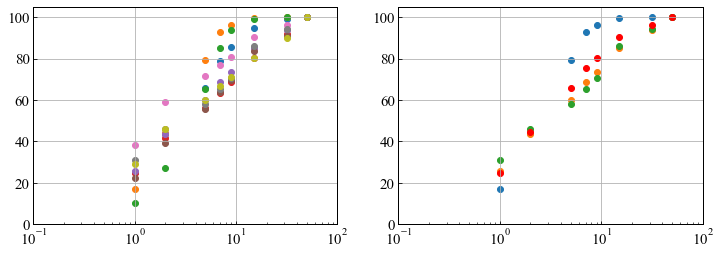

In [92]:
###すべてグラフ出力######

fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1) 

for i in range(9):
    furui_percent_cumsum = np.cumsum(df_furui[i:i+1][percent_furui], axis=1)
    ax1.scatter(x_furui, furui_percent_cumsum)
    ax1.set_xscale('log')
    ax1.set_ylim(0,105)
    ax1.set_xlim((0.1), 100)
#########################

###３つの平均を算出######
furui_percents = [0]*len(percent_furui)
for i in range(1, 9, 3):
    furui_percents = furui_percents + np.array(df_furui[i:i+1][percent_furui])
furui_percent_cumsums = np.cumsum(furui_percents, axis=1).flatten()
furui_percent_cumsum_mean =  furui_percent_cumsums/3
#########################

###真ん中のデータのみグラフ出力######
ax2 = plt.subplot(1,2,2) 
for i in range(1, 9, 3):
    furui_percent_cumsum = np.cumsum(df_furui[i:i+1][percent_furui], axis=1)
    ax2.scatter(x_furui, furui_percent_cumsum)
    ax2.set_xscale('log')
    ax2.set_ylim(0,105)
    ax2.set_xlim((0.1), 100)

# ３つの平均をグラフ出力(赤)##
ax2.scatter(x_furui, furui_percent_cumsum_mean, c="red")
#########################

#直線近似
# y=mx+n
# ２点を通る方程式を返却
# (y=数値) or (x=数値) or (y=mx+n)
def makeLinearEquation(x1, y1, x2, y2):
    line = {}
    if y1 == y2:
        # y軸に平行な直線
        line["y"] = y1
    elif x1 == x2:
        # x軸に平行な直線
        line["x"] = x1
    else:
        # y = mx + n
        line["m"] = (y1 - y2) / (x1 - x2)
        line["n"] = y1 - (line["m"] * x1)
#     print(line)
    return line

def calc_y(line, dia):
#     print("y=mx+n : ",line)
    if 'y' in line:
        percent = line["y"]
    elif 'x' in line:
        print('Error, x is something wrong')
    else:
        percent = line["m"]*dia + line["n"]
#     print("pecent : ", percent)
    return percent
    

x_mean = np.insert(x_furui, 0, 0)
y_mean = np.insert(furui_percent_cumsum_mean, 0, 0)

def calcPercent(dia, x, y):
    """
    粒径から通過百分率のパーセントを算出する
    各プロット毎に直線近似
    """
    if (dia >= x[0]) & (dia < x[1]):
        line = makeLinearEquation(x[0], y[0], x[1], y[1])
        percent = calc_y(line, dia)

    elif (dia >= x[1]) & (dia < x[2]):
        line = makeLinearEquation(x[1], y[1], x[2], y[2])
        percent = calc_y(line, dia)

    elif (dia >= x[2]) & (dia < x[3]):
        line = makeLinearEquation(x[2], y[2], x[3], y[3])
        percent = calc_y(line, dia)

    elif (dia >= x[3]) & (dia < x[4]):
        line = makeLinearEquation(x[3], y[3], x[4], y[4])
        percent = calc_y(line, dia)

    elif (dia >= x[4]) & (dia < x[5]):
        line = makeLinearEquation(x[4], y[4], x[5], y[5])
        percent = calc_y(line, dia)

    elif (dia >= x[5]) & (dia < x[6]):
        line = makeLinearEquation(x[5], y[5], x[6], y[6])
        percent = calc_y(line, dia)

    elif (dia >= x[6]) & (dia < x[7]):
        line = makeLinearEquation(x[6], y[6], x[7], y[7])
        percent = calc_y(line, dia)

    elif (dia >= x[7]) & (dia <= x[8]):
        line = makeLinearEquation(x[7], y[7], x[8], y[8])
        percent = calc_y(line, dia)
        
    else:
        print("Diameter is out of range")
        
    return percent

def calc_dia_rate(max_dia, min_dia, x, y):
    rate = calcPercent(max_dia, x, y) - calcPercent(min_dia, x, y)
    return rate/100

def calc_dia_from_percent(percent, x, y):
    try_dia = np.arange(0, 50, 0.1)
    
    dia_hold = []
    for dia in try_dia:
        dia_hold.append(calcPercent(dia, x, y))
    dia_hold = np.array(dia_hold)
    dia_hold = np.abs(dia_hold-percent)
    key = np.where(dia_hold == np.min(dia_hold))
    dia = try_dia[key]
    
    return dia


print("0mmと50mmの間の割合(100になるはず)：",calc_dia_rate(50, 0, x_mean, y_mean))
print("100%のときの粒径(50になるはず)：", calc_dia_from_percent(100, x_mean, y_mean))

8,5mm以上（50mmを上限としてる）の流砂量の割合alphaは

In [93]:
alpha = calc_dia_rate(50, 8.5, x_mean, y_mean)
print('alpha : ', alpha)

alpha :  0.21026292094333315


# 最小化問題を解く

まずは初期条件

In [94]:
#f(Nr)は1としているため
f_n = 1
# alphaの値は上で決めてる
# alpha=0.3
#粒径を算出 
D_IDEALm = 2*((W_IDEAL/2650)*(3/4)*(1/math.pi))**(1/3)
D_IDEALm_use = 2*((W_IDEAL_use/2650)*(3/4)*(1/math.pi))**(1/3)
D_IDEALcm_use = D_IDEALm_use*100

In [95]:
D_IDEALcm_use

array([0.86882498, 1.12202842, 1.29451573, 1.70769845, 1.98241115,
       3.30299946])

次に，γnをsklardietrichの式からサルテーション高さから算出（詳細は修論）  
コードは，sklardietrich.pyに入ってます．

In [96]:
#calc gamma by sklardietrich
#sklardietrichからgammaを計算。あとで使用
def calc_gamma(list_h_s, bump_hp_m):
    list_gamma = []
    for h_s in list_h_s:
        #データがエラー値なら1
        if np.isnan(h_s):
            gamma = 1
            list_gamma.append(gamma)
            
        #ハイドロフォン高さ以下なら1
        elif h_s <= bump_hp_m:
            gamma = 1
            list_gamma.append(gamma)
            
        #ハイドロフォン高さ以上なら割り算
        else:
            gamma = bump_hp_m/h_s
            list_gamma.append(gamma)

    return list_gamma 

def calc_gammas(series_wl):
    '''
    calc_gammaを使って，全ての粒径界，水深データに対してgammaを算出する
    sklardietrichは全てcm, gで計算しているためそれに合わせている．
    '''
    #gammaは無次元
    list2d_gamma = []
    bump_hp_m = 0.025 * 100 #cm
    width = 500#cm

    for wl in series_wl:
        #wl is in cm
        #径深Rを算出
        R = sklardietrich.calc_R(wl, width)
        #h_s is in cm
        list_h_s = [sklardietrich.calc_h_s(R=R, d=D_IDEALcm_use[i]) for i in range(len(D_IDEALcm_use))]

        #gammaを計算
        list_gamma = calc_gamma(list_h_s, bump_hp_m)
        list2d_gamma.append(list_gamma)

    return list2d_gamma
        

In [97]:
# 訓練データにおける全γを全て算出
gammas = calc_gammas(series_wl=waterleve_train)

C:\Users\user\OneDrive - Kyoto University\shared-Yutaka\Research\Hydrophone_Higashi_MastersThesis\my_module\sklardietrich.py:135: RuntimeWarning: invalid value encountered in double_scalars
  h_s = (1.44*((tau_star/tau_star_c)-1)**0.5)*d


ここで，Cとβnを設定していなときの理想的な粒径別流砂量を算出し，dfに保存

In [98]:
df_qcalc_train_nocorrected = (df_optimize_train.mul(W_IDEAL_use.reshape(1,len(W_IDEAL_use))) / np.array(gammas))

以下のセルでコスト関数を算出する関数を作成

In [99]:
evaluate = 'MAE'

def func(Const):
    '''
    ここに最小化するコスト関数を設定する。
    コスト関数をreturnで返す
    Const[:-1]: beta
    Const[-1] : C 
    '''
    df_w = df_qcalc_train_nocorrected.mul(Const[:-1])
    df_w_sum = df_w.sum(axis=1)
    df_qcalc = df_w_sum * (Const[-1]/(f_n*alpha))
    # cost = np.square(df_qcalc-df_qobs)
    # Cost = cost.sum()

    if evaluate == "MAE":
        cost = mean_absolute_error(qobs_train, df_qcalc)

    elif evaluate =='RMSE':
        cost = np.sqrt(mean_squared_error(qobs_train, df_qcalc))

    else:
        logger.exception("Evaluate func doesn't match with our choices ")

    return cost

ここでは制約条件を作成  
制約条件の書き方は，pythonのライブラリminimizeについて調べないとよくわからないかも

動的に制約条件を作ってもなぜかエラーが出るので，わざわざ場合分けしています．なのでコードが必要以上に長いです．

In [100]:
# βの制約条件
error_less = 0.5
error_more = 1.5

#今回はこれ
#チャンネル数増やすならそれ用に作らないといけない
if len(use_tots)==6:
    
    cons = (
        {'type': 'ineq', 'fun': lambda Const: Const[0]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[0]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[1]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[1]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[2]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[2]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[3]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[3]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[4]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[4]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[5]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[5]+error_more},

        {'type': 'ineq', 'fun': lambda Const:  Const[6]},
        # {'type': 'ineq', 'fun': lambda Const:  1-Const[6]},

        {'type': 'ineq', 'fun': lambda Const: Const[1]*W_IDEAL[1] - Const[0]*W_IDEAL[0]},
        {'type': 'ineq', 'fun': lambda Const: Const[2]*W_IDEAL[2] - Const[1]*W_IDEAL[1]},
        {'type': 'ineq', 'fun': lambda Const: Const[3]*W_IDEAL[3] - Const[2]*W_IDEAL[2]},
        {'type': 'ineq', 'fun': lambda Const: Const[4]*W_IDEAL[4] - Const[3]*W_IDEAL[3]},
        {'type': 'ineq', 'fun': lambda Const: Const[5]*W_IDEAL[5] - Const[4]*W_IDEAL[4]},
        )

#その他の時
if len(use_tots)==7:
    
    cons = (
        {'type': 'ineq', 'fun': lambda Const: Const[0]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[0]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[1]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[1]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[2]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[2]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[3]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[3]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[4]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[4]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[5]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[5]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[6]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[6]+error_more},
        
        {'type': 'ineq', 'fun': lambda Const:  Const[7]},
        # {'type': 'ineq', 'fun': lambda Const:  1-Const[6]},

        {'type': 'ineq', 'fun': lambda Const: Const[1]*W_IDEAL[1] - Const[0]*W_IDEAL[0]},
        {'type': 'ineq', 'fun': lambda Const: Const[2]*W_IDEAL[2] - Const[1]*W_IDEAL[1]},
        {'type': 'ineq', 'fun': lambda Const: Const[3]*W_IDEAL[3] - Const[2]*W_IDEAL[2]},
        {'type': 'ineq', 'fun': lambda Const: Const[4]*W_IDEAL[4] - Const[3]*W_IDEAL[3]},
        {'type': 'ineq', 'fun': lambda Const: Const[5]*W_IDEAL[5] - Const[4]*W_IDEAL[4]},
        {'type': 'ineq', 'fun': lambda Const: Const[6]*W_IDEAL[6] - Const[5]*W_IDEAL[5]},
        )
if len(use_tots)==8:
    cons = (
        {'type': 'ineq', 'fun': lambda Const: Const[0]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[0]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[1]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[1]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[2]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[2]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[3]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[3]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[4]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[4]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[5]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[5]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[6]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[6]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[7]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[7]+error_more},
        
        {'type': 'ineq', 'fun': lambda Const:  Const[8]},
        # {'type': 'ineq', 'fun': lambda Const:  1-Const[6]},

        {'type': 'ineq', 'fun': lambda Const: Const[1]*W_IDEAL[1] - Const[0]*W_IDEAL[0]},
        {'type': 'ineq', 'fun': lambda Const: Const[2]*W_IDEAL[2] - Const[1]*W_IDEAL[1]},
        {'type': 'ineq', 'fun': lambda Const: Const[3]*W_IDEAL[3] - Const[2]*W_IDEAL[2]},
        {'type': 'ineq', 'fun': lambda Const: Const[4]*W_IDEAL[4] - Const[3]*W_IDEAL[3]},
        {'type': 'ineq', 'fun': lambda Const: Const[5]*W_IDEAL[5] - Const[4]*W_IDEAL[4]},
        {'type': 'ineq', 'fun': lambda Const: Const[6]*W_IDEAL[6] - Const[5]*W_IDEAL[5]},
        {'type': 'ineq', 'fun': lambda Const: Const[7]*W_IDEAL[7] - Const[6]*W_IDEAL[6]},

        )
if len(use_tots)==9:
    cons = (
        {'type': 'ineq', 'fun': lambda Const: Const[0]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[0]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[1]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[1]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[2]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[2]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[3]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[3]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[4]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[4]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[5]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[5]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[6]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[6]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[7]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[7]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[8]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[8]+error_more},
        
        {'type': 'ineq', 'fun': lambda Const:  Const[9]},
        # {'type': 'ineq', 'fun': lambda Const:  1-Const[6]},

        {'type': 'ineq', 'fun': lambda Const: Const[1]*W_IDEAL[1] - Const[0]*W_IDEAL[0]},
        {'type': 'ineq', 'fun': lambda Const: Const[2]*W_IDEAL[2] - Const[1]*W_IDEAL[1]},
        {'type': 'ineq', 'fun': lambda Const: Const[3]*W_IDEAL[3] - Const[2]*W_IDEAL[2]},
        {'type': 'ineq', 'fun': lambda Const: Const[4]*W_IDEAL[4] - Const[3]*W_IDEAL[3]},
        {'type': 'ineq', 'fun': lambda Const: Const[5]*W_IDEAL[5] - Const[4]*W_IDEAL[4]},
        {'type': 'ineq', 'fun': lambda Const: Const[6]*W_IDEAL[6] - Const[5]*W_IDEAL[5]},
        {'type': 'ineq', 'fun': lambda Const: Const[7]*W_IDEAL[7] - Const[6]*W_IDEAL[6]},
        {'type': 'ineq', 'fun': lambda Const: Const[8]*W_IDEAL[8] - Const[7]*W_IDEAL[7]},
        )  
if len(use_tots)==10:
    cons = (
        {'type': 'ineq', 'fun': lambda Const: Const[0]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[0]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[1]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[1]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[2]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[2]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[3]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[3]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[4]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[4]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[5]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[5]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[6]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[6]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[7]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[7]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[8]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[8]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[9]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[9]+error_more},
        
        {'type': 'ineq', 'fun': lambda Const:  Const[10]},
        # {'type': 'ineq', 'fun': lambda Const:  1-Const[6]},

        {'type': 'ineq', 'fun': lambda Const: Const[1]*W_IDEAL[1] - Const[0]*W_IDEAL[0]},
        {'type': 'ineq', 'fun': lambda Const: Const[2]*W_IDEAL[2] - Const[1]*W_IDEAL[1]},
        {'type': 'ineq', 'fun': lambda Const: Const[3]*W_IDEAL[3] - Const[2]*W_IDEAL[2]},
        {'type': 'ineq', 'fun': lambda Const: Const[4]*W_IDEAL[4] - Const[3]*W_IDEAL[3]},
        {'type': 'ineq', 'fun': lambda Const: Const[5]*W_IDEAL[5] - Const[4]*W_IDEAL[4]},
        {'type': 'ineq', 'fun': lambda Const: Const[6]*W_IDEAL[6] - Const[5]*W_IDEAL[5]},
        {'type': 'ineq', 'fun': lambda Const: Const[7]*W_IDEAL[7] - Const[6]*W_IDEAL[6]},
        {'type': 'ineq', 'fun': lambda Const: Const[8]*W_IDEAL[8] - Const[7]*W_IDEAL[7]},
        {'type': 'ineq', 'fun': lambda Const: Const[9]*W_IDEAL[9] - Const[8]*W_IDEAL[8]},

        )    
if len(use_tots)==5:
        cons = (
        {'type': 'ineq', 'fun': lambda Const: Const[0]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[0]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[1]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[1]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[2]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[2]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[3]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[3]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[4]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[4]+error_more},


        {'type': 'ineq', 'fun': lambda Const:  Const[5]},
        # {'type': 'ineq', 'fun': lambda Const:  1-Const[6]},

        {'type': 'ineq', 'fun': lambda Const: Const[1]*W_IDEAL[1] - Const[0]*W_IDEAL[0]},
        {'type': 'ineq', 'fun': lambda Const: Const[2]*W_IDEAL[2] - Const[1]*W_IDEAL[1]},
        {'type': 'ineq', 'fun': lambda Const: Const[3]*W_IDEAL[3] - Const[2]*W_IDEAL[2]},
        {'type': 'ineq', 'fun': lambda Const: Const[4]*W_IDEAL[4] - Const[3]*W_IDEAL[3]},
        )
if len(use_tots)==4:
        cons = (
        {'type': 'ineq', 'fun': lambda Const: Const[0]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[0]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[1]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[1]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[2]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[2]+error_more},
        {'type': 'ineq', 'fun': lambda Const: Const[3]-error_less},
        {'type': 'ineq', 'fun': lambda Const: -Const[3]+error_more},

        {'type': 'ineq', 'fun': lambda Const:  Const[4]},
        # {'type': 'ineq', 'fun': lambda Const:  1-Const[6]},

        {'type': 'ineq', 'fun': lambda Const: Const[1]*W_IDEAL[1] - Const[0]*W_IDEAL[0]},
        {'type': 'ineq', 'fun': lambda Const: Const[2]*W_IDEAL[2] - Const[1]*W_IDEAL[1]},
        {'type': 'ineq', 'fun': lambda Const: Const[3]*W_IDEAL[3] - Const[2]*W_IDEAL[2]},
        )

###############################################
#動的に制約条件を作成しようとして失敗したやつ．
#エラーは出ないが，なぜか制約条件通りにminmizeしない       
# cons_for_beta = []
# for i in range(len(use_tots)):
#     cons_for_beta.append({'type': 'ineq', 'fun': lambda Const: Const[i]-error_less})
#     cons_for_beta.append({'type': 'ineq', 'fun': lambda Const: -Const[i]+error_more})

# # Cの制約条件
# cons_for_c = [{'type': 'ineq', 'fun': lambda Const: Const[len(use_tots)]}]

# # 前のw*betaが次のw*betaを超えたらダメ
# cons_for_limit = []
# for i in range(len(use_tots)-1):
#     cons_for_limit.append({'type': 'ineq', 'fun': lambda Const: Const[i+1]*W_IDEAL_use[i+1] - Const[i]*W_IDEAL_use[i]})

# cons_all = cons_for_beta + cons_for_c + cons_for_limit
# # cons_all = []
# cons = tuple(cons_all)
# print(cons)

ここで，最小化問題を解くライブラリを使って関数を作る

In [101]:
def opt_func(func, cons):
    Const0 = np.append(np.random.rand(len(use_tots)), 2)# 初期値を設定．値は適当
    result = minimize(func, x0=Const0, constraints=cons, method="COBYLA", options={'maxiter':10000})
    return result

一回走らせてみる

In [102]:
opt_func(func, cons)

     fun: 0.21312081912105355
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 297
  status: 1
 success: True
       x: array([1.07611017, 0.92955566, 0.75574604, 0.89414069, 0.63867192,
       0.59309572, 1.11258436])

大体同じ傾向で数字が算出されるが，局所解に落ち着いてしまい，大局解が算出されないことがある．  
そこで，繰り返しopt_funcを走らせて，funが最小のものを使うことにする

In [103]:
def repeat_opt_func(func, repeat, cons):
    '''
    repeatの数だけopt_funcを繰り返す．一番fungが最小の物がbest_result
    '''

    temp = 1000000000 
    results = []
    for _ in range(repeat):
        result = opt_func(func, cons)
        
        if result.fun < temp:
            results.append(result)
            temp = result.fun
#             print('func : ', temp)
#             print('x : ', result.x)
    best_result = results[-1]
    
    return best_result, results


In [104]:
#大体おおよそ同じくらいの結果が毎回出るようになるはず．出ない場合はrepeatを1000とかに増やす
best_result, results = repeat_opt_func(func, repeat=100, cons=cons)
print(best_result)

     fun: 0.21174228555867353
   maxcv: -0.0
 message: 'Optimization terminated successfully.'
    nfev: 116
  status: 1
 success: True
       x: array([1.48121262, 1.01002884, 0.76750361, 0.50603537, 0.5       ,
       0.56874888, 1.21417108])


In [105]:
list_beta = best_result.x[:-1]
C = best_result.x[-1]
print('beta:', list_beta)
print('C:', C)

beta: [1.48121262 1.01002884 0.76750361 0.50603537 0.5        0.56874888]
C: 1.2141710788746767


# 粒径毎流砂量算出

対象期間全体における流砂量を算出する.df_all_diffに全部入っているのでそれをdf_train,testと同じように整理

In [106]:
#df_all_diffを使うデータだけに絞る
df_all_diff_use = df_all_diff[coluses]
#30分平均をとる
df_all_diff_use = mean_of_df(df_all_diff_use, meantime=meantime)

In [107]:
# 整理
df_all_diff_use = organize_dfs(df_all_diff_use)

#trainデータ
df_optimize_all, waterleve_all, qobs_all = splitdf_dfoptimize_wl_qobs(df_all_diff_use, use_tots=use_tots)

流砂量を算出する

In [108]:
def calc_q(df_optimize, waterlevel, list_beta, C, W_IDEAL_use, f_n, alpha):
    
    
    #計算しやすいよう変換
    array_beta = np.array(list_beta)
    #gammaを算出

    gammas = calc_gammas(series_wl=waterlevel)
    df_qcalc_each = (df_optimize.mul(W_IDEAL_use.reshape(1,len(W_IDEAL_use))).mul(array_beta.reshape(1,len(W_IDEAL_use)))) / np.array(gammas) 
    df_qcalc_each_sum = df_qcalc_each.sum(axis=1)
    df_qcalc = df_qcalc_each_sum * (C/(f_n*alpha))
    
    return df_qcalc, df_qcalc_each

ここで，全体の流砂量と粒径別流砂量を算出した．以下ではこの結果を用いて色々コードを書いていく

In [109]:
qcalc_all, df_qcalc_each_all = calc_q(df_optimize_all, waterleve_all, list_beta, C, W_IDEAL_use, f_n=f_n, alpha=alpha)

C:\Users\user\OneDrive - Kyoto University\shared-Yutaka\Research\Hydrophone_Higashi_MastersThesis\my_module\sklardietrich.py:135: RuntimeWarning: invalid value encountered in double_scalars
  h_s = (1.44*((tau_star/tau_star_c)-1)**0.5)*d


これで，対象期間の流砂量が算出された．

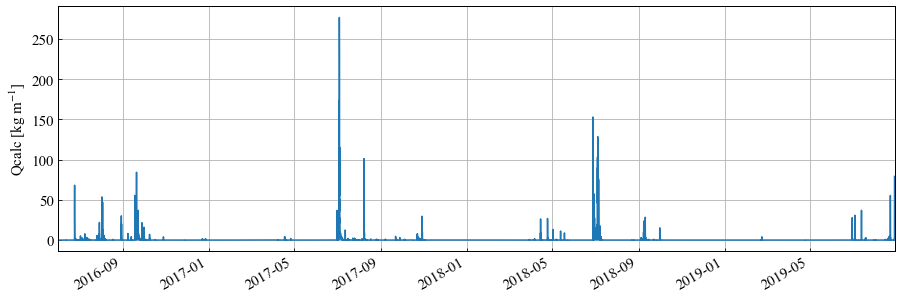

In [110]:
# trainのピット内増減を表示
colname = 'Load_Avg'
plt.figure(figsize=(15,5))
qcalc_all.plot()
plt.ylabel('Qcalc [kg m$^{-1}$]')
plt.xlabel('')

plt.show()

（訓練データのみ）縦軸に，算出流砂量，横軸にピット流砂量の散布図，決定係数もついでに算出

0.9344330882179295

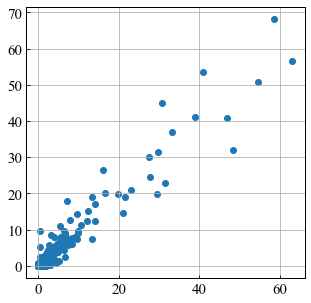

In [111]:
plt.figure(figsize=(5,5))
plt.scatter(qobs_train, qcalc_all[qobs_train.index])
from sklearn.metrics import r2_score
r2_score(qobs_train, qcalc_all[qobs_train.index]) 

In [112]:
def qcalc_sum_period(qcalc, start=None, end=None):
    '''
    start,endは指定なければqcalc全体の総量になる
    '''
    if start == None:
        start = qcalc.index[0]
    if end == None:
        end = qcalc.index[-1]
    #30分平均での/minなので，30倍する
    qcalc_sum = qcalc[start:end].sum()*30
    
    return qcalc_sum

def qcalc_each_sum_period(df_qcalc_each, start=None, end=None):
    '''
    start,endは指定なければqcalc全体の総量になる
    '''
    if start == None:
        start = df_qcalc_each.index[0]
    if end == None:
        end = df_qcalc_each.index[-1]
    #30分平均での/minなので，30倍する
    qcalc_sum_each = df_qcalc_each[start:end].sum()*30
    
    return qcalc_sum_each

 start,endは指定なければqcalc全体の総量になる．
 指定した区間の流砂量の総量を算出

In [113]:
def print_qcalc_each(qcalc_all, df_qcalc_each_all, start, end):
    qcalc_sum_all = qcalc_sum_period(qcalc_all, start=start, end=end)
    qcalc_sum_each_all = qcalc_each_sum_period(df_qcalc_each_all, start=start, end=end)
    print('流砂量({}~{})：'.format(start, end),qcalc_sum_all)
    TARGET_TOT_use = TARGET_TOT[-len(use_tots):]
    for i in range(len(TARGET_TOT_use)):
        print('粒径別{}'.format(TARGET_TOT_use[i]), qcalc_sum_each_all[i], 'kg')

In [114]:
#例えば，2017年の流砂量と粒径別流砂量
print_qcalc_each(qcalc_all, df_qcalc_each_all, start='2017-01-01 0:00', end='2017-12-31 23:59')
#例えば，2018年の流砂量と粒径別流砂量
print_qcalc_each(qcalc_all, df_qcalc_each_all, start='2018-01-01 0:00', end='2018-12-31 23:59')

流砂量(2017-01-01 0:00~2017-12-31 23:59)： 207127.14906950257
粒径別8.5-10mm 3678.003030292148 kg
粒径別10-12.5mm 2798.470945063309 kg
粒径別12.5-15mm 2349.780928286713 kg
粒径別15-20mm 3066.4224644726114 kg
粒径別20-30mm 5306.4624181477475 kg
粒径別30mm- 18669.9071114642 kg
流砂量(2018-01-01 0:00~2018-12-31 23:59)： 185612.38440516967
粒径別8.5-10mm 4425.077450824031 kg
粒径別10-12.5mm 3551.523772679959 kg
粒径別12.5-15mm 2518.114872710515 kg
粒径別15-20mm 2722.4427289547534 kg
粒径別20-30mm 4416.3056631302325 kg
粒径別30mm- 14509.783516305764 kg


# 精度検証

## 流砂量の比較

In [115]:
def score_r2(obs, calc):
    if (len(calc.index)>0) and (len(obs.index)>0):
        score = r2_score(obs, calc)
    
    return(score)

def compare_qcalc_qobs(qcalc_all, qobs, start, end, zoomout=True):
    '''
    この期間は，PitTrueの期間でないと意味ない
    zoomout:Trueのとき，qcalcとqobsが両方ある区間のみの比較
    '''
    qobs_all_selected = qobs[start:end]
    qcalc_selected = qcalc_all[start:end]

    if zoomout:
        qcalc_selected = qcalc_selected[qobs_all_selected.index]
        
    qobs_sum = qobs_all_selected.sum()
    qcalc_sum = qcalc_selected.sum()
    print('qobs : ', qobs_sum)
    print('qcalc : ', qcalc_sum)
    
    plt.figure(figsize=(15,5))
    ax = plt.subplot(1,1,1) 

    ax.plot(qcalc_selected, label='calc.')
    ax.plot(qobs_all_selected, label='obs.')
    ax.set_ylabel('Bedload discharge\n[kg m$^{-1}$ min$^{-1}$]')
    ax.set_xlabel('')
    ax.legend()
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=45)
#     plt.show()
    
    score = score_r2(qobs_all_selected, qcalc_selected)
    print('決定係数：', score) 

def compare_qcalc_qobs_add_each(qcalc_all, df_qcalc_each_all, qobs, start, end, zoomout=True):
    df_qcalc_each_all_selected = df_qcalc_each_all[start:end]
    qobs_all_selected = qobs[start:end]

    if zoomout:
        df_qcalc_each_all_selected = df_qcalc_each_all_selected[qobs_all_selected.index[0]:qobs_all_selected.index[-1]]
    compare_qcalc_qobs(qcalc_all, qobs, start, end, zoomout=zoomout)
    plt.plot(df_qcalc_each_all_selected)

試しに上のセルで作った関数を適応してみる．  
時間を変えると違う期間での比較もできる

qobs :  130.7075000000001
qcalc :  56.031397697714496
決定係数： 0.21057739942092513


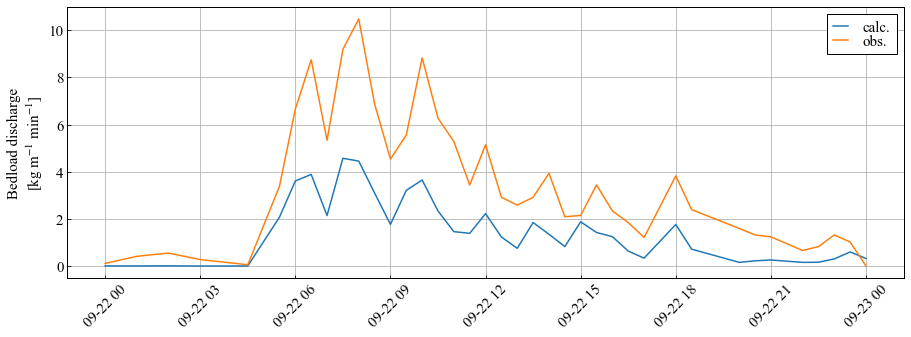

In [116]:
compare_qcalc_qobs(qcalc_all=qcalc_all, qobs=qobs_test, start='2017-09-21 00:00:00', end='2017-09-23 00:00:00')

qobs :  130.7075000000001
qcalc :  56.031397697714496
決定係数： 0.21057739942092513


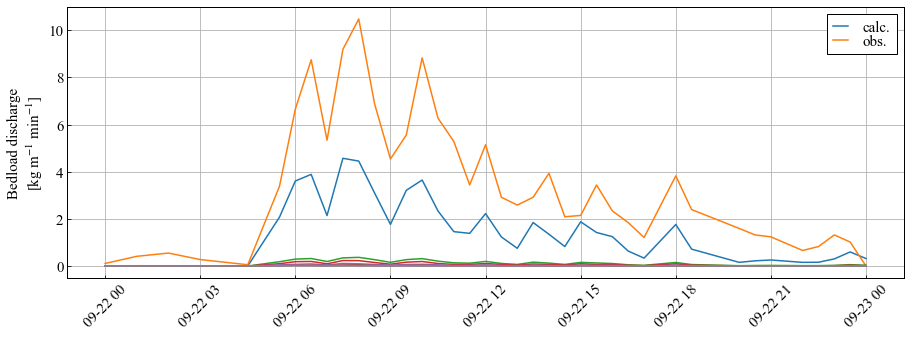

In [117]:
compare_qcalc_qobs_add_each(qcalc_all=qcalc_all, df_qcalc_each_all=df_qcalc_each_all, qobs=qobs_test, start='2017-09-21 00:00:00', end='2017-09-23 00:00:00')

qobs :  6.5353750000000055
qcalc :  11.781325344459004
決定係数： -1.1025456548253563


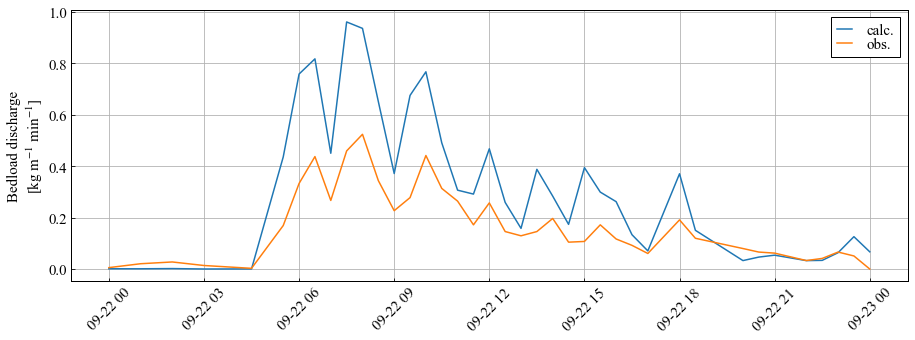

In [118]:
compare_qcalc_qobs(qcalc_all=qcalc_all*alpha, qobs=qobs_test*0.05, start='2017-09-21 00:00:00', end='2017-09-23 00:00:00')

## ピットとの粒度分布との比較

おさらいで，定義したふるいデータを見る．ふるい結果の番号は上から順に0（2017-11-23）,1（2018-04-28）,2（2018-07-16）

In [119]:
print('furui粒径界の上限', x_furui)
print('Tot粒径界の上限', x_tot)
print('furui粒径界(g)', g_furui)
print('furui粒径界(%)', percent_furui)

df_furui

furui粒径界の上限 [1, 2, 5, 7, 9, 15, 31.5, 50]
Tot粒径界の上限 [2, 5, 6, 7, 8.5, 10, 12.5, 15, 20, 30, 50]
furui粒径界(g) ['-1mm(g)', '1-2mm(g)', '2-5mm(g)', '5-7mm(g)', '7-9mm(g)', '9-15mm(g)', '19-31.5mm(g)', '31.5mm-(g)']
furui粒径界(%) ['-1mm(%)', '1-2mm(%)', '2-5mm(%)', '5-7mm(%)', '7-9mm(%)', '9-15mm(%)', '19-31.5mm(%)', '31.5mm-(%)']


,31.5mm-(g),19-31.5mm(g),9-15mm(g),7-9mm(g),5-7mm(g),2-5mm(g),1-2mm(g),-1mm(g),31.5mm-(%),19-31.5mm(%),9-15mm(%),7-9mm(%),5-7mm(%),2-5mm(%),1-2mm(%),-1mm(%),starttime,endtime
TIMESTAMP,,,,,,,,,,,,,,,,,,
2017-11-23,134,507,1120,804,1557,2718,2163,3079,1.109088,4.196325,9.269988,6.654527,12.886939,22.496275,17.902665,25.484191,2017/9/21 0:00,2017/9/23 0:00
2017-11-23,0,61,423,439,1671,4498,3408,2147,0.000000,0.482328,3.344667,3.471179,13.212620,35.565747,26.947102,16.976358,2017/9/21 0:00,2017/9/23 0:00
2017-11-23,0,81,697,1091,2481,4775,2073,1296,0.000000,0.648311,5.578678,8.732191,19.857532,38.218345,16.591964,10.372979,2017/9/21 0:00,2017/9/23 0:00
2018-04-28,1172,1713,1690,787,1046,2125,2447,3634,8.019707,11.721637,11.564253,5.385247,7.157520,14.540851,16.744218,24.866566,2018/4/15 0:00,2018/4/28 0:00
2018-04-28,901,1223,1678,747,1226,2395,2619,3697,6.219798,8.442634,11.583598,5.156703,8.463344,16.533204,18.079525,25.521193,2018/4/15 0:00,2018/4/28 0:00
2018-04-28,1267,1086,1981,823,1174,2340,2386,3213,8.878767,7.610371,13.882270,5.767344,8.227050,16.398038,16.720392,22.515767,2018/4/15 0:00,2018/4/28 0:00
2018-07-16,387,551,975,372,530,1269,2048,3800,3.896496,5.547725,9.816754,3.745469,5.336287,12.776883,20.620217,38.260169,2018/5/1 0:00,2018/5/20 0:00
2018-07-16,458,678,1240,417,560,974,1211,2502,5.696517,8.432836,15.422886,5.186567,6.965174,12.114428,15.062189,31.119403,2018/5/1 0:00,2018/5/20 0:00
2018-07-16,866,854,814,409,591,1249,1491,2556,9.807475,9.671574,9.218573,4.631937,6.693092,14.144960,16.885617,28.946772,2018/5/1 0:00,2018/5/20 0:00


In [120]:
#ふるい結果の日数
num_furui = int(len(df_furui)/3)
#それぞれのふるい日の-45cmの％データをリストに格納
list_furui_percent45cm = []
for i in range(num_furui):
    list_furui_percent45cm.append(df_furui[3*i+1:3*i+2][percent_furui])

#list_furui_percent45cmの％を累積％に変換
list_furui_percent45cm_cumsum = []
for furui_percent45cm in list_furui_percent45cm:
    list_furui_percent45cm_cumsum.append(np.cumsum(furui_percent45cm, axis=1))
    


In [122]:
x_each = []
y_each = []
for i in range(num_furui):
    x_each.append(np.insert(x_furui, 0, 0))
    y_each.append(np.insert(np.array(list_furui_percent45cm_cumsum[i]).flatten(), 0, 0))
    

ここで，それぞれのふるい結果の45cm付近に溜まった土砂がいつのものであるかおおよその期間を，ピットの増減を見ながら決める
新しいピットデータを加える際は，ここに期間を新たに追加しなければいいけない

In [143]:
# list_start_furui =['2017-09-21 00:00:00', '2018-04-15 0:00', '2018-05-01 0:00']
# list_end_furui = ['2017-09-23 00:00:00', '2018-04-28 0:00', '2018-05-20 0:00']
list_start_furui = []
list_end_furui = []
for i in range(num_furui):
    list_start_furui.append(df_furui['starttime'][3*i+1])
    list_end_furui.append(df_furui['endtime'][3*i+1])

def display_sediment_distribution(qcalc_sum_each, percent_ini, furui_no):
    '''
    display_sediment_distributions用のグラフ描くコード
    '''
    percents = [100-percent_ini]
    percents.extend(list(np.array(qcalc_sum_each)/qcalc_sum_each.sum()*(percent_ini)))
    percents_cumsum = np.cumsum(percents)
    x_tot_use = x_tot[-len(qcalc_sum_each)-1:]

    plt.figure(figsize=(6,4))
    ax = plt.subplot(1,1,1) 

    ax.scatter(x_tot_use, percents_cumsum, label='calc.')
    ax.scatter(x_furui, list_furui_percent45cm_cumsum[furui_no], label='obs.')

    ax.set_xscale('log')
    ax.set_ylim(0,105)
    ax.set_xlim((0.1), 100)
    ax.set_ylabel('Percentage passing \n[%]')
    ax.set_xlabel('Diameter [mm]')
    ax.legend()
    
    return ax

def display_sediment_distribution_selected(qcalc_sum_each, furui_no):
    '''
    #8.5㎜以上の粒度分布のための
    display_sediment_distributions用のグラフ描くコード
    急いで書いたからちょっとややこしいけど
    とにかく8.5㎜以上だけの通過百分率
    '''
    
    percent_furui_selected = percent_furui[-len(use_tots):]
    list_furui_percent45cm_selected = []
    x_tot_selected = []

    for i in range(len(use_tots)):
        list_furui_percent45cm_selected.append(calc_dia_rate(x_tot[-i-1], x_tot[-i-2], x_each[furui_no], y_each[furui_no]))
        x_tot_selected.append(x_tot[-i-1])
    x_tot_selected.append(x_tot[-len(use_tots)-1])
    x_tot_selected = x_tot_selected[::-1]


    array_furui_percent45cm_selected = np.array(list_furui_percent45cm_selected[::-1])/sum(list_furui_percent45cm_selected)*100
    array_furui_percent45cm_selected_cumsum = np.cumsum(array_furui_percent45cm_selected)
    array_furui_percent45cm_selected_cumsum = np.append(0, array_furui_percent45cm_selected_cumsum)

    percent_ini = 100
    percents = [100-percent_ini]
    percents.extend(list(np.array(qcalc_sum_each)/qcalc_sum_each.sum()*(percent_ini)))
    percents_cumsum = np.cumsum(percents)
    x_tot_use = x_tot[-len(qcalc_sum_each)-1:]

    plt.figure(figsize=(6,4))
    ax = plt.subplot(1,1,1) 

    ax.scatter(x_tot_use, percents_cumsum, label='calc.')
    ax.scatter(x_tot_selected, array_furui_percent45cm_selected_cumsum, label='obs.')
    print(x_tot_selected)
    print(array_furui_percent45cm_selected_cumsum)
    ax.set_xscale('log')
#     ax.set_ylim(0,105)
    ax.set_xlim(5, 100)
    ax.set_ylabel('Percentage passing \n[%]')
    ax.set_xlabel('Diameter [mm]')
    ax.legend(loc='lower right')
    
    return ax

    
#     plt.show()   


def display_sediment_distributions(df_qcalc_each_all, furui_no):
    '''
    furui_no:ふるい結果番号．順に０，１，２
    '''
    #alphaの値を%に直す
    percent_ini = alpha*100
    start = list_start_furui[furui_no]
    end = list_end_furui[furui_no]
    print('##'*10)    
    print('期間：', start, '~', end)
    #粒径別流砂量対象期間全量
    qcalc_sum_each = qcalc_each_sum_period(df_qcalc_each_all, start=start, end=end)
    
    #alphaを補正無し
    print('I set the initial alpha rate as {} here, because you set the alpha when optimizing'.format(percent_ini))
    display_sediment_distribution(qcalc_sum_each=qcalc_sum_each, percent_ini=percent_ini, furui_no=furui_no)
    plt.savefig(PATH_SAVE_GRAPHS + 'sediment_distributions_{}.jpg'.format(furui_no), bbox_inches="tight")
    plt.show()
    #alphaを補正したもの
    alpha_corrected = calc_dia_rate(50, 8.5, x_each[furui_no], y_each[furui_no])
    print('I set the initial alpha rate as {} here so that you can see how accurate the sediment distribution given by method2 even though I set the alpha as {} when optimizing'.format(alpha_corrected, alpha))
    percent_ini_corrected = alpha_corrected*100
    display_sediment_distribution(qcalc_sum_each=qcalc_sum_each, percent_ini=percent_ini_corrected, furui_no=furui_no)
    plt.savefig(PATH_SAVE_GRAPHS + 'sediment_distributions_corrected{}.jpg'.format(furui_no), bbox_inches="tight")
    plt.show()
    #alphaを補正したもののアップ
    print('Zoomed out')
    percent_ini_corrected = alpha_corrected*100
    ax = display_sediment_distribution(qcalc_sum_each=qcalc_sum_each, percent_ini=percent_ini_corrected, furui_no=furui_no)
    ax.set_ylim((100-percent_ini_corrected)-10,105)
    plt.savefig(PATH_SAVE_GRAPHS + 'sediment_distributions_corrected_zoomed{}.jpg'.format(furui_no), bbox_inches="tight")
    plt.show()
    #8.5mm以上の通過百分率
    display_sediment_distribution_selected(qcalc_sum_each=qcalc_sum_each, furui_no=furui_no)
    plt.savefig(PATH_SAVE_GRAPHS + 'sediment_distributions_selected{}.jpg'.format(furui_no), bbox_inches="tight")    
    plt.show()


In [145]:
def display_results_comparing_furui(qcalc_all, df_qcalc_each_all):
    for i in range(num_furui):
        display_sediment_distributions(df_qcalc_each_all, furui_no=i)
        compare_qcalc_qobs(qcalc_all, qobs=qobs_test, start=list_start_furui[i], end=list_end_furui[i])

####################
期間： 2017/9/21 0:00 ~ 2017/9/23 0:00
I set the initial alpha rate as 21.026292094333314 here, because you set the alpha when optimizing


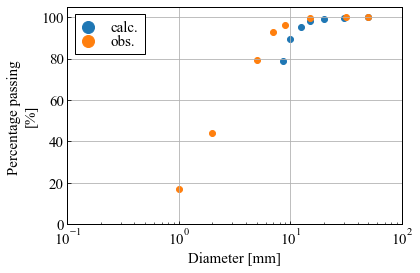

I set the initial alpha rate as 0.04694789278000002 here so that you can see how accurate the sediment distribution given by method2 even though I set the alpha as 0.21026292094333315 when optimizing


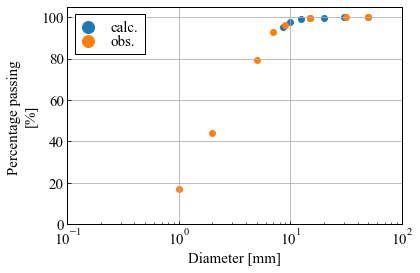

Zoomed out


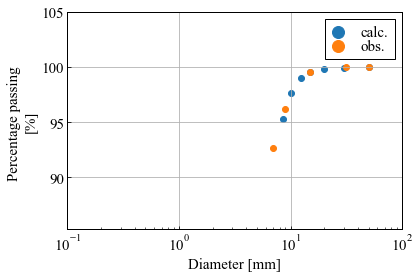

[8.5, 10, 12.5, 15, 20, 30, 50]
[  0.          30.35789474  60.04210526  89.72631578  92.83955343
  99.06602871 100.        ]


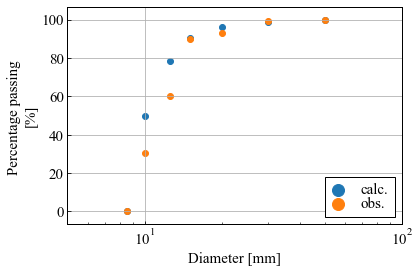

####################
期間： 2018/4/15 0:00 ~ 2018/4/28 0:00
I set the initial alpha rate as 21.026292094333314 here, because you set the alpha when optimizing


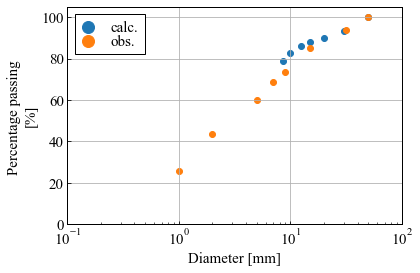

I set the initial alpha rate as 0.2753520641000001 here so that you can see how accurate the sediment distribution given by method2 even though I set the alpha as 0.21026292094333315 when optimizing


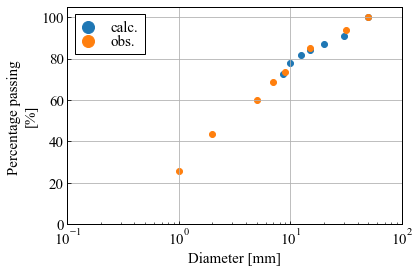

Zoomed out


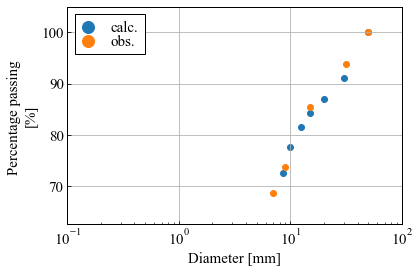

[8.5, 10, 12.5, 15, 20, 30, 50]
[  0.          11.69330409  29.22176956  46.75023504  56.04151829
  74.62408479 100.        ]


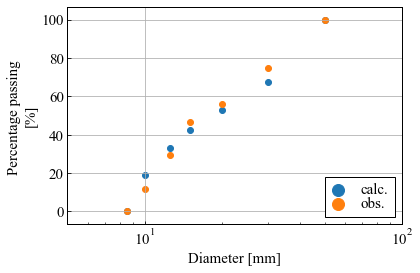

####################
期間： 2018/5/1 0:00 ~ 2018/5/20 0:00
I set the initial alpha rate as 21.026292094333314 here, because you set the alpha when optimizing


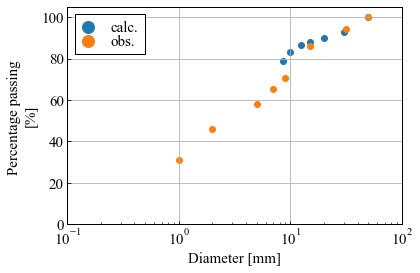

I set the initial alpha rate as 0.30848880594999994 here so that you can see how accurate the sediment distribution given by method2 even though I set the alpha as 0.21026292094333315 when optimizing


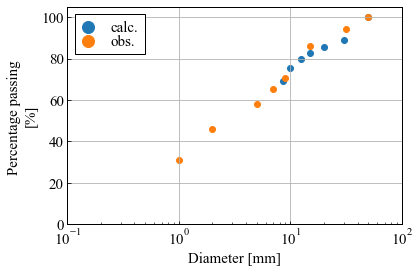

Zoomed out


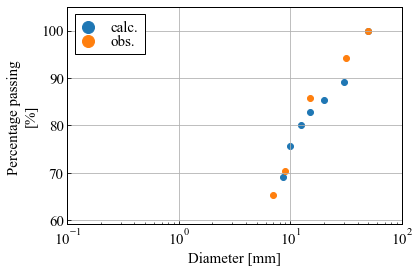

[8.5, 10, 12.5, 15, 20, 30, 50]
[  0.          12.53569869  33.36693209  54.1981655   62.48178794
  79.04903281 100.        ]


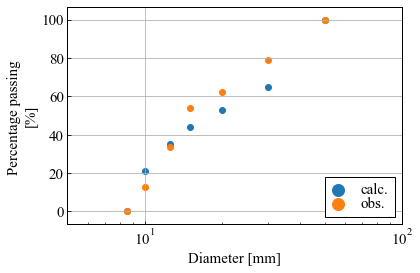

In [146]:
for i in range(num_furui):
    display_sediment_distributions(df_qcalc_each_all, furui_no=i)

以上，パルス数から流砂量を算出してピットデータと比較する流れです．  
こでは，ピット直上ハイドロフォンとピットデータから流砂量を算出していますが，5本のハイドロフォンデータを用いて横断分布観測もできます．基本的には同じ流れで，5本のハイドロフォンの中心のハイドロフォンとピットのデータを使ってCとβを算出して，残りの4本のハイドロフォンの規格が同じとしてそのC,βを使えばいいです．ただし，私の修論では，5本のハイドロフォンのデータが2018年以降のデータしかなく，データ数が少なかったため，ピット直上ハイドロフォンと5本のハイドロフォンの規格が全く同じであると仮定して，ピット直上ハイドロフォンデータから算出したC,βを使って横断分布を出しました．  
調べたところ，ピット直上ハイドロフォンと5本のセンターハイドロフォンはほぼ検出パルス数は/mに直すとほぼ１：１になりますが，パルスの飽和を起こすパルス数に違いがあるようです（長さが違うので）．厳密に議論したい場合，そのパルスの飽和について補正する必要があります．この議論を避けるならば，5本のハイドロフォンのデータ数を十分に溜めて，ピット直上ハイドロフォンデータを使わないべきです．

In [147]:
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))
        


|            Variable Name|    Memory|
 ------------------------------------ 
|                   df_all|1854593464|
|              df_all_diff|1607302144|
|          df_all_diff_use|   4006744|
|           df_events_mean|   3739824|
|          df_optimize_all|   3197944|
|         df_optimize_test|     25496|
|        df_optimize_train|    165952|
|        df_qcalc_each_all|   3197944|
|df_qcalc_train_nocorrected|    165952|
|                  df_test|   2731544|
|             df_test_mean|    260504|
|                 df_train|     78944|
|            df_train_mean|   2725984|
|                   gammas|     26736|
|                qcalc_all|   1849944|
|                 qobs_all|   1849944|
|                qobs_test|     14616|
|               qobs_train|     47432|
|            waterleve_all|   1849944|
|           waterleve_test|     14616|
|          waterleve_train|     47432|
